# Analysis of Leios simulations at tag `leios-2025w15`

## Load dependencies

In [1]:
suppressMessages({
    require(bit64, quietly=TRUE)
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(magrittr, quietly=TRUE)
    require(mongolite, quietly=TRUE)
    require(R.utils, quietly=TRUE)
    require(stringr, quietly=TRUE)
})

## 100-Node Network

### Receipt of messages

#### Read results

In [8]:
receipts <- fread("results/receipts.csv.gz", stringsAsFactors=TRUE)
receipts %>% summary

   simulator            label               network        
 haskell:11032258   default:17999000   100-nodes:17999000  
 rust   : 6966742                                          
                                                           
                                                           
                                                           
                                                           
                                                           
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 1.000            Min.   :98304          Min.   :1.5              
 1st Qu.: 4.500            1st Qu.:98304          1st Qu.:1.5              
 Median : 7.000            Median :98304          Median :1.5              
 Mean   : 6.434            Mean   :98304          Mean   :1.5              
 3rd Qu.: 8.500            3rd Qu.:98304          3rd Qu.:1.5              
 Max.   :10.000            Max.   :98304          Max.   :1.5   

#### Scenarios present in dataset

In [9]:
receipts[, .(`Records`=.N), by=.(`simulator`, `network`, `label`)]

simulator network   label   Records 
1 rust      100-nodes default  6966742
2 haskell   100-nodes default 11032258

#### IB rate variations

##### Compare the distributions of elapsed times

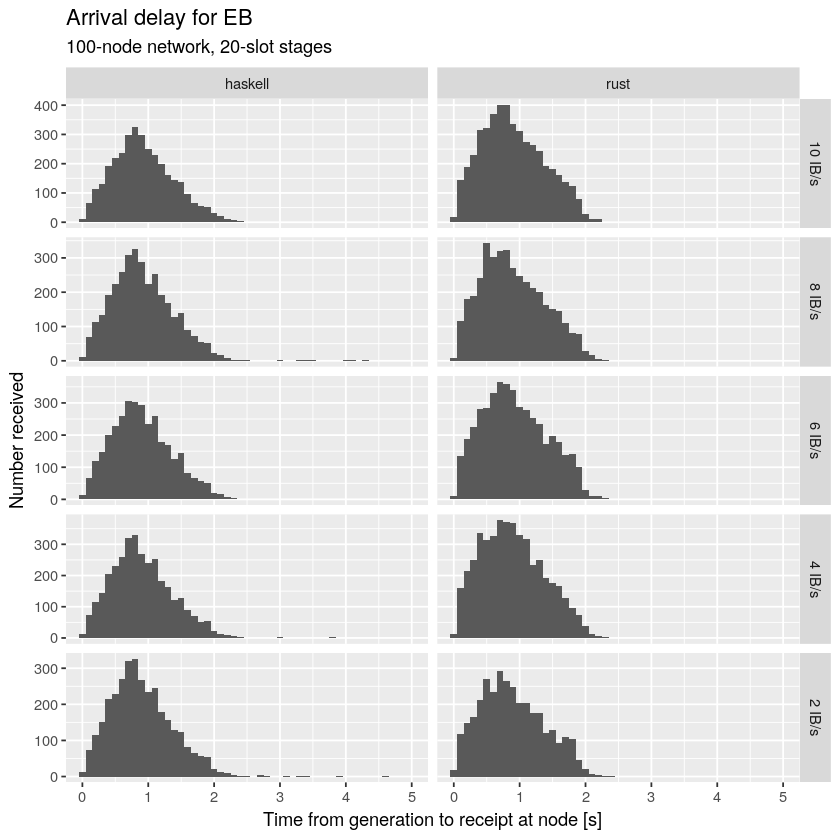

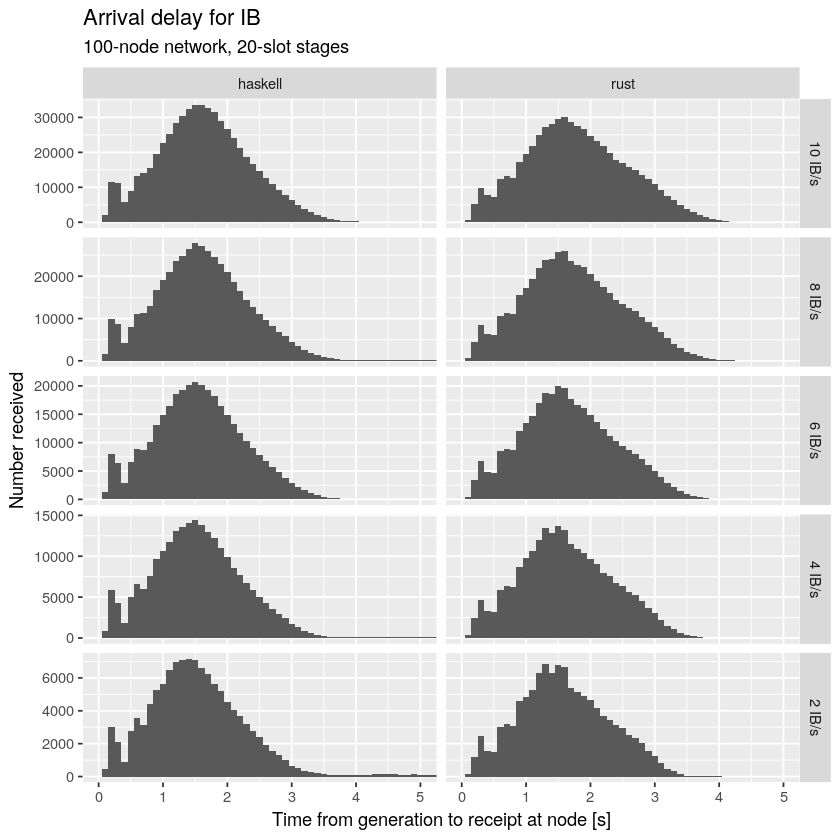

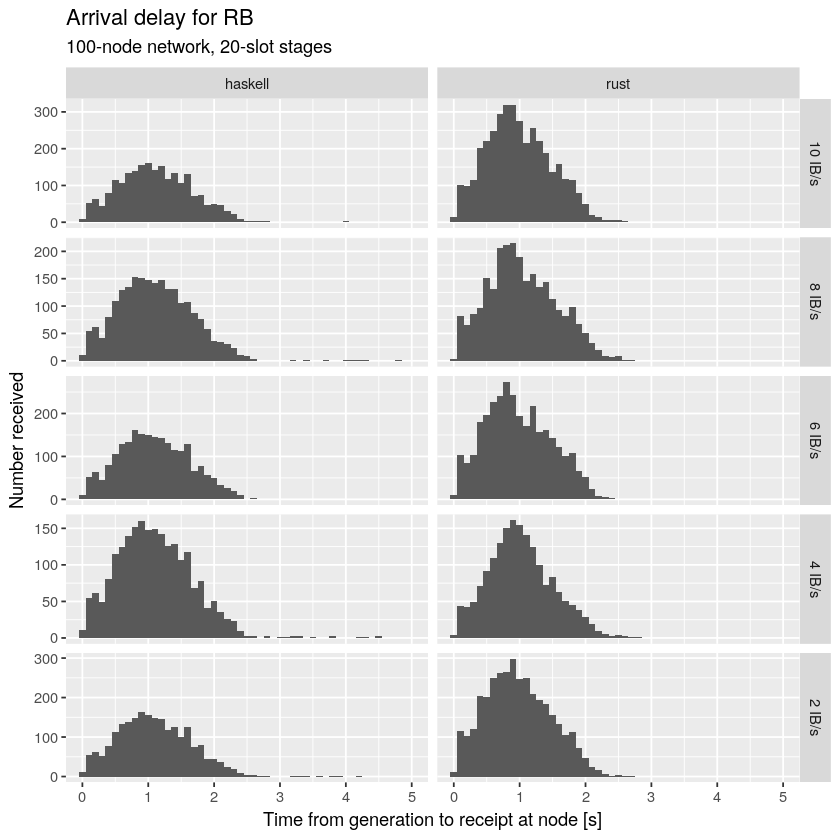

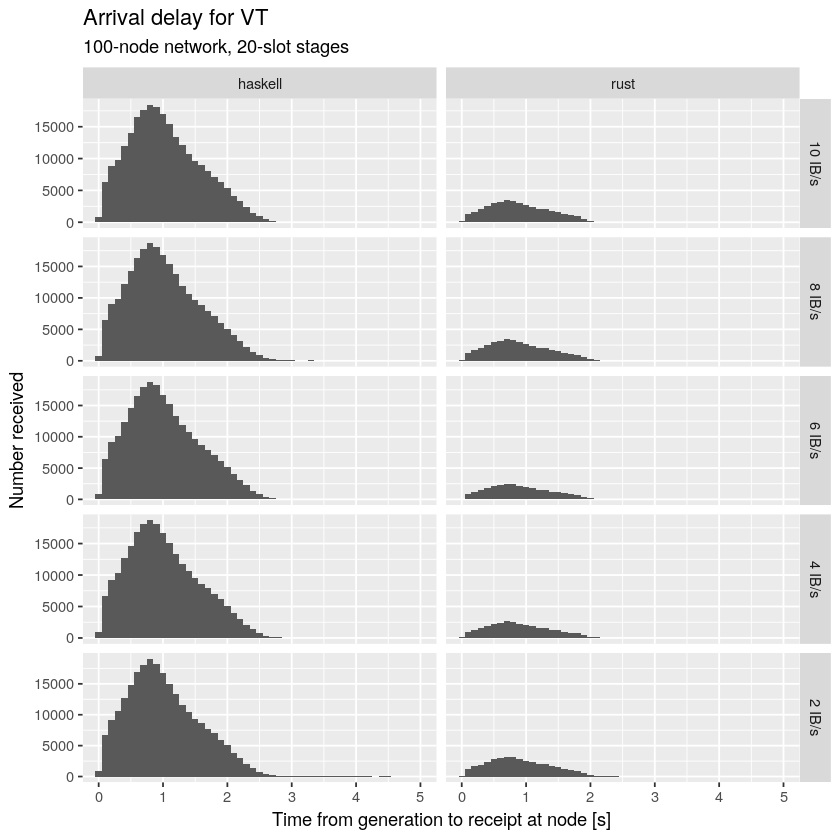

In [10]:
for (k in receipts[,unique(`kind`)%>%sort]) {
    g <- ggplot(
        receipts[
            `kind` == k & `ib-generation-probability` %in% (2*1:5),
            .(
                `simulator`,
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `elapsed`
            )
        ],
        aes(x=`elapsed`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`ibRate` ~ `simulator`, scales="free_y") +
        coord_cartesian(xlim=c(0, 5)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(paste("Arrival delay for", k), subtitle=paste0("100-node network, 20-slot stages"))
    print(g)
    ggsave(paste0("plots/elapsed-", k, ".png"), units="in", width=8, height=6, dpi=150)
}

#### Fraction of items arriving

In [11]:
arrival <- receipts[
    `ib-generation-probability` %in% (2*1:5),
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`)
]

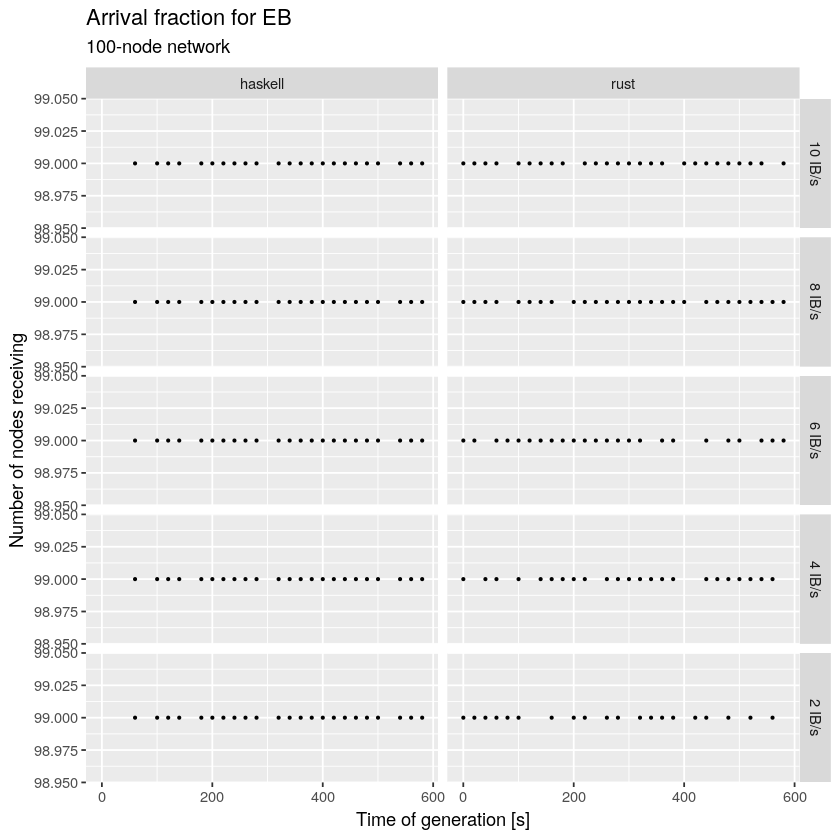

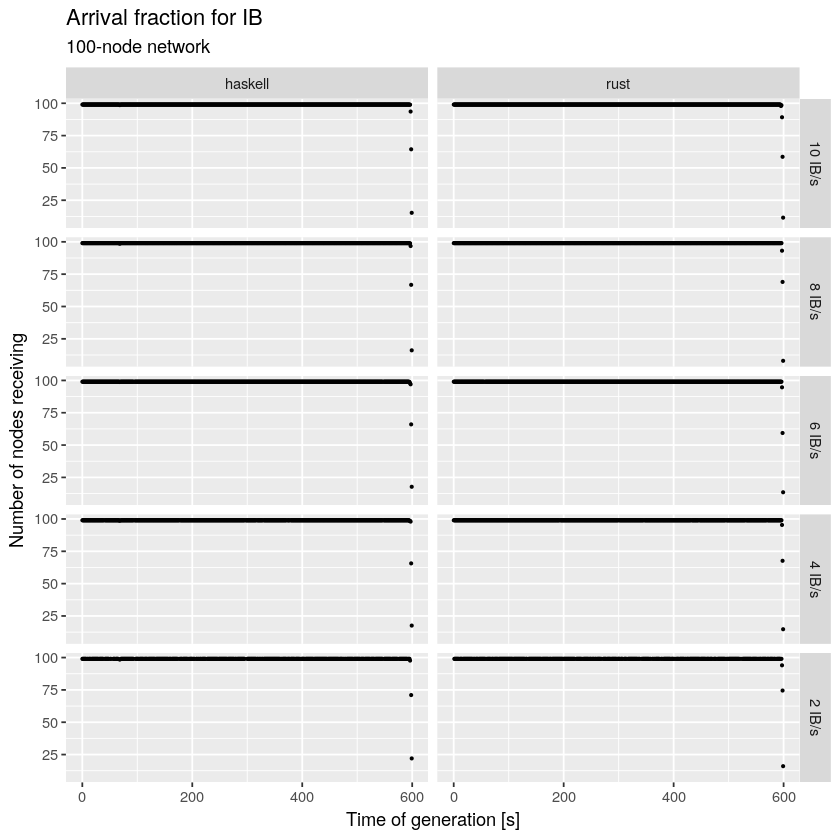

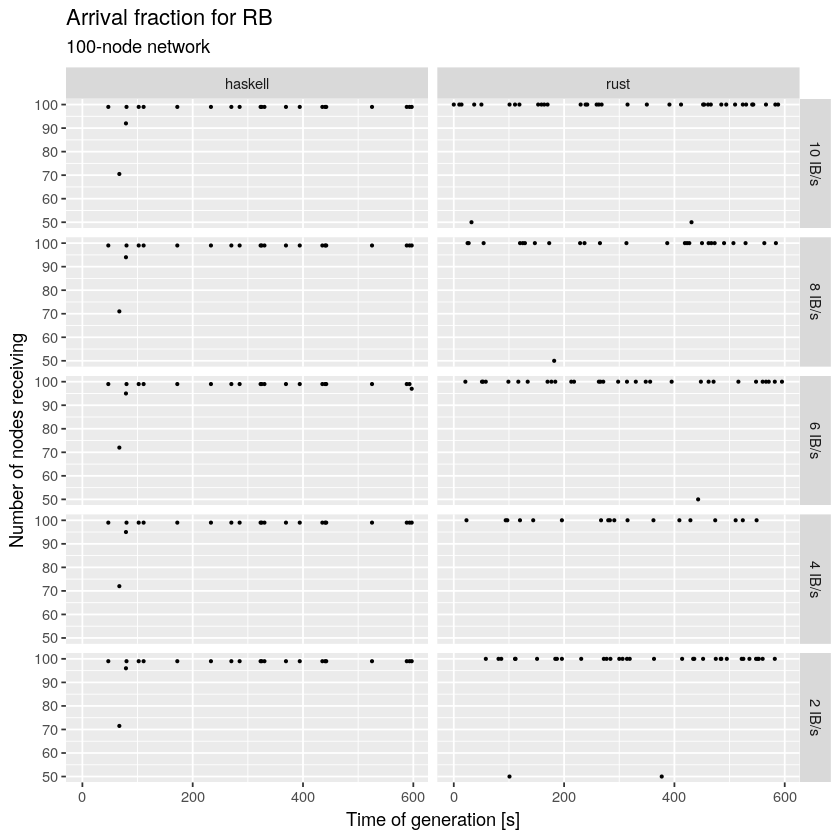

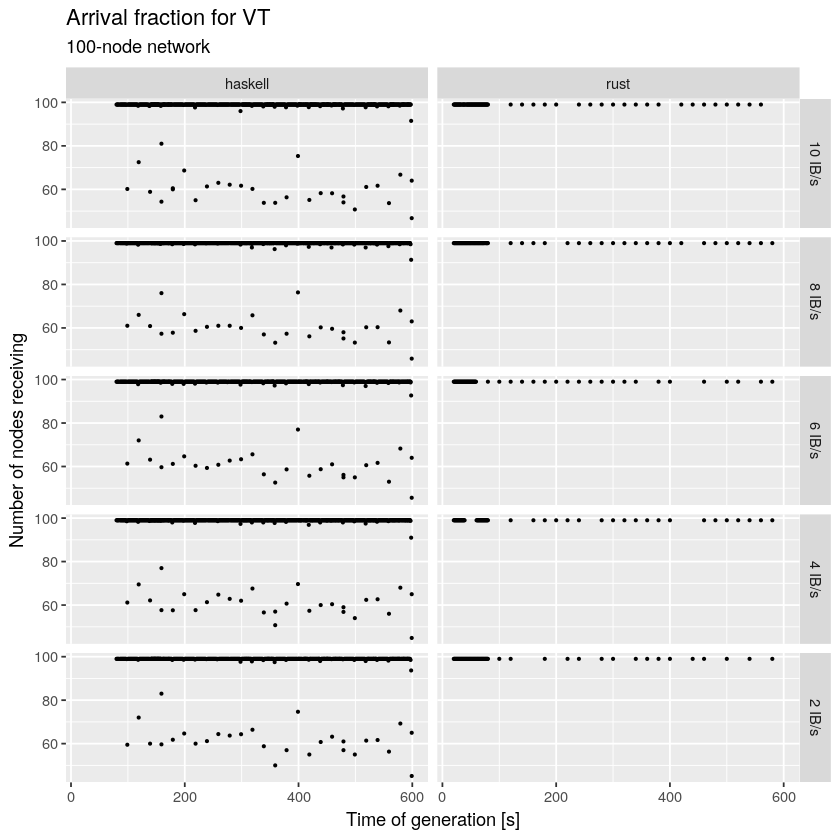

In [12]:
for (k in arrival[,unique(`kind`)%>%sort]) {
    g <- ggplot(
        arrival[
            `kind` == k,
            .(
                `simulator`,
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `sent`,
                `received`
            )
        ], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate`  ~ `simulator`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(paste("Arrival fraction for", k), subtitle="100-node network")
    print(g)
    ggsave(paste0("plots/arrival-", k, ".png"), units="in", width=8, height=6, dpi=150)
}

#### Bandwidth usage

##### Total network bandwidth

In [15]:
receipts[
            ,
            .(
                `size`=sum(`size`, na.rm=TRUE)/1000000000
            ),
            by=.(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `slot`=floor(`received`),
                `Message`=`kind`, `simulator`, `received`
            )
        ] %>% summary #[, .N, .(`simulator`, `ibRate`,`ibSize`)]

      ibRate             slot     Message         simulator       
 10 IB/s :1469521   Min.   :  0   EB:  150162   haskell:11024183  
 9.5 IB/s:1412715   1st Qu.:156   IB:12252325   rust   : 6901727  
 9 IB/s  :1350910   Median :305   RB:  101324                     
 8.5 IB/s:1291458   Mean   :304   VT: 5422099                     
 8 IB/s  :1247812   3rd Qu.:452                                   
 7.5 IB/s:1189702   Max.   :599                                   
 (Other) :9963792                                                 
    received             size          
 Min.   :  0.1082   Min.   :0.000e+00  
 1st Qu.:156.3589   1st Qu.:0.000e+00  
 Median :305.2976   Median :1.050e-07  
 Mean   :304.5379   Mean   :3.389e-05  
 3rd Qu.:452.0989   3rd Qu.:9.861e-05  
 Max.   :600.0000   Max.   :3.944e-04  
                                       

Warning message:
“Removed 3728 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 3728 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 3728 rows containing non-finite values (`stat_align()`).”
Warning message:
“Removed 3728 rows containing non-finite values (`stat_align()`).”


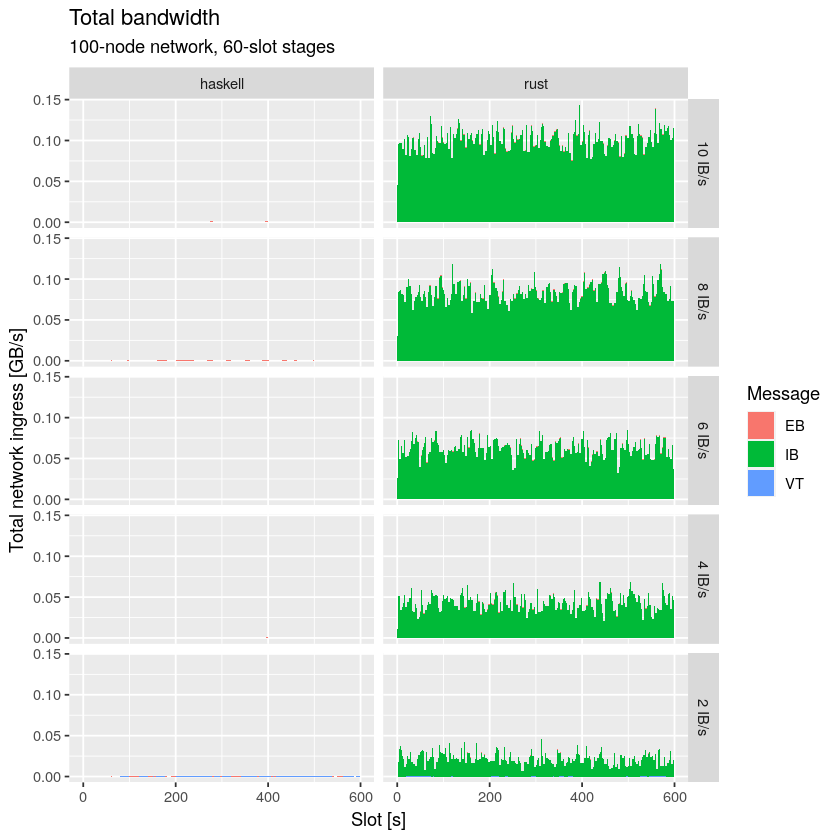

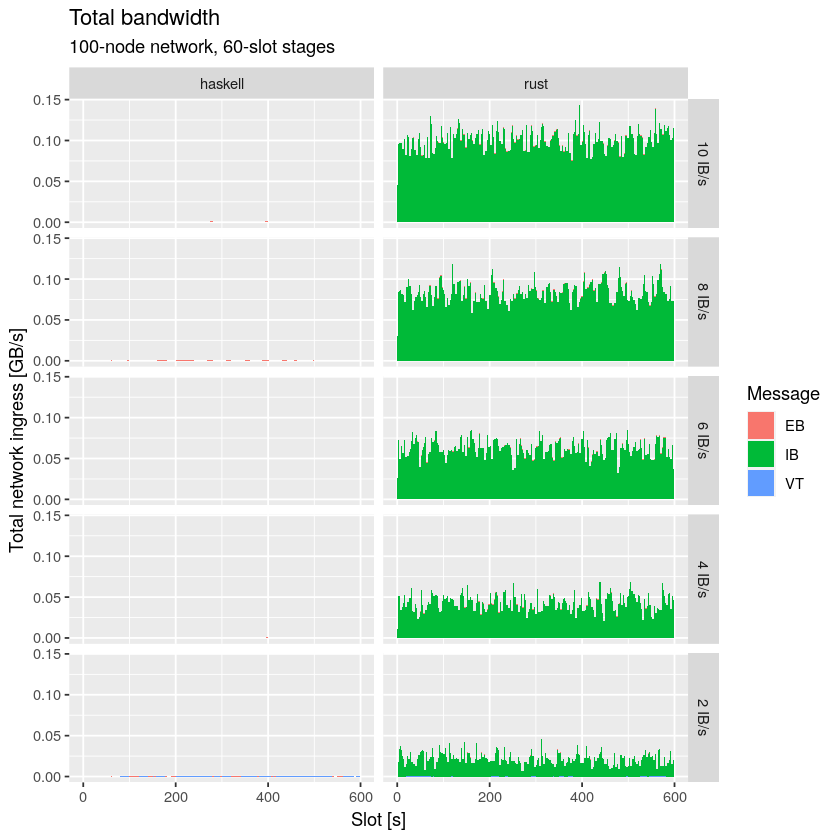

In [16]:
for (s in receipts[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        receipts[
            `ib-generation-probability` %in% (2*1:5) & !is.na(`elapsed`),
            .(
                `size`=sum(`size`)/1000000000
            ),
            by=.(
                `simulator`,
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`ibRate` ~ `simulator`) +
        xlab("Slot [s]") +
        ylab("Total network ingress [GB/s]") +
        ggtitle("Total bandwidth", subtitle="100-node network, 60-slot stages")
    print(g)
    ggsave(paste0("plots/ingress-total-area.png"), units="in", width=8, height=6, dpi=150)
}

<font color="red">WORK IN PROGRESS FOLLOWS</font>

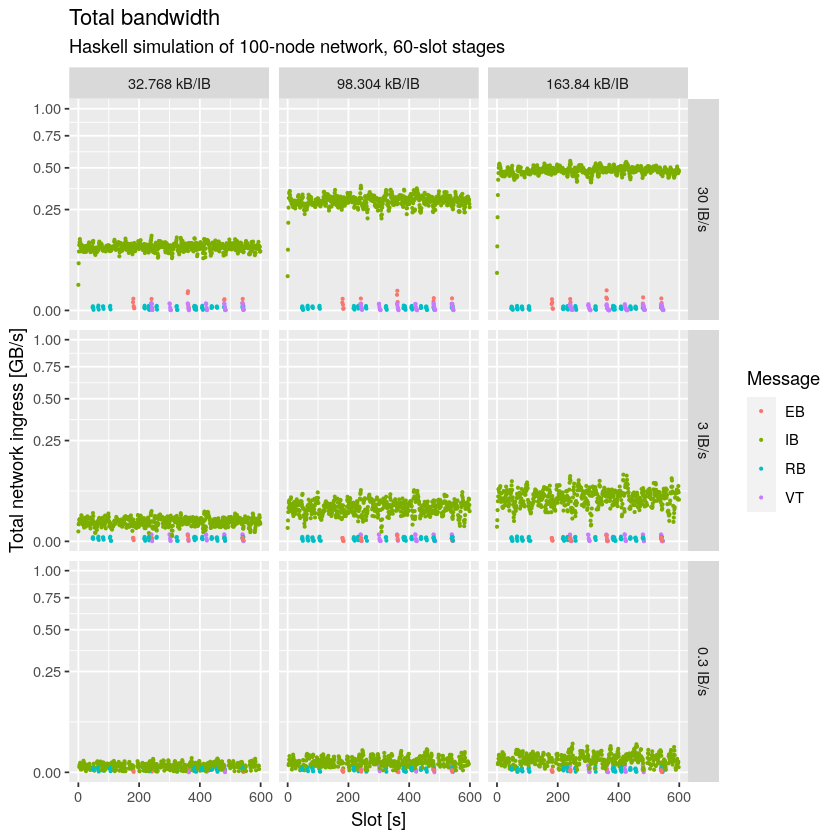

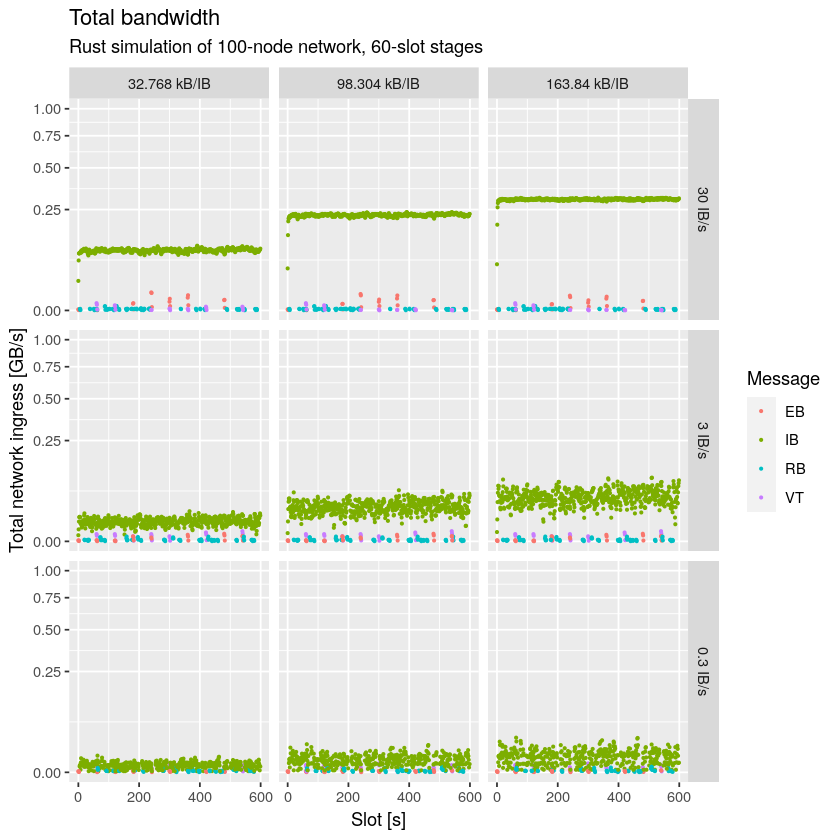

In [9]:
for (s in receipts[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == "default" & !is.na(`received`),
            .(
                `size`=sum(`size`)/1000000000
            ),
            by=.(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `ibSize`) +
        scale_y_sqrt(limits=c(0, 1)) +
        xlab("Slot [s]") +
        ylab("Total network ingress [GB/s]") +
        ggtitle("Total bandwidth", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
    print(g)
    ggsave(paste0("plots/ingress-total-point-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

##### Bandwidth usage per node

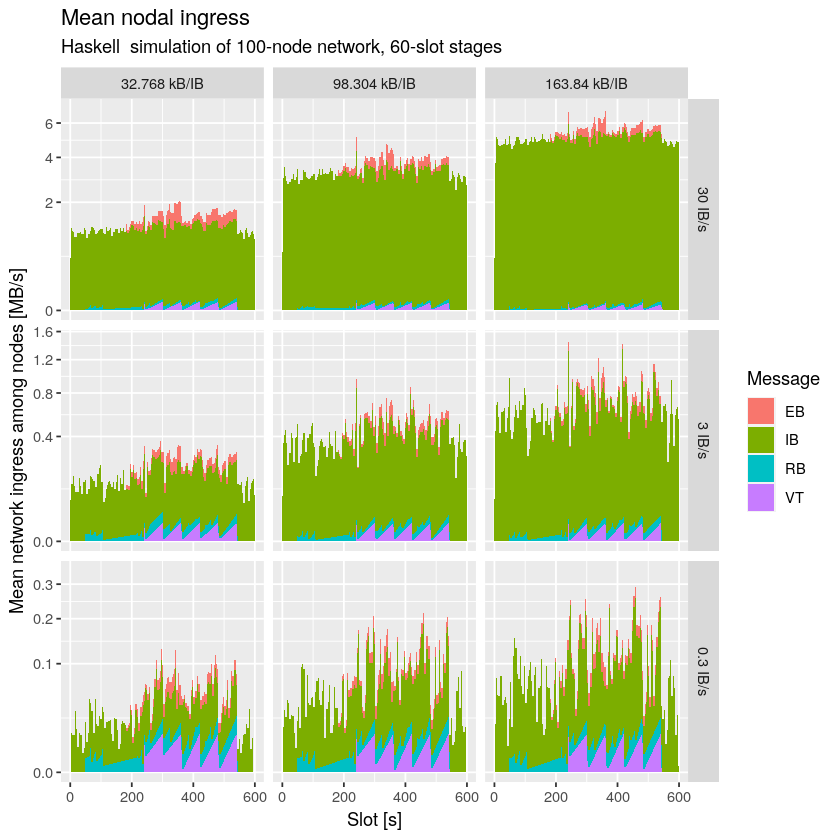

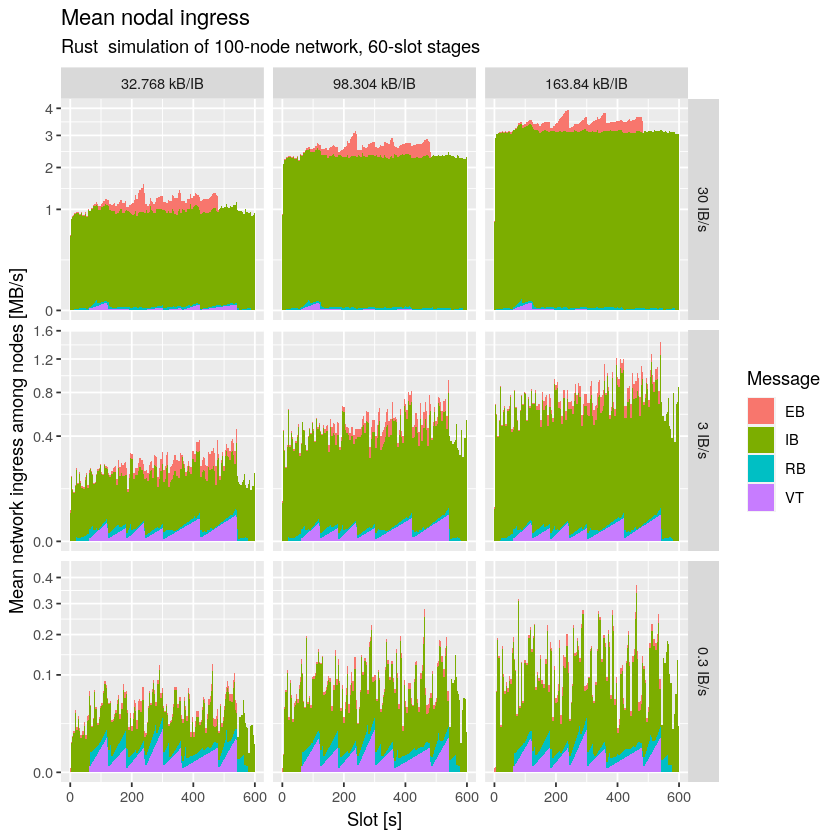

In [10]:
for (s in receipts[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == "default" & !is.na(`received`),
            .(
                `size`=sum(`size`)/1000000 / 100
            ),
            by=.(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [MB/s]") +
        ggtitle("Mean nodal ingress", subtitle=paste(s %>% str_to_title, " simulation of 100-node network, 60-slot stages"))
    print(g)
    ggsave(paste0("plots/ingress-average-area-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

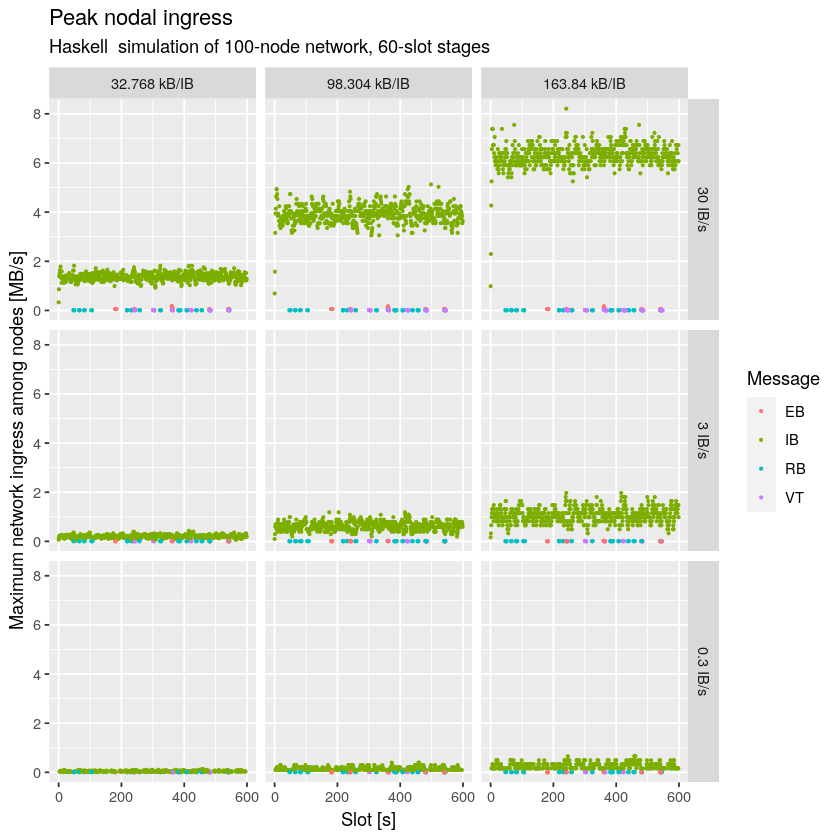

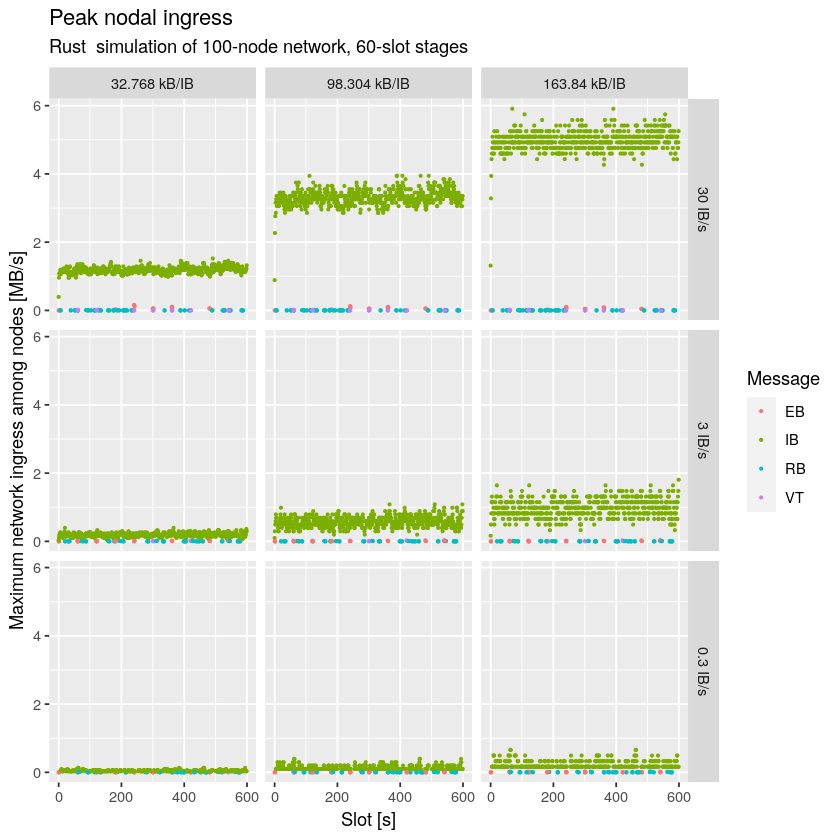

In [11]:
for (s in receipts[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == "default" & !is.na(`received`),
            .(
                `size`=sum(`size`)/1000000
            ),
            by=.(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `slot`=floor(`received`),
                `Message`=`kind`,
                `recipient`
            )
        ][,
            .(`size`=max(`size`)),
            by=.(`ibRate`, `ibSize`, `slot`, `Message`)
        ],
        aes(x=`slot`, y=`size`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `ibSize`) +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [MB/s]") +
        ggtitle("Peak nodal ingress", subtitle=paste(s %>% str_to_title, " simulation of 100-node network, 60-slot stages"))
    print(g)
    ggsave(paste0("plots/ingress-peak-point-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

### CPU usage

#### Read results

In [12]:
if (file.exists("results/cpus.csv.gz")) {
    cpus <- fread("results/cpus.csv.gz", stringsAsFactors=TRUE)
} else {
    cpus <- data.table(mongo(url="mongodb://thelio", db="leios2025w12", collection="cpus")$find(), stringsAsFactors=TRUE)
    fwrite(cpus, "results/cpus.csv")
}
cpus %>% summary

   simulator           network        leios-stage-length-slots
 haskell:995987   100-nodes:1905566   Min.   :60              
 rust   :909579                       1st Qu.:60              
                                      Median :60              
                                      Mean   :60              
                                      3rd Qu.:60              
                                      Max.   :60              
                                                              
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 0.3              Min.   : 32768         Min.   :1.5              
 1st Qu.: 3.0              1st Qu.: 32768         1st Qu.:1.5              
 Median : 3.0              Median : 98304         Median :1.5              
 Mean   :14.7              Mean   : 98589         Mean   :1.5              
 3rd Qu.:30.0              3rd Qu.:163840         3rd Qu.:1.5              
 Max.   :30.0              Max.   :16384

In [13]:
cpusNode <-
cpus[
    `slot` >= 60 & `slot` <= 540,
    .(
        `duration`=sum(`duration`)
    ),
    by=.(
        `simulator`,
        `ib-generation-probability`,
        `ib-body-avg-size-bytes`,
        `leios-stage-length-slots`,
        `node`,
        `slot`
    )
]

#### Peak CPU usage

##### Histogram

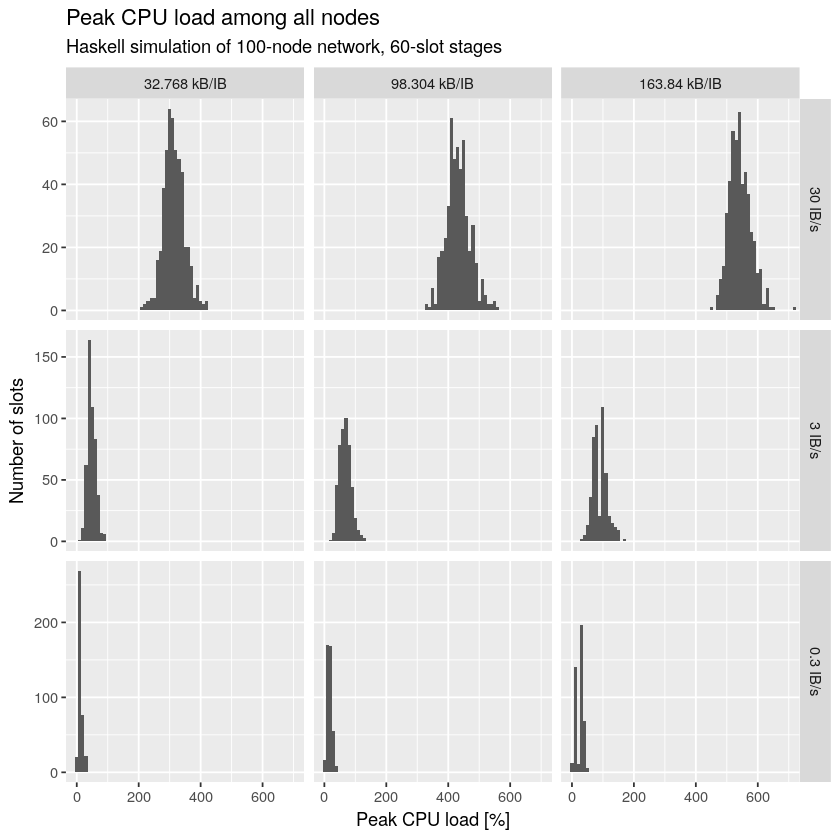

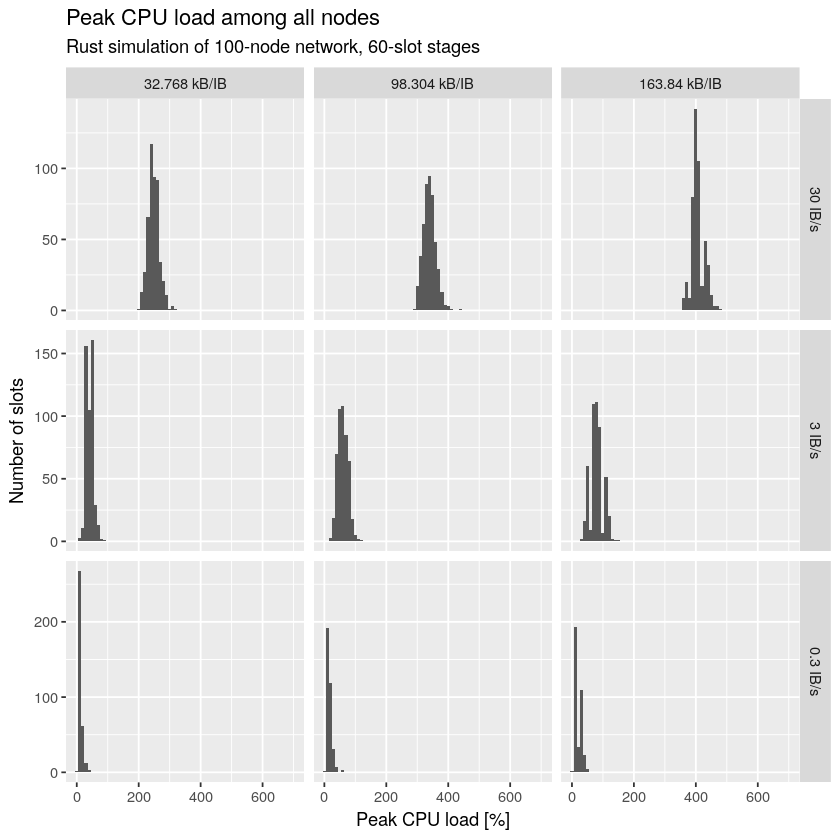

In [14]:
for (s in cpusNode[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    cpusNode[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*max(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`
        )
    ], 
    aes(x=`duration`)) +
    geom_histogram(binwidth=10) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    coord_cartesian(xlim=c(0, 700)) +
    xlab("Peak CPU load [%]") +
    ylab("Number of slots") +
    ggtitle("Peak CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/cpu-peak-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
    
}

##### Time series

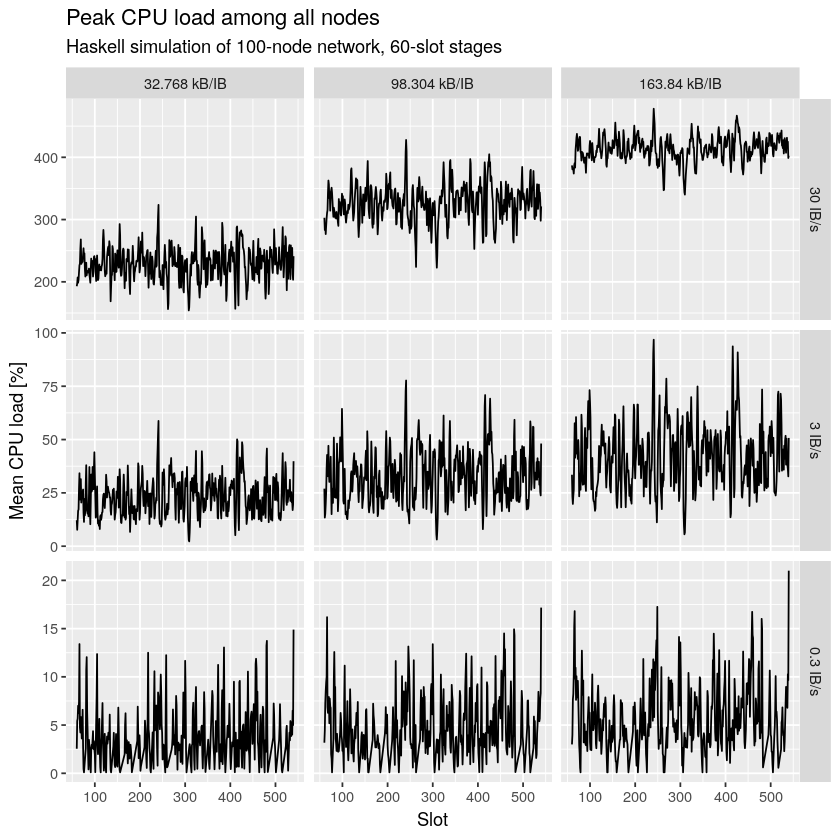

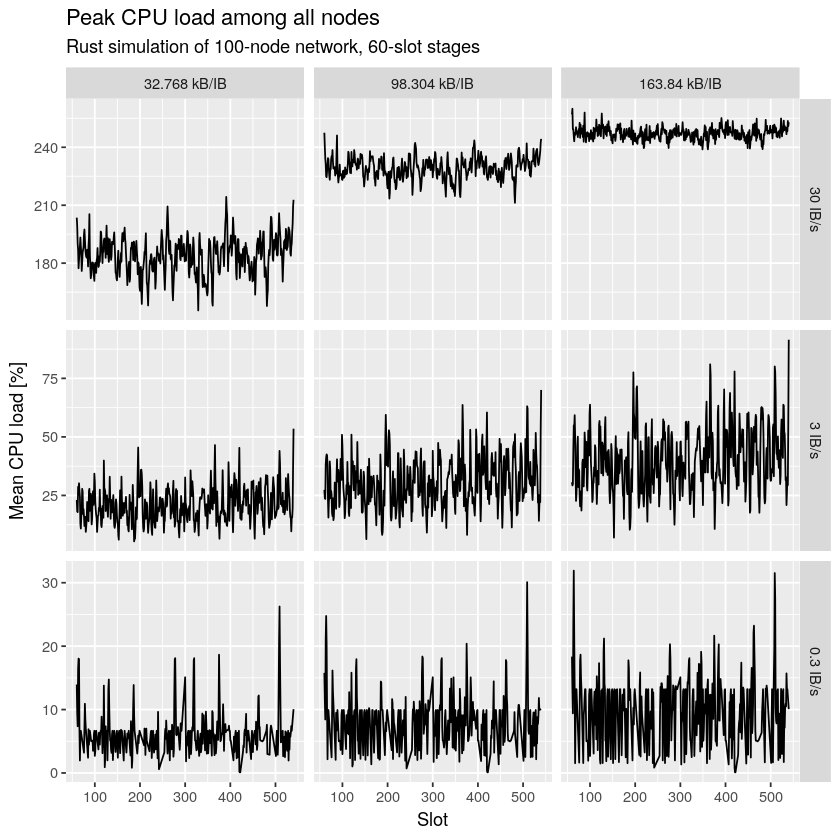

In [15]:
for (s in cpus[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    cpusNode[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`
        )
    ], 
    aes(x=`slot`, y=`duration`)) +
    geom_line() +
    facet_grid(`ibRate` ~ `ibSize`, scale="free_y") +
    xlab("Slot") +
    ylab("Mean CPU load [%]") +
    ggtitle("Peak CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/cpu-peak-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### Mean CPU usage

##### Histogram

In [16]:
retask <- function(h) {
    if (h == "GenIB")
        "IBBlockGenerated"
    else if (h == "ValIH")
        "IBHeaderValidated"
    else if (h == "ValIB")
        "IBBlockValidated"
    else if (h == "GenEB")
        "EBBlockGenerated"
    else if (h =="ValEB")
        "EBBlockValidated"
    else if (h == "GenVote")
        "VTBundleGenerated"
    else if (h == "ValVote")
        "VTBundleValidated"
    else if (h == "GenRB")
        "RBBlockGenerated"
    else if (h == "ValRB")
        "RBBlockValidated"
    else if (h == "ValRH")
        "RBHeaderValidated"
    else
        h
}

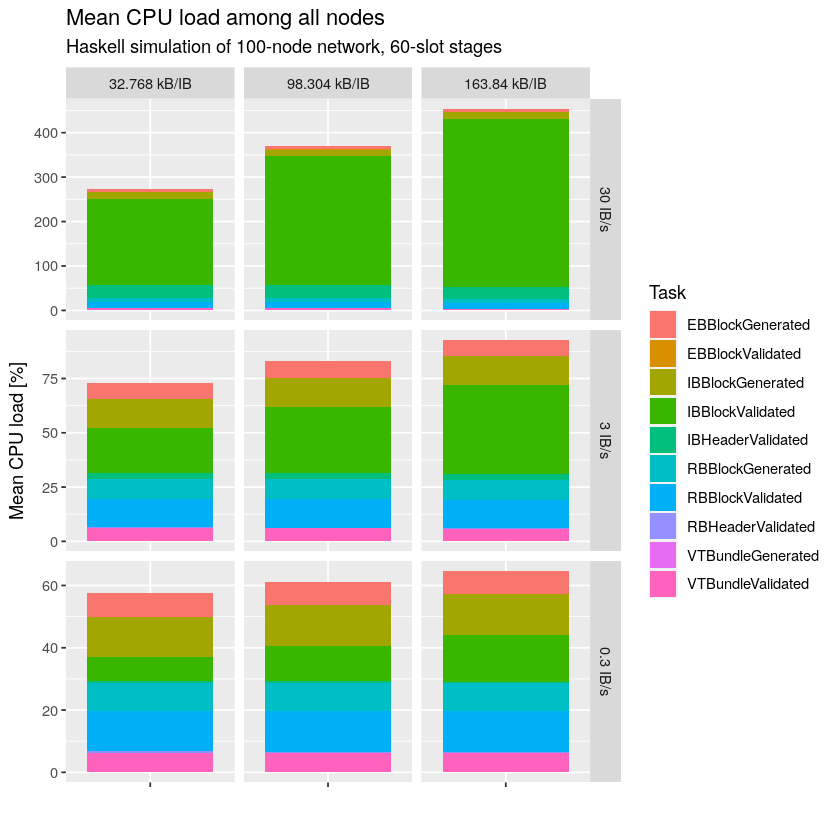

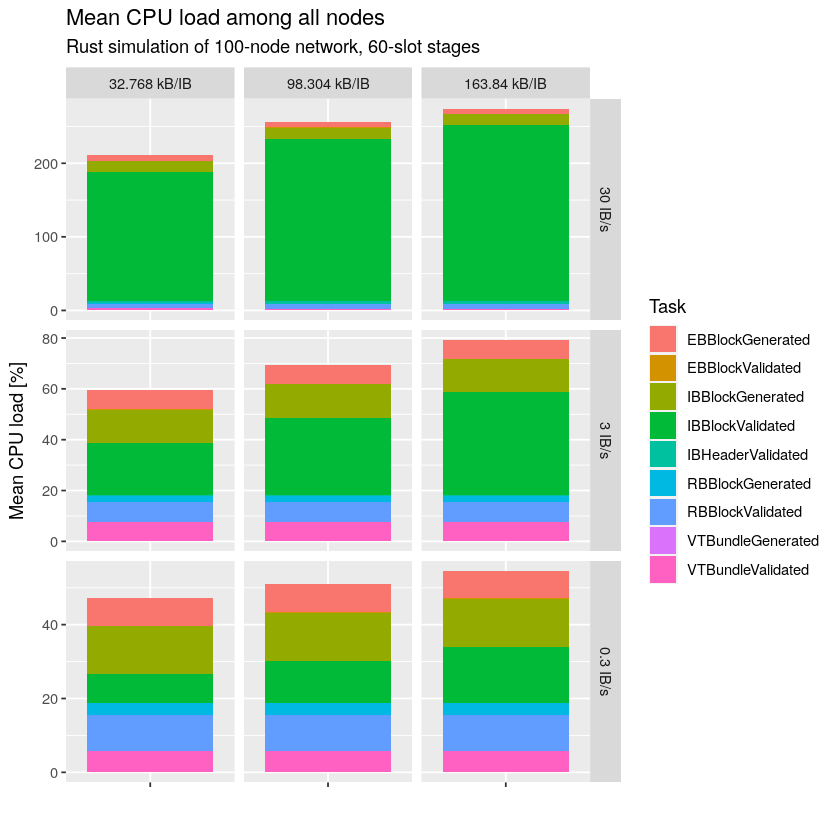

In [17]:
for (s in cpus[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    cpus[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Task`=mapply(retask, `task`)
        )
    ], 
    aes(x="", fill=`Task`, y=`duration`)) +
    geom_bar(stat = "identity") +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("") +
    ylab("Mean CPU load [%]") +
    ggtitle("Mean CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/cpu-mean-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

##### Time series

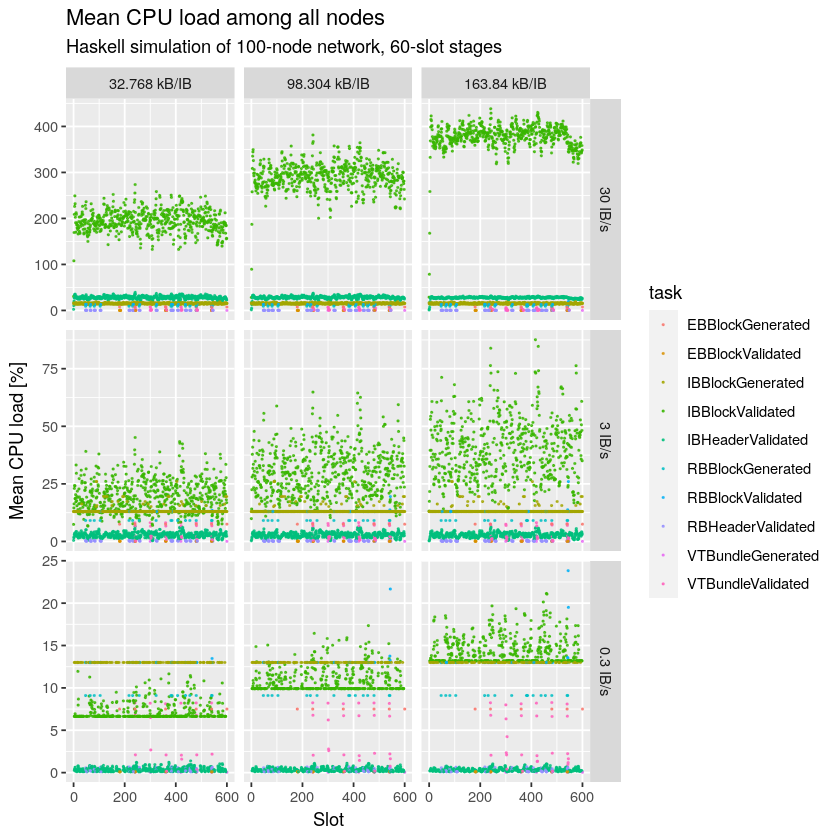

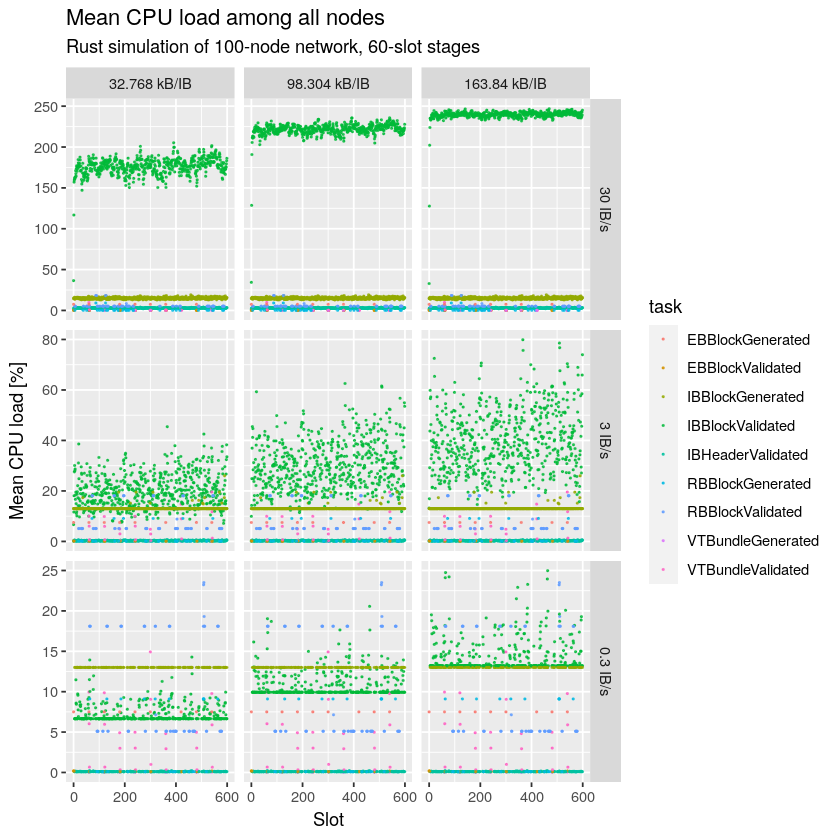

In [18]:
for (s in cpus[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    cpus[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`,
            `task`=mapply(retask, `task`)
        )
    ], 
    aes(x=`slot`, y=`duration`, color=`task`)) +
    geom_point(size=0.25, alpha=0.75) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("Slot") +
    ylab("Mean CPU load [%]") +
    ggtitle("Mean CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/cpu-mean-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### Fraction throttled

In [19]:
# TBD

#### Idle time

In [20]:
# TBD

### Input blocks

#### Read results

In [21]:
if (file.exists("results/ibgen.csv.gz")) {
    ibgen <- fread("results/ibgen.csv.gz", stringsAsFactors=TRUE)
} else {
    ibgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w12", collection="ibgen")$find(), stringsAsFactors=TRUE)
    fwrite(ibgen, "results/ibgen.csv")
}
ibgen %>% summary

   simulator          network           label        leios-stage-length-slots
 haskell:59673   100-nodes:119346   default:119346   Min.   :60              
 rust   :59673                                       1st Qu.:60              
                                                     Median :60              
                                                     Mean   :60              
                                                     3rd Qu.:60              
                                                     Max.   :60              
                                                                             
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 0.30             Min.   : 32768         Min.   :1.5              
 1st Qu.:30.00             1st Qu.: 32768         1st Qu.:1.5              
 Median :30.00             Median : 98304         Median :1.5              
 Mean   :27.32             Mean   : 98304         Mean   :1.5           

#### IB inculsion in EBs

##### Histogram

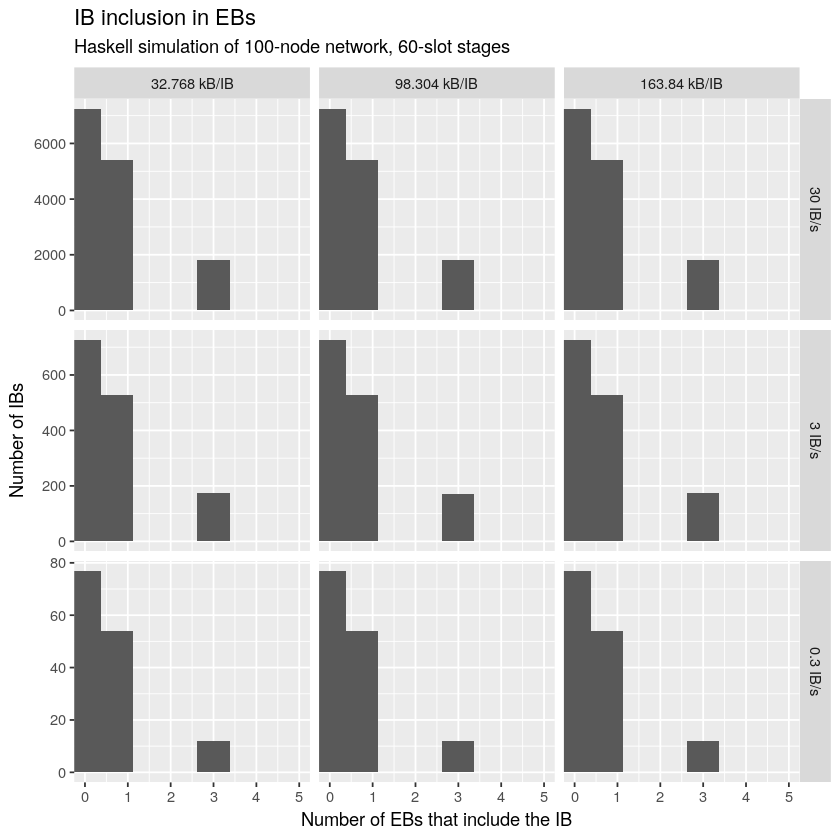

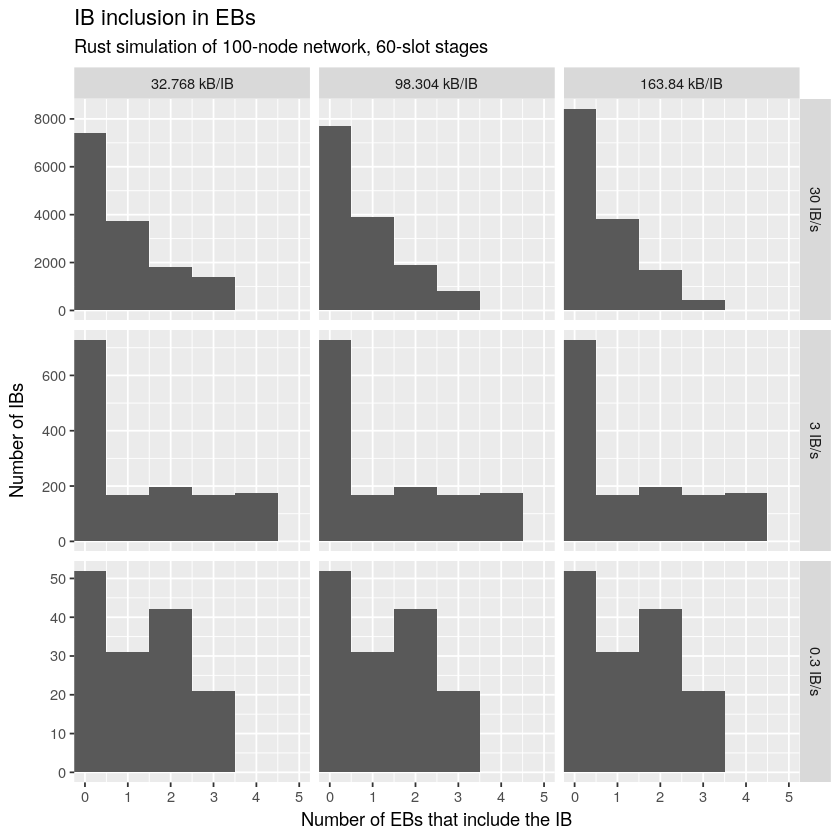

In [22]:
for (s in ibgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of EBs that include the IB`=`eb-count`
        )
    ],
    aes(x=`Number of EBs that include the IB`)
) +
    geom_histogram(bins=5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    coord_cartesian(xlim=c(0, 5)) +
    ylab("Number of IBs") +
    ggtitle("IB inclusion in EBs", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/ib-inclusion-ebs-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

##### Time series

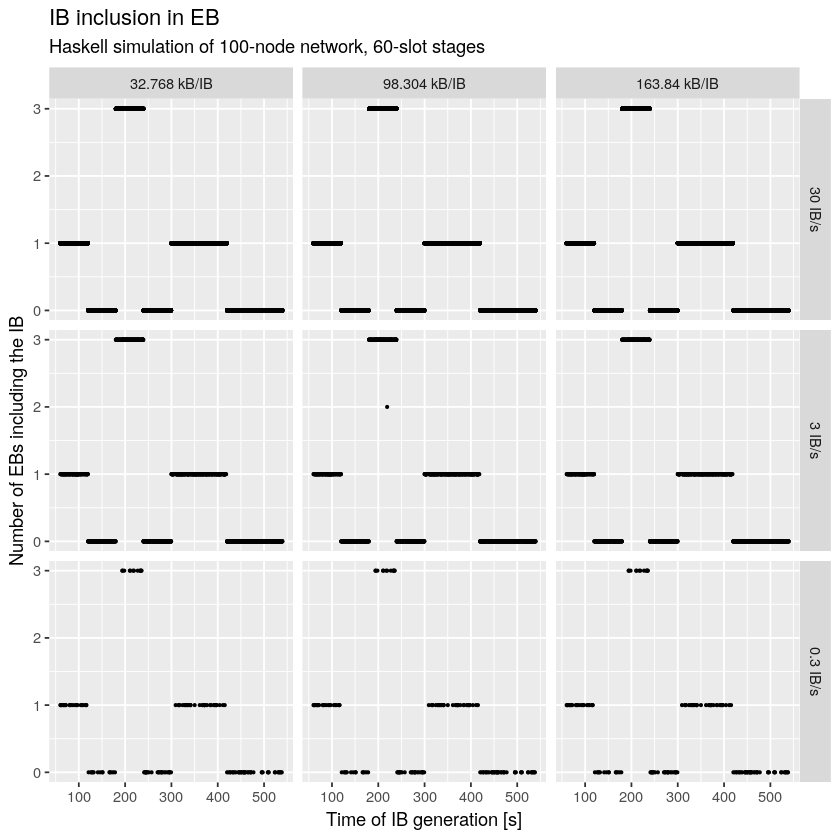

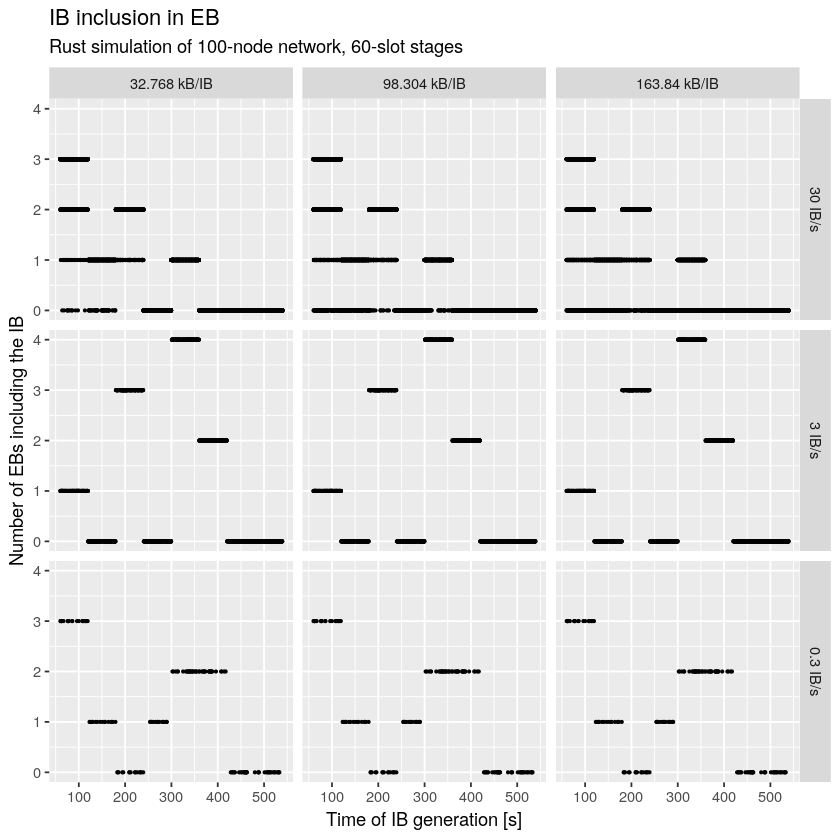

In [23]:
for (s in ibgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `Number of EBs including the IB`=`eb-count`
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`Number of EBs including the IB`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB inclusion in EB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/ib-inclusion-ebs-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### Time of IB inclusion in an EB

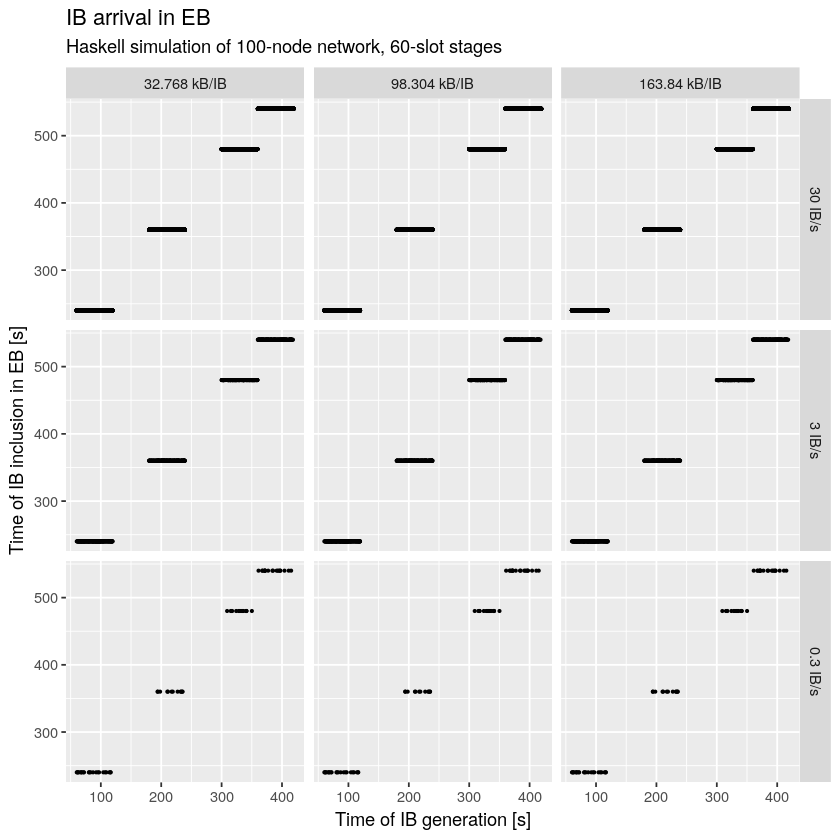

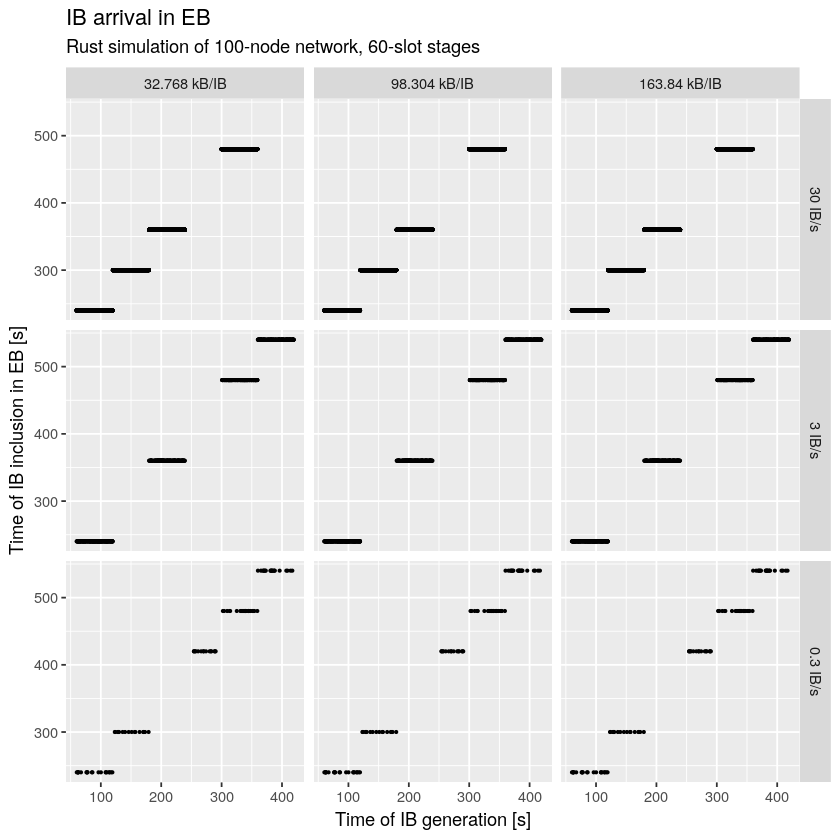

In [24]:
for (s in ibgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & !is.na(`eb-first`) & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `Time of IB inclusion in EB [s]`=`eb-first`
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`Time of IB inclusion in EB [s]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB arrival in EB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/ib-arrival-eb-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### IB size

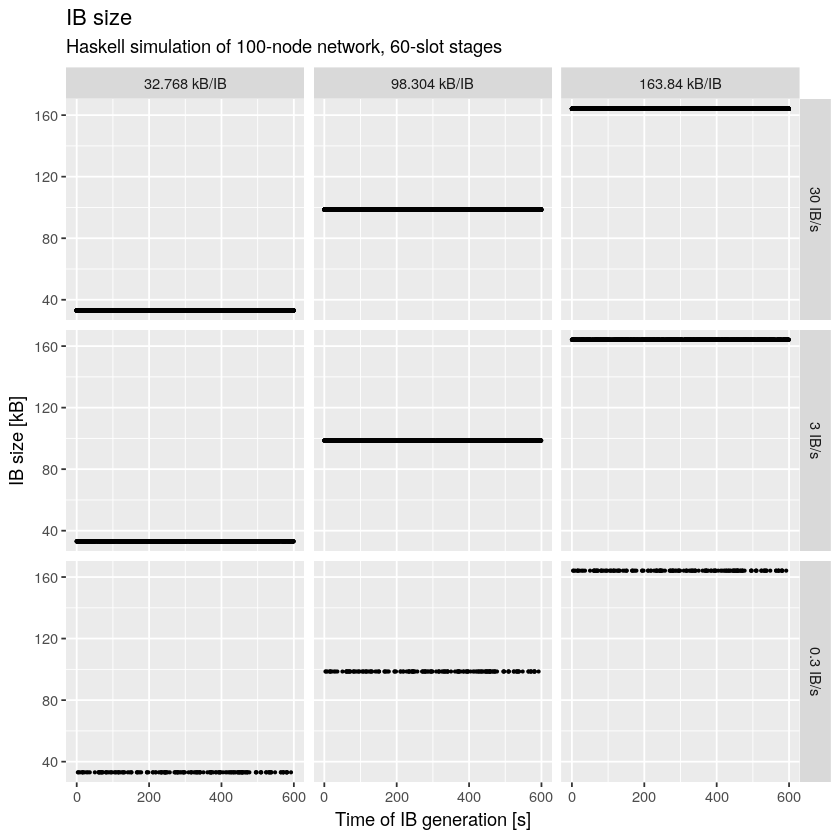

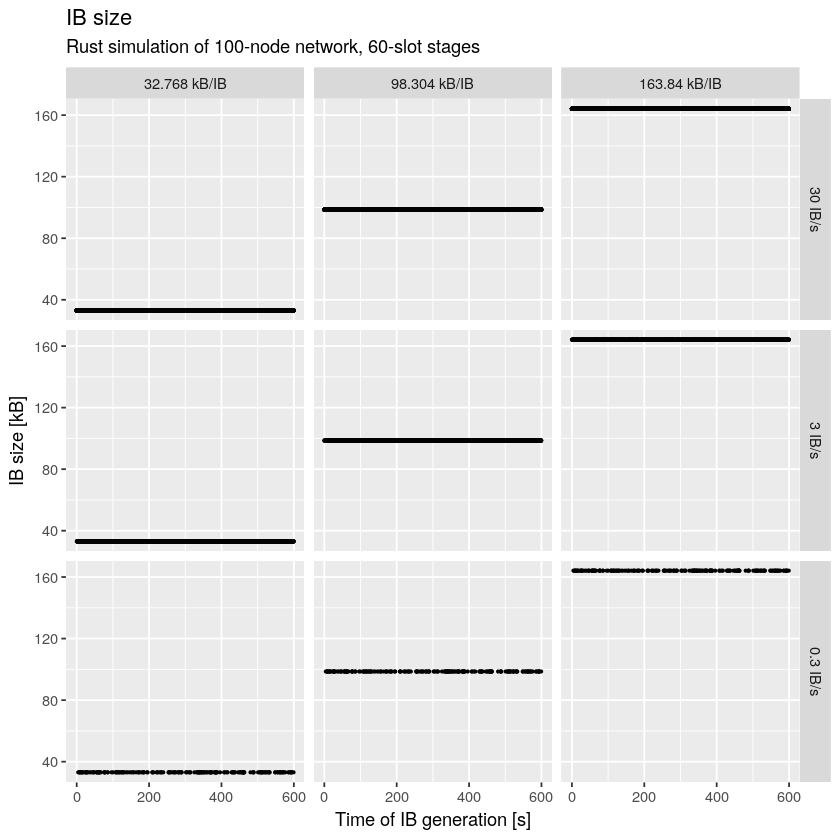

In [25]:
for (s in ibgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `IB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`IB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB size", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/ib-size-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

### Endorser blocks

#### Read results

In [26]:
if (file.exists("results/ebgen.csv.gz")) {
    ebgen <- fread("results/ebgen.csv.gz", stringsAsFactors=TRUE)
} else {
    ebgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w12", collection="ebgen")$find(), stringsAsFactors=TRUE)
    fwrite(ebgen, "results/ebgen.csv")
}
ebgen %>% summary

   simulator        network        label     leios-stage-length-slots
 haskell: 63   100-nodes:192   default:192   Min.   :60              
 rust   :129                                 1st Qu.:60              
                                             Median :60              
                                             Mean   :60              
                                             3rd Qu.:60              
                                             Max.   :60              
                                                                     
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 0.300            Min.   : 32768         Min.   :1.5              
 1st Qu.: 0.300            1st Qu.: 32768         1st Qu.:1.5              
 Median : 3.000            Median : 98304         Median :1.5              
 Mean   : 9.666            Mean   : 98304         Mean   :1.5              
 3rd Qu.:30.000            3rd Qu.:163840         3rd Qu.:1.

#### EB inclusion in RBs

##### Histogram

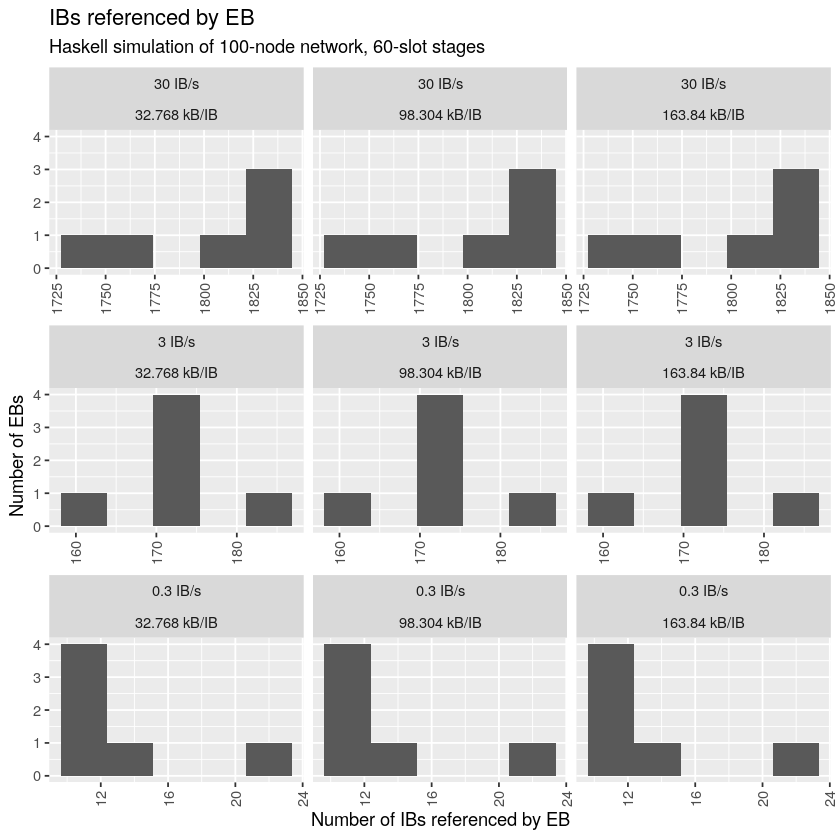

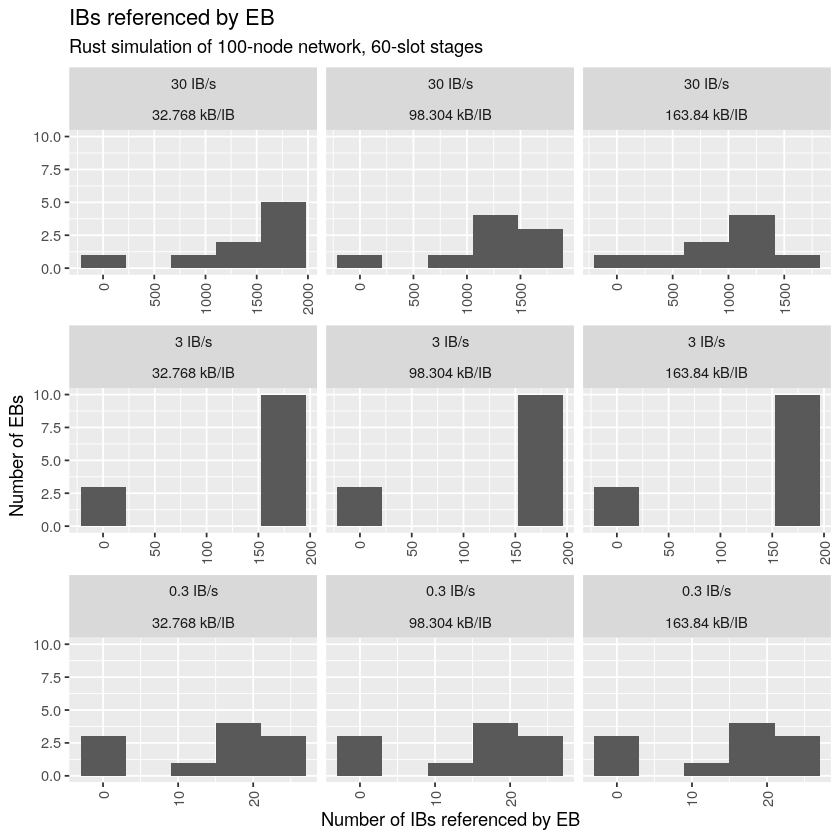

In [27]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of IBs referenced by EB`=`ib-count`
        )
    ],
    aes(x=`Number of IBs referenced by EB`)
) +
    geom_histogram(bins=5) +
    facet_wrap(`ibRate` ~ `ibSize`, scales="free_x") +
    ylab("Number of EBs") +
    ggtitle("IBs referenced by EB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages")) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
print(g)
ggsave(paste0("plots/ibs-referenced-eb-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

##### Time series

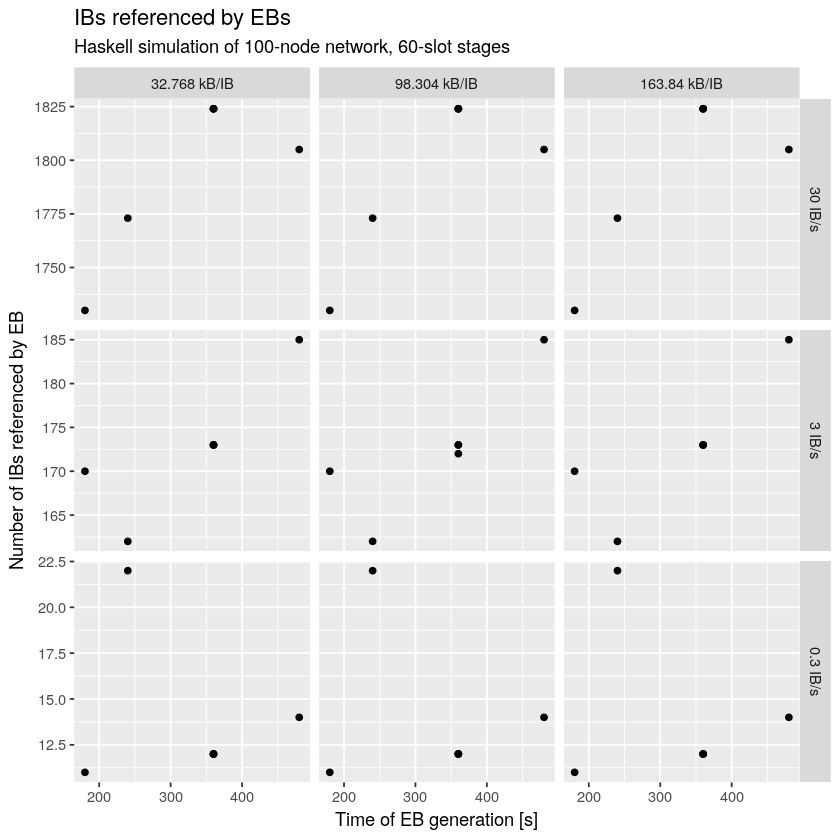

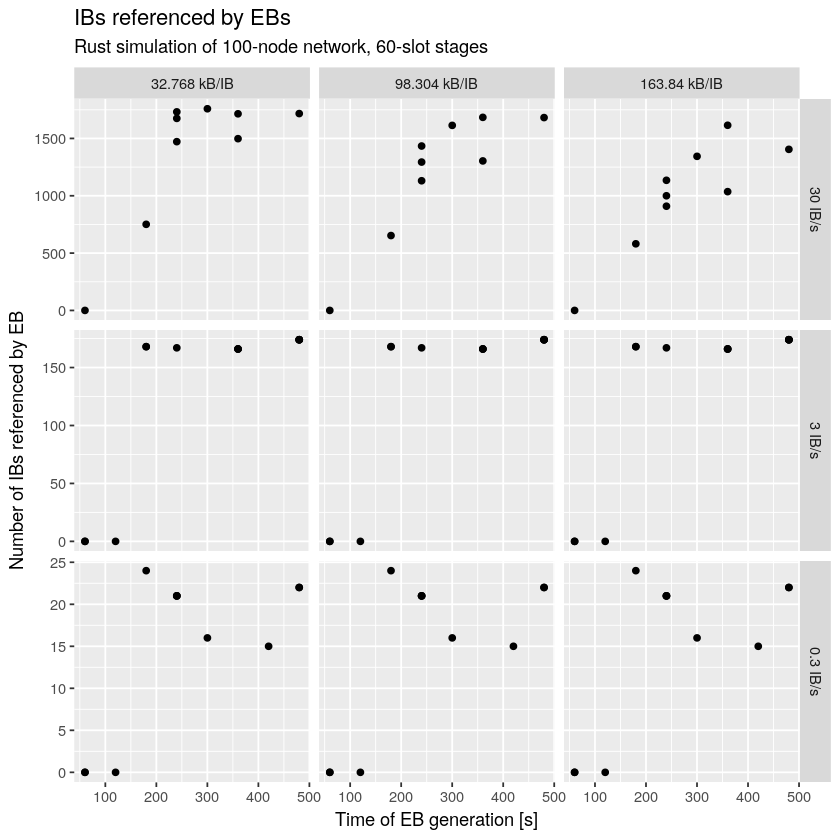

In [28]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Number of IBs referenced by EB`=`ib-count`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Number of IBs referenced by EB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ggtitle("IBs referenced by EBs", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/ibs-referenced-ebs-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### EB inclusion in RBs

##### Histogram

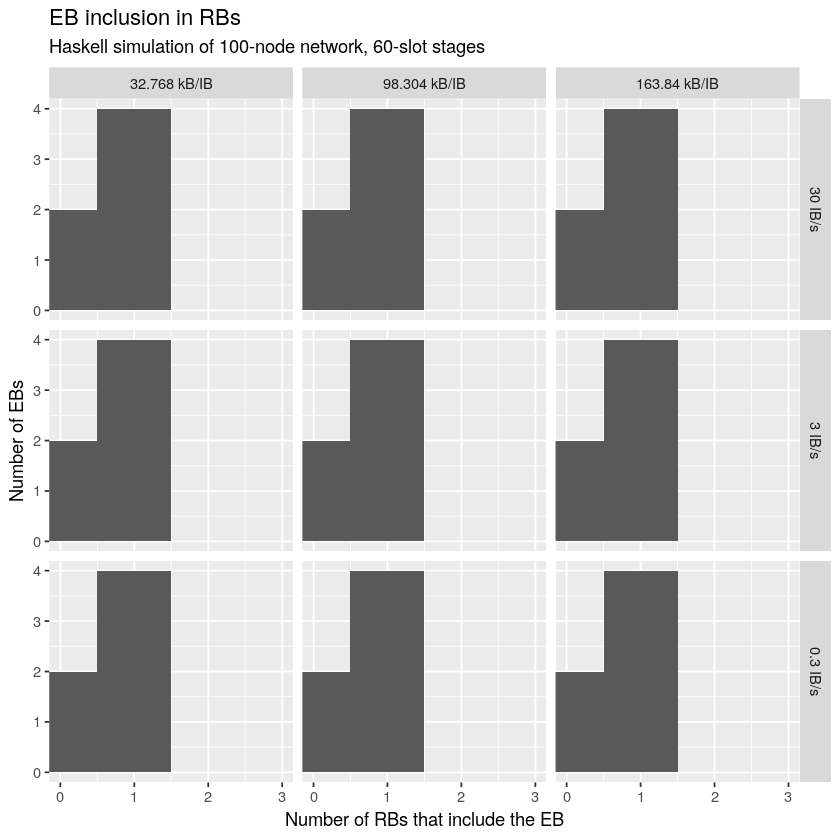

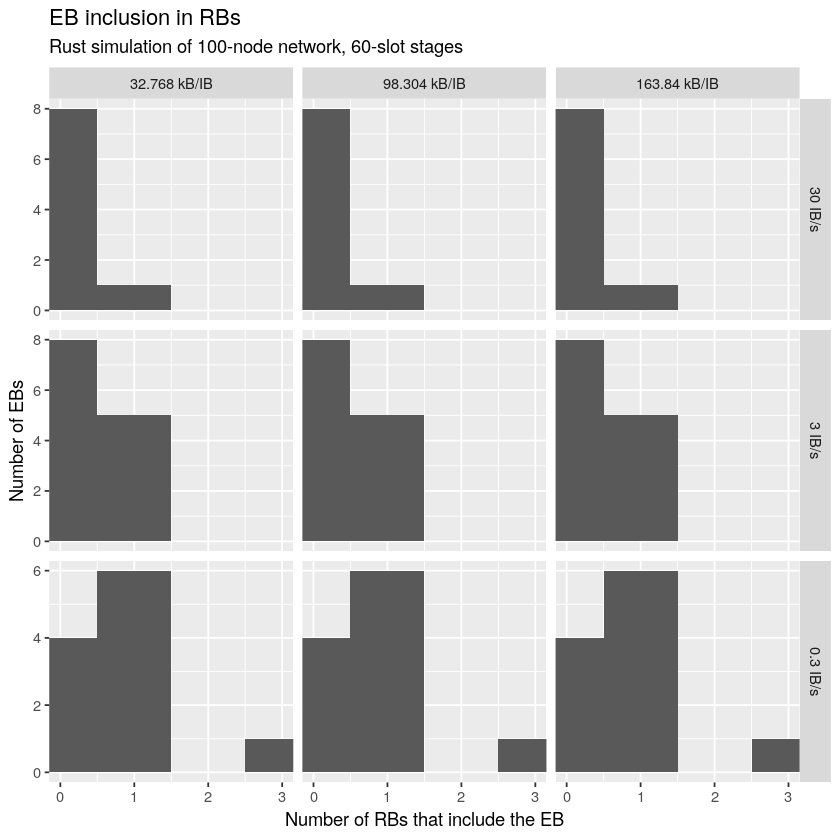

In [29]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of RBs that include the EB`=`rb-count`
        )
    ],
    aes(x=`Number of RBs that include the EB`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    coord_cartesian(xlim=c(0, 3)) +
    ylab("Number of EBs") +
    ggtitle("EB inclusion in RBs", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/eb-inclusion-rbs-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

##### Time series

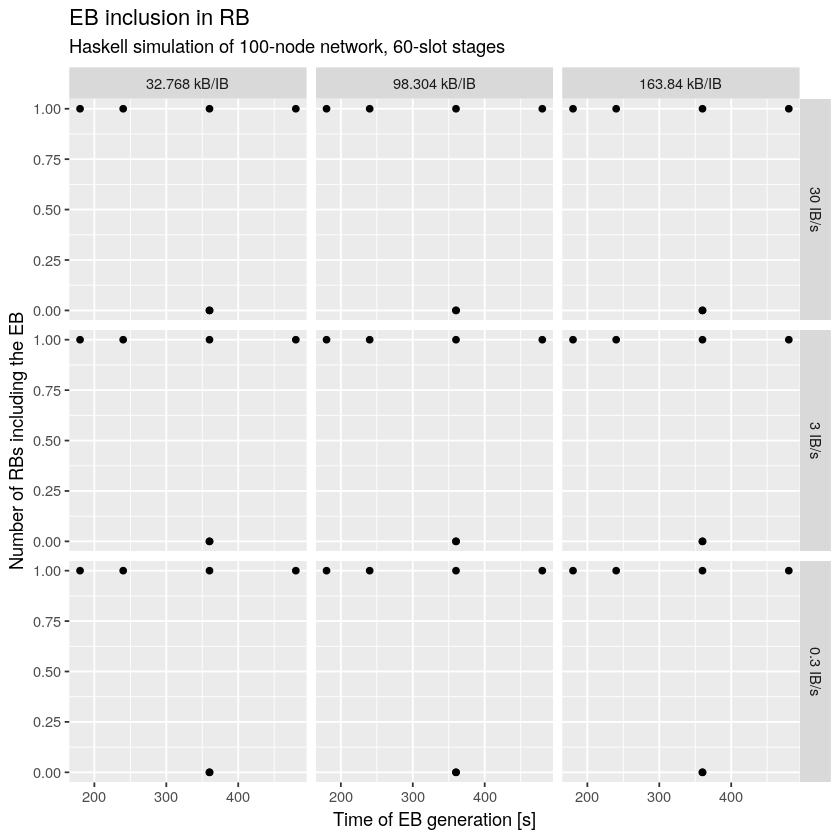

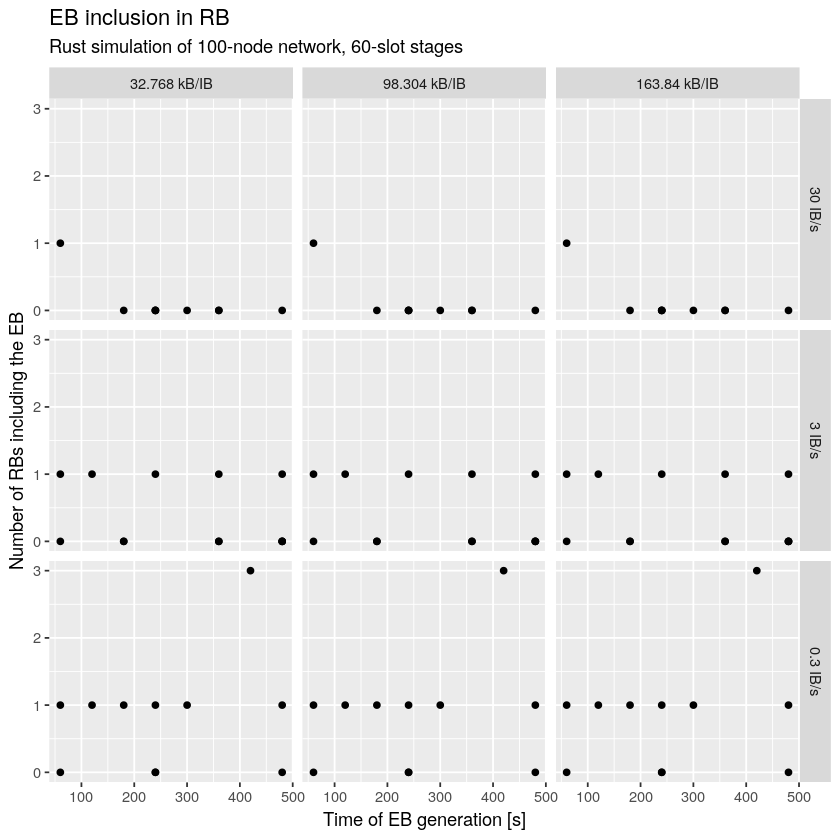

In [30]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Number of RBs including the EB`=`rb-count`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Number of RBs including the EB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB inclusion in RB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/eb-inclusion-rbs-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### Time of EB inclusion in an RB

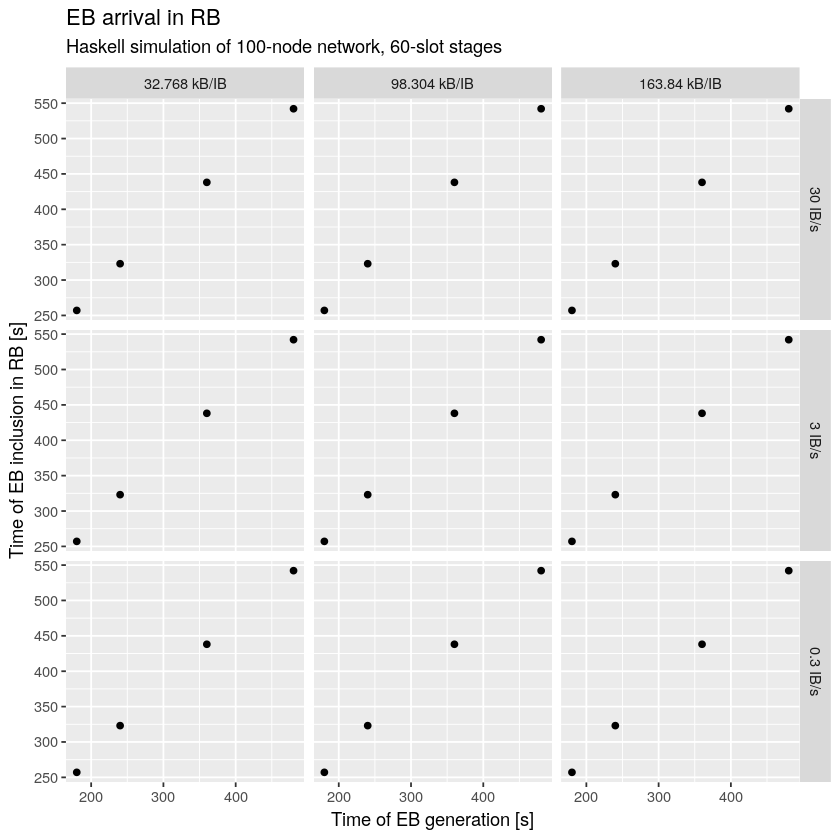

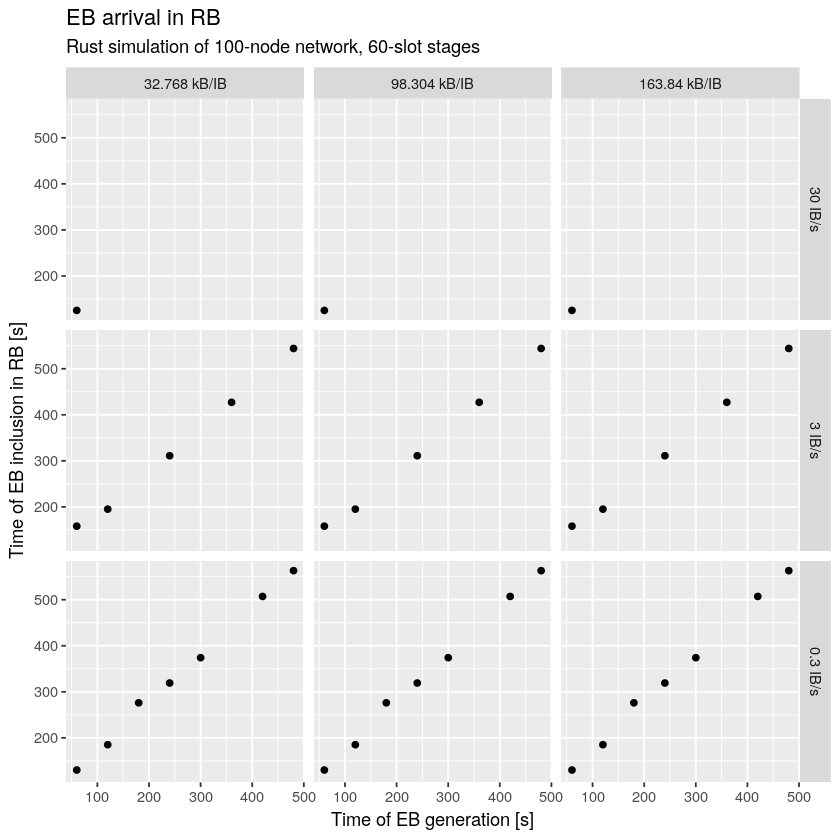

In [31]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & `rb-count` > 0 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Time of EB inclusion in RB [s]`=`rb-first`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Time of EB inclusion in RB [s]`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB arrival in RB", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/eb-arrival-rb-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### EB size

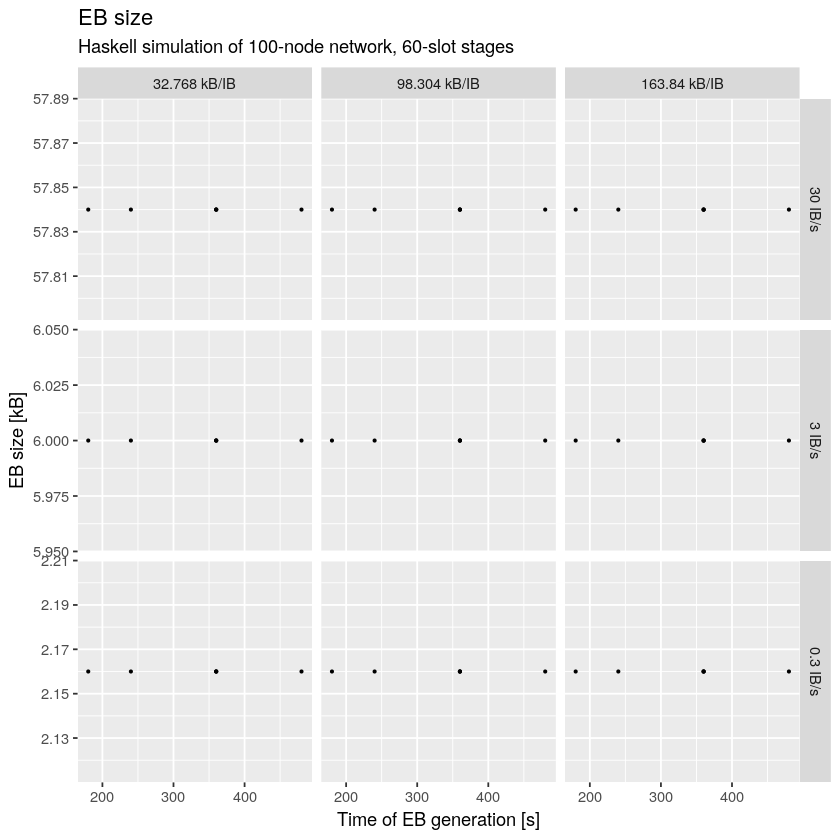

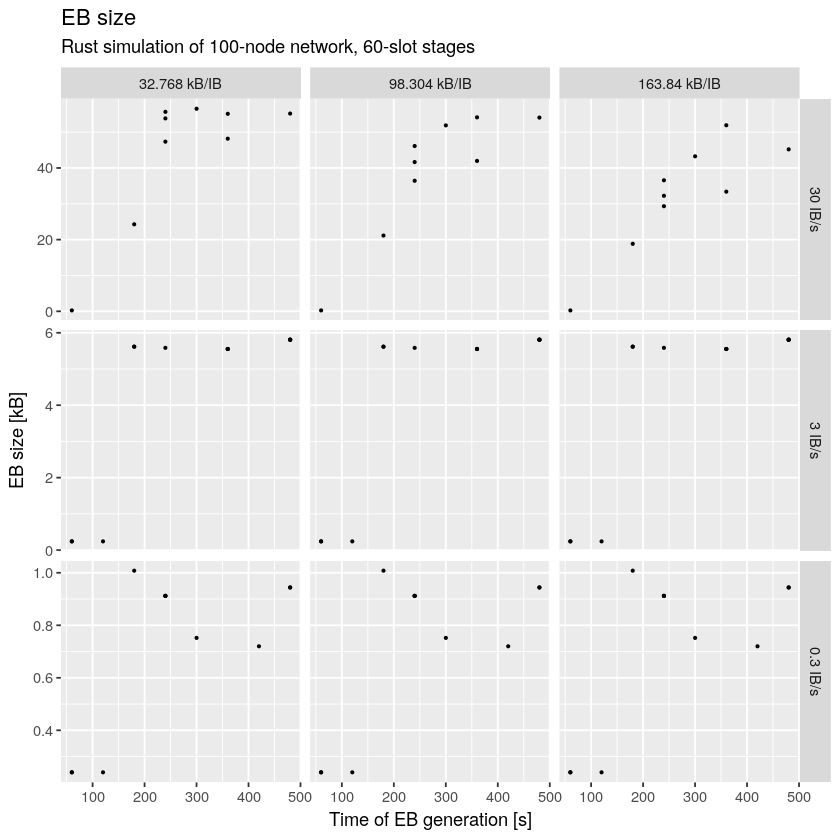

In [32]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `EB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`EB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ggtitle("EB size", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/eb-size-timeseries", s, ".png"), units="in", width=8, height=6, dpi=150)

}

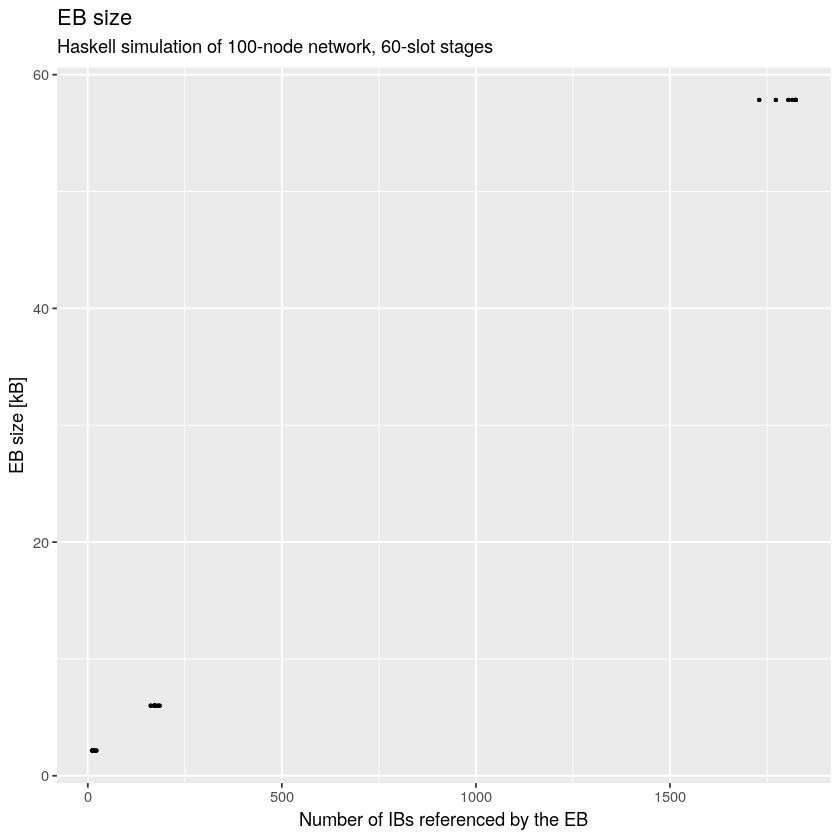

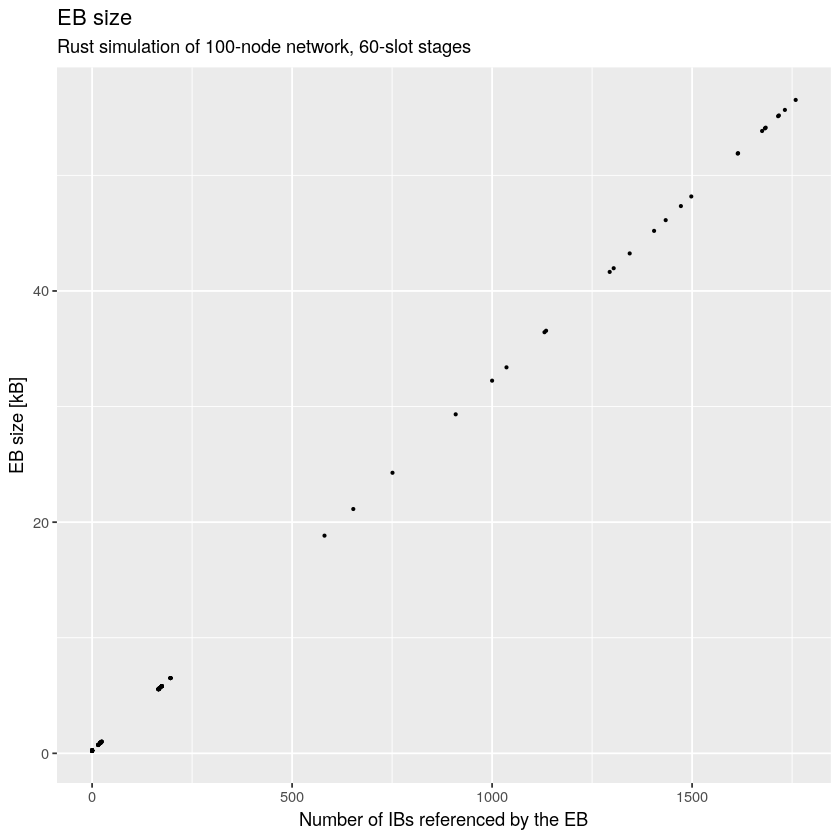

In [33]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of IBs referenced by the EB`=`ib-count`,
            `EB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Number of IBs referenced by the EB`, y=`EB size [kB]`)
) +
    geom_point(size=0.5) +
    #facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB size", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/eb-size-scatterplot-", s, ".png"), units="in", width=8, height=6, dpi=150)
 
}

### Ranking blocks

#### Read results

In [34]:
if (file.exists("results/rbgen.csv.gz")) {
    rbgen <- fread("results/rbgen.csv.gz", stringsAsFactors=TRUE)
} else {
    rbgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w12", collection="rbgen")$find(), stringsAsFactors=TRUE)
    fwrite(rbgen, "results/rbgen.csv")
}
rbgen %>% summary

   simulator        network        label     leios-stage-length-slots
 haskell:144   100-nodes:429   default:429   Min.   :60              
 rust   :285                                 1st Qu.:60              
                                             Median :60              
                                             Mean   :60              
                                             3rd Qu.:60              
                                             Max.   :60              
                                                                     
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 0.30             Min.   : 32768         Min.   :1.5              
 1st Qu.: 0.30             1st Qu.: 32768         1st Qu.:1.5              
 Median : 3.00             Median : 98304         Median :1.5              
 Mean   :12.16             Mean   : 98304         Mean   :1.5              
 3rd Qu.:30.00             3rd Qu.:163840         3rd Qu.:1.

#### EB inclusion in RBs

##### Histogram

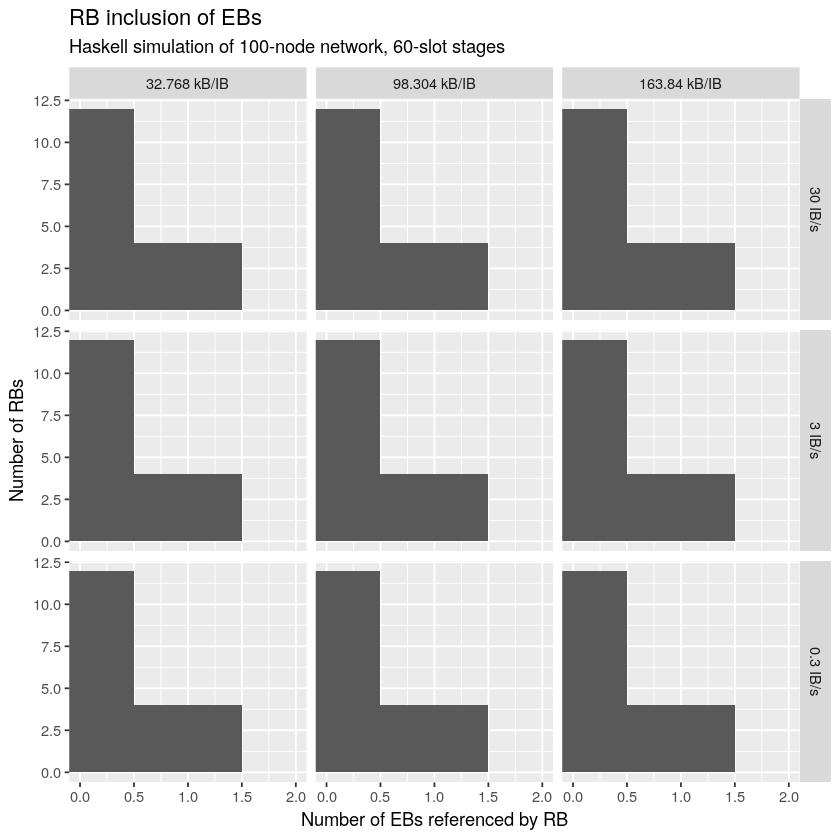

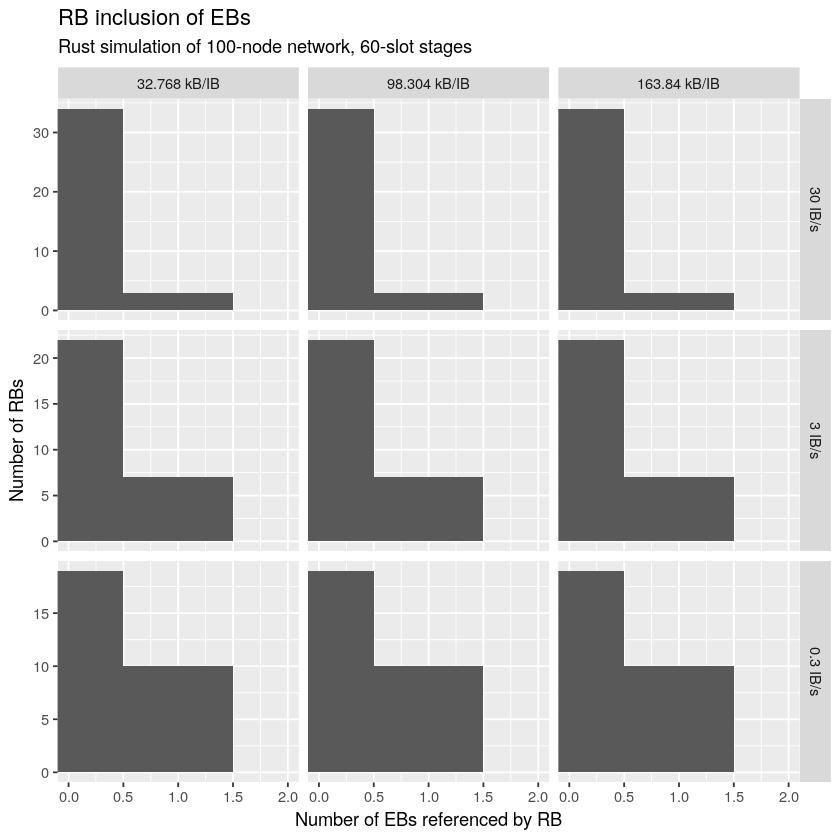

In [35]:
for (s in rbgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of EBs referenced by RB`=`eb-count`
        )
    ],
    aes(x=`Number of EBs referenced by RB`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    coord_cartesian(xlim=c(0, 2)) +
    ylab("Number of RBs") +
    ggtitle("RB inclusion of EBs", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/ebs-referenced-rb-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
    
}

##### Time series

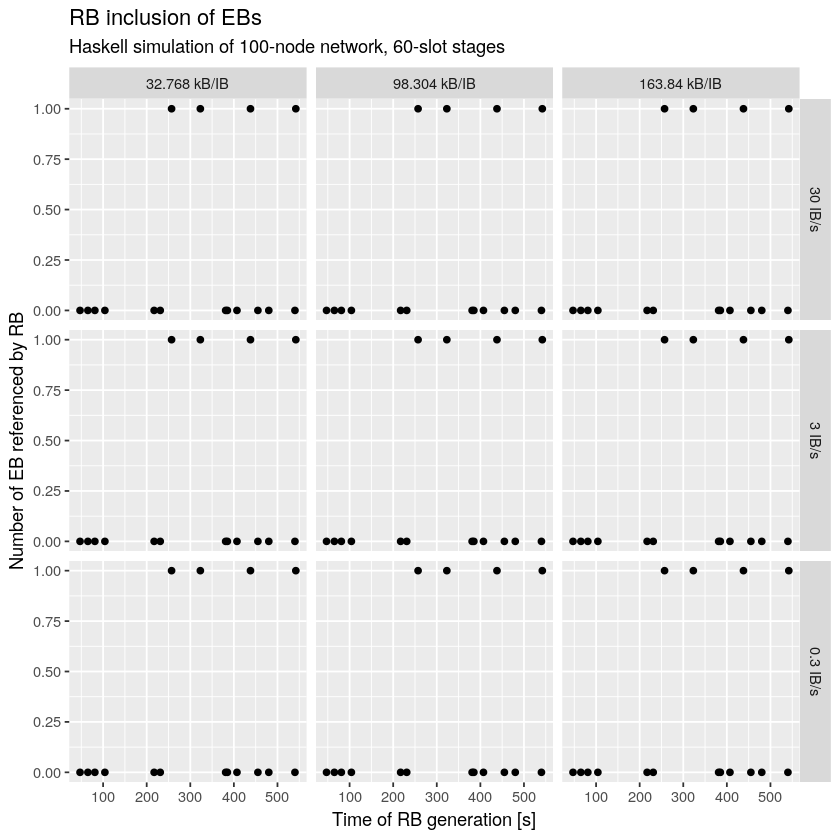

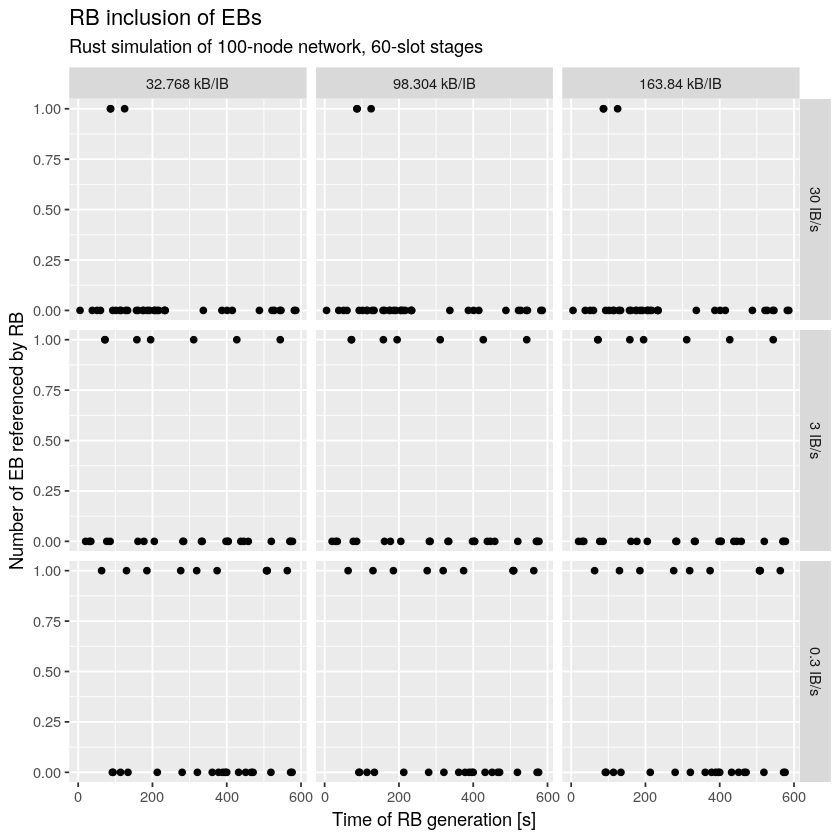

In [36]:
for (s in rbgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of RB generation [s]`=`time`,
            `Number of EB referenced by RB`=`eb-count`
        )
    ],
    aes(x=`Time of RB generation [s]`, y=`Number of EB referenced by RB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("RB inclusion of EBs", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/ebs-referenced-rb-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)
    
}

#### RB size

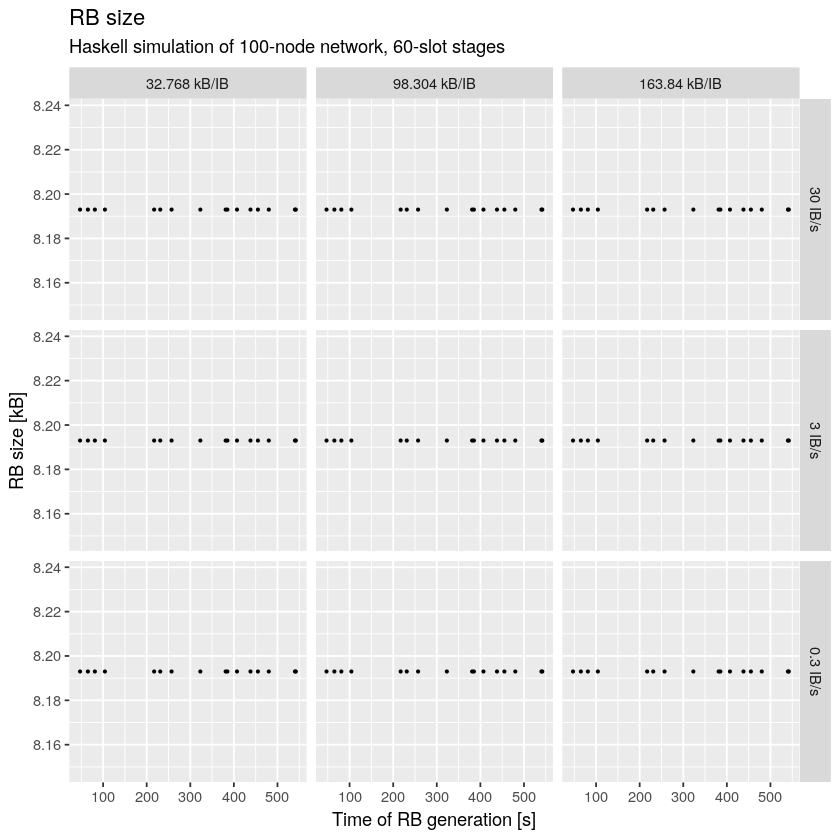

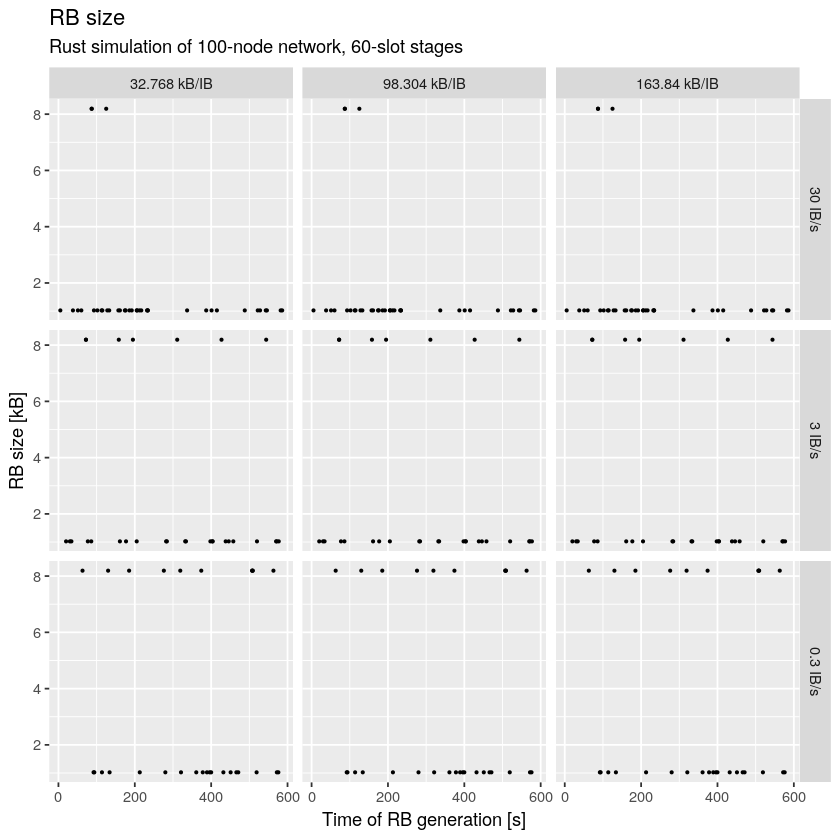

In [37]:
for (s in rbgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of RB generation [s]`=`time`,
            `RB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of RB generation [s]`, y=`RB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("RB size", subtitle=paste(s %>% str_to_title, "simulation of 100-node network, 60-slot stages"))
print(g)
ggsave(paste0("plots/rb-size-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
    
}

## Realistic network

### Receipt of messages

#### Read results

In [2]:
if (file.exists("../2025w12xl/results/receipts.csv.gz")) {
    receipts <- fread("../2025w12xl/results/receipts.csv.gz", stringsAsFactors=TRUE)
} else {
    receipts <- data.table(mongo(url="mongodb://thelio", db="leios2025w12xl", collection="receipts")$find(), stringsAsFactors=TRUE)
    fwrite(receipts, "../2025w12xl/results/receipts.csv")
}
receipts %>% summary

   simulator              network              label          
 haskell:110427170   realistic:298624973   default:298624973  
 rust   :188197803                                            
                                                              
                                                              
                                                              
                                                              
                                                              
 leios-stage-length-slots ib-generation-probability ib-body-avg-size-bytes
 Min.   :60               Min.   : 0.30             Min.   : 32768        
 1st Qu.:60               1st Qu.: 3.00             1st Qu.: 32768        
 Median :60               Median :30.00             Median : 98304        
 Mean   :60               Mean   :21.93             Mean   : 97057        
 3rd Qu.:60               3rd Qu.:30.00             3rd Qu.:163840        
 Max.   :60               Max.   :30.00       

#### Scenarios present in dataset

In [3]:
receipts[, .(`Records`=.N), by=.(`simulator`, `network`, `label`)]

simulator network   label   Records  
1 rust      realistic default 188197803
2 haskell   realistic default 110427170

#### IB rate vs IB size vs stage length

##### Compare the distributions of elapsed times

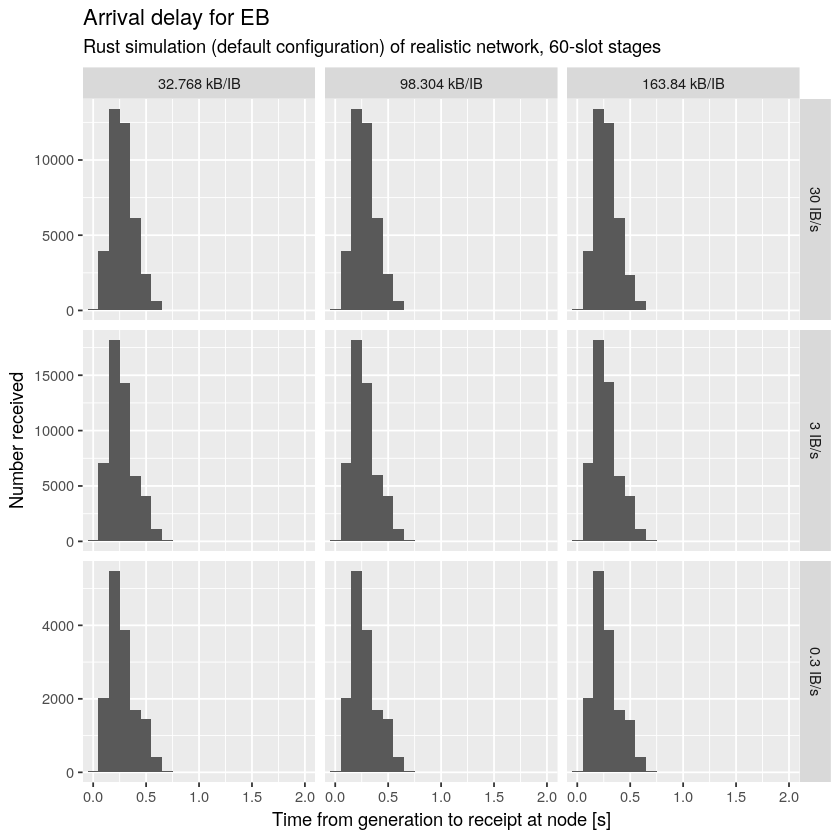

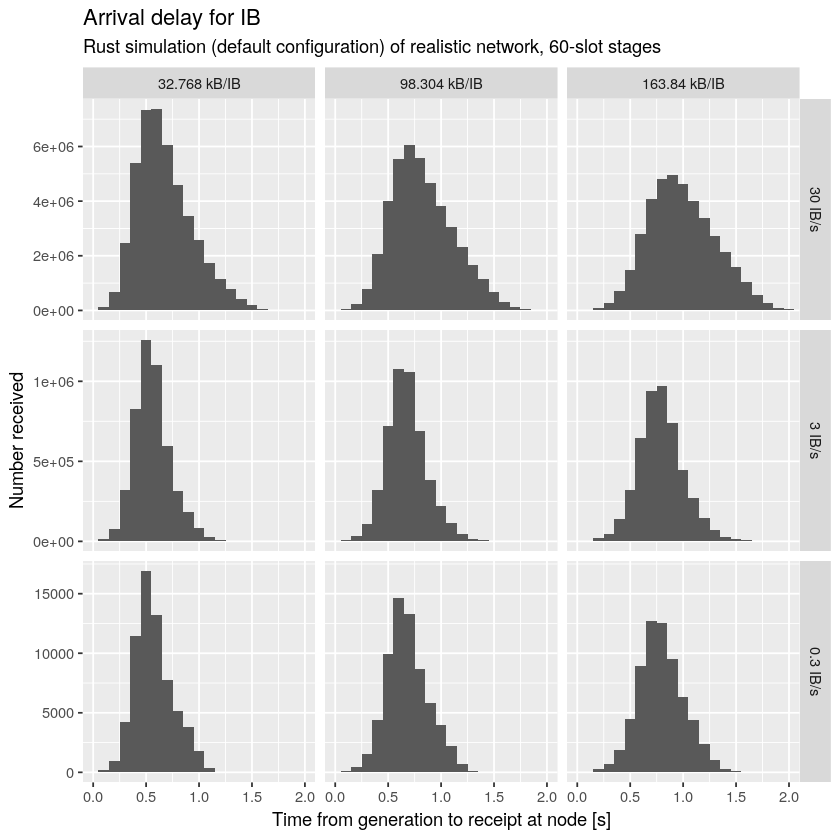

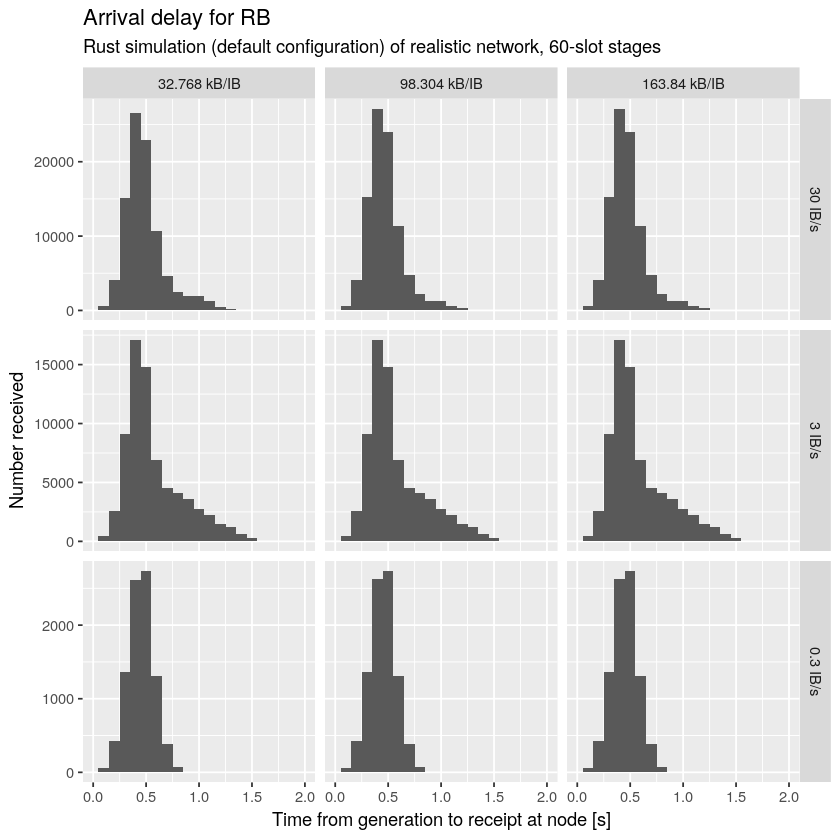

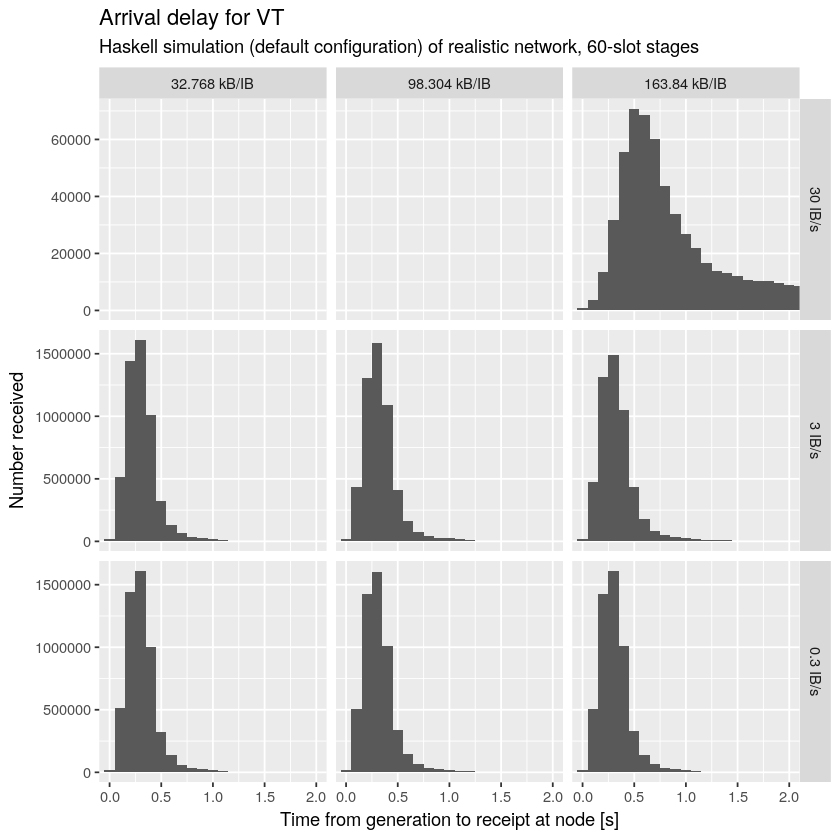

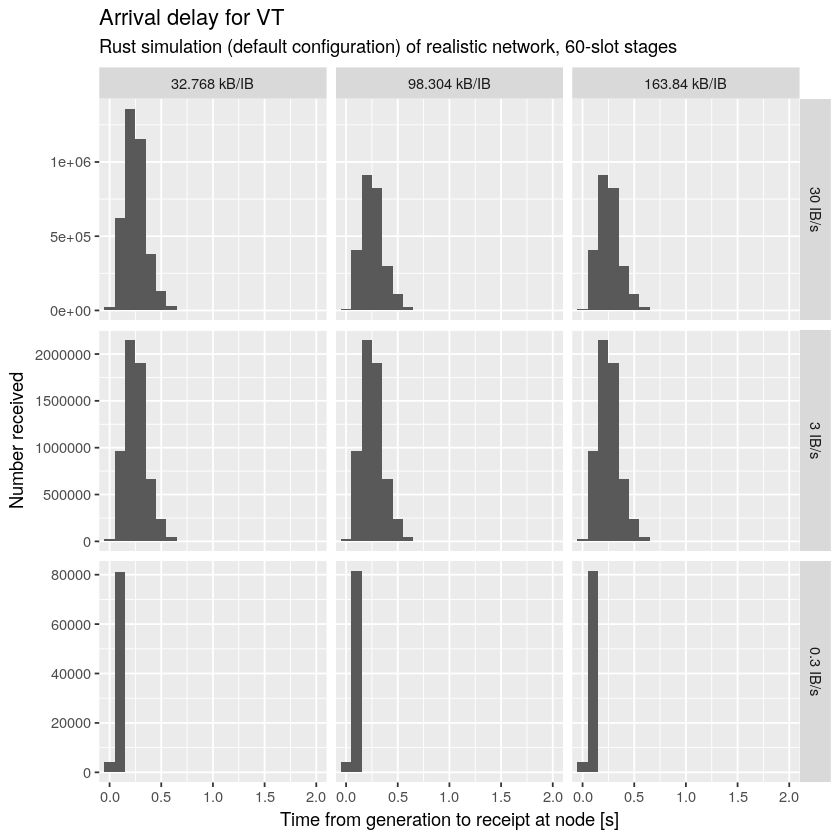

In [40]:
for (k in receipts[,unique(`kind`)%>%sort]) {
for (s in receipts[,unique(`simulator`)%>%sort]) {
for (l in c("default", "unoptimized")) {
    if (receipts[`simulator` == s & `label` == l & `kind` == k & !is.na(`received`) &`sent` <= 540, .N] == 0)
        next
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == l & `kind` == k & !is.na(`received`) &`sent` <= 540,
            .(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `elapsed`
            )
        ],
        aes(x=`elapsed`)
    ) +
        geom_histogram(binwidth=0.1) +
        facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
        coord_cartesian(xlim=c(0, 2)) +
        xlab("Time from generation to receipt at node [s]") +
        ylab("Number received") +
        ggtitle(paste("Arrival delay for", k), subtitle=paste0(s %>% str_to_title, " simulation (", l, " configuration) of realistic network, 60-slot stages"))
    print(g)
    ggsave(paste0("../2025w12xl/plots/elapsed-", k, "-", l, "-", s, ".png"), units="in", width=8, height=6, dpi=150)
    ggsave(paste0("../2025w12xl/plots/elapsed-", k, "-", l, "-", s, "-slide.png"), units="in", width=4.75, height=2.00, dpi=150)
}
}
}

#### Fraction of items arriving

In [4]:
arrival <- receipts[
    `label` == "default" & !is.na(`received`) & `sent` <= 540,
    .(`received`=as.numeric(.N)),
    by=.(`simulator`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`, `item`)
][,
    .(`total`=as.numeric(.N), `received`=sum(`received`)),
    by=.(`simulator`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`)
][,
    .(`received`=sum(`received`)/sum(`total`)),
    by=.(`simulator`, `label`, `ib-generation-probability`, `ib-body-avg-size-bytes`, `kind`, `sent`)
]

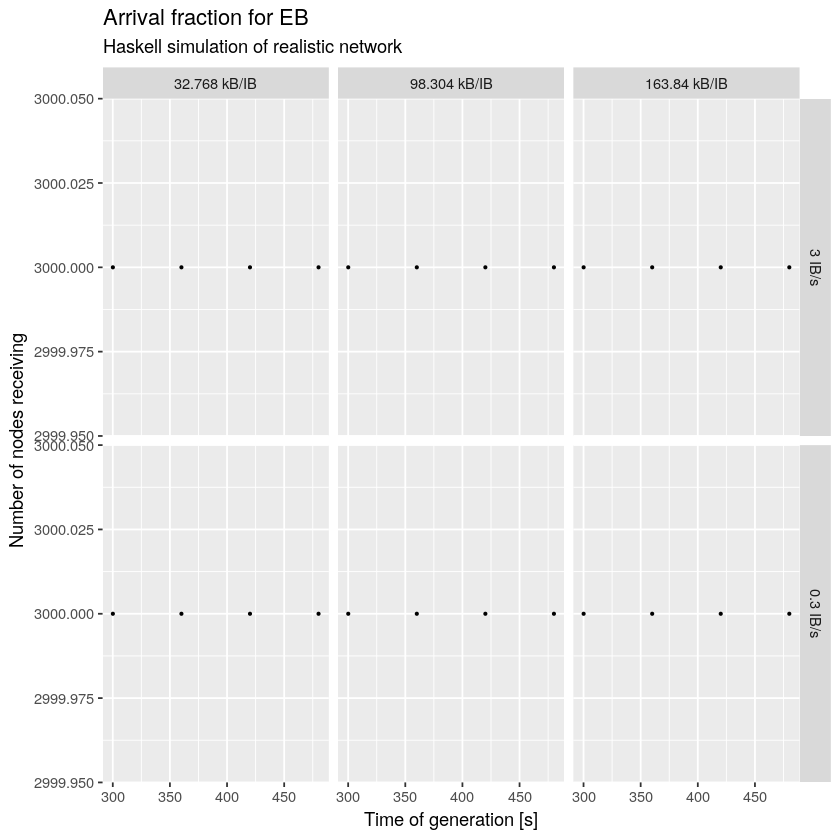

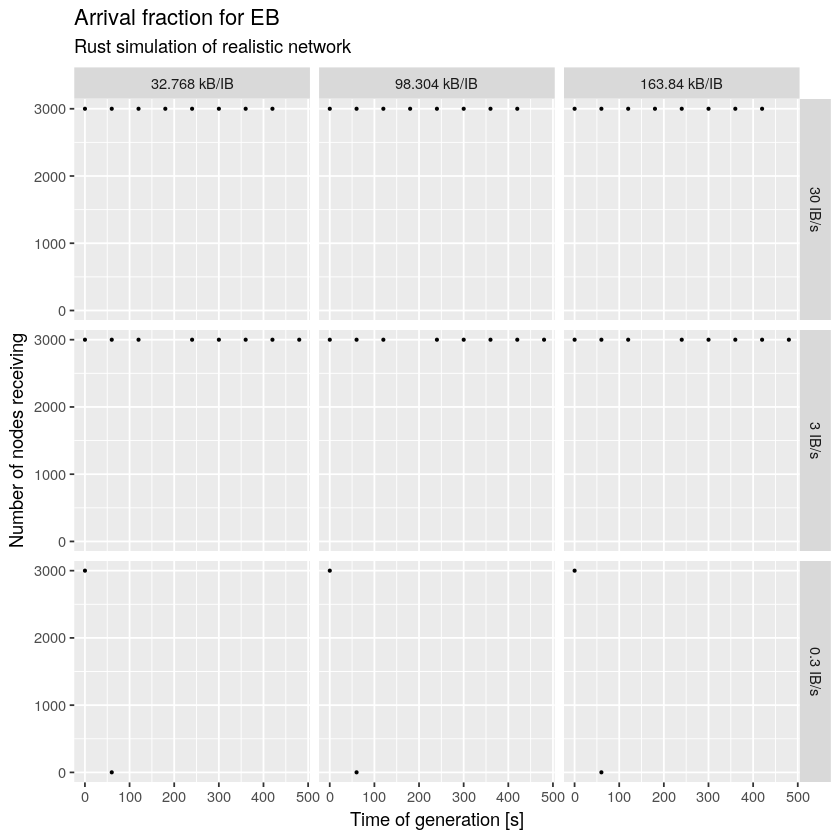

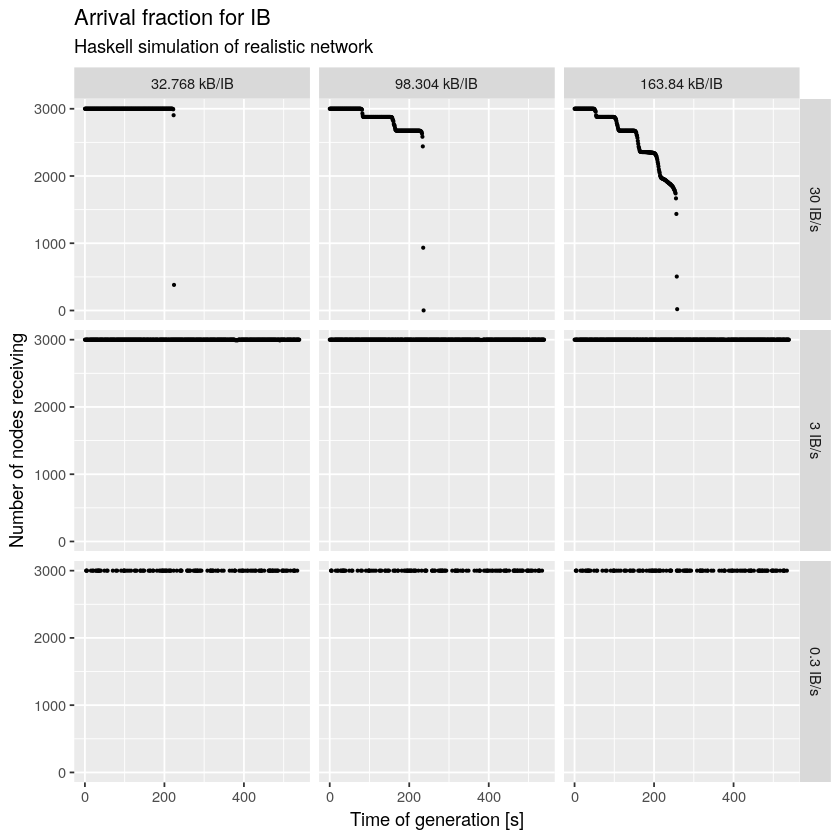

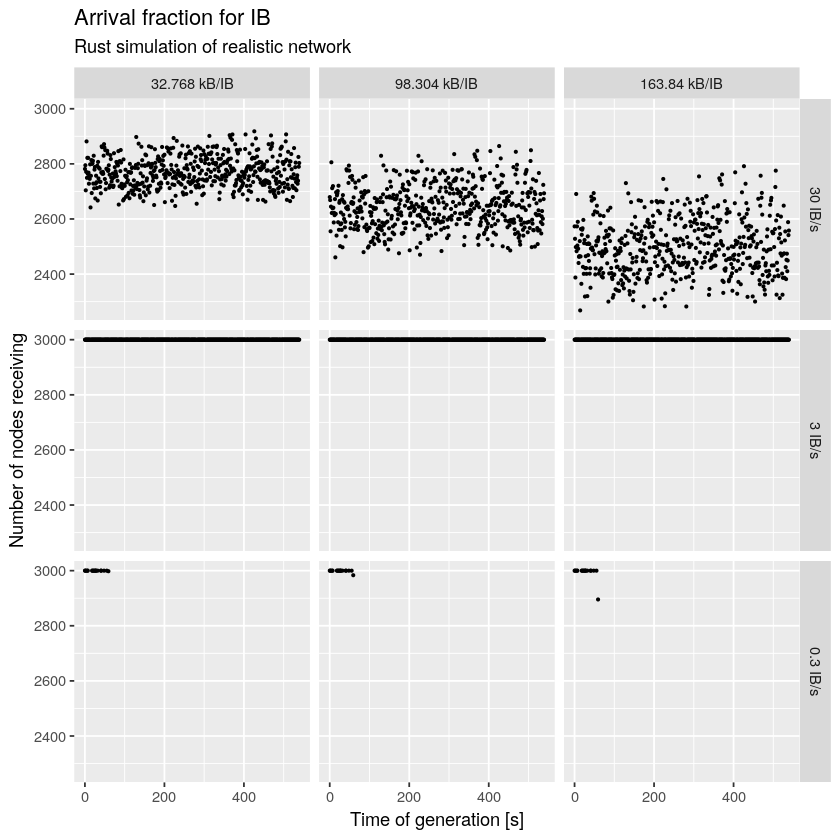

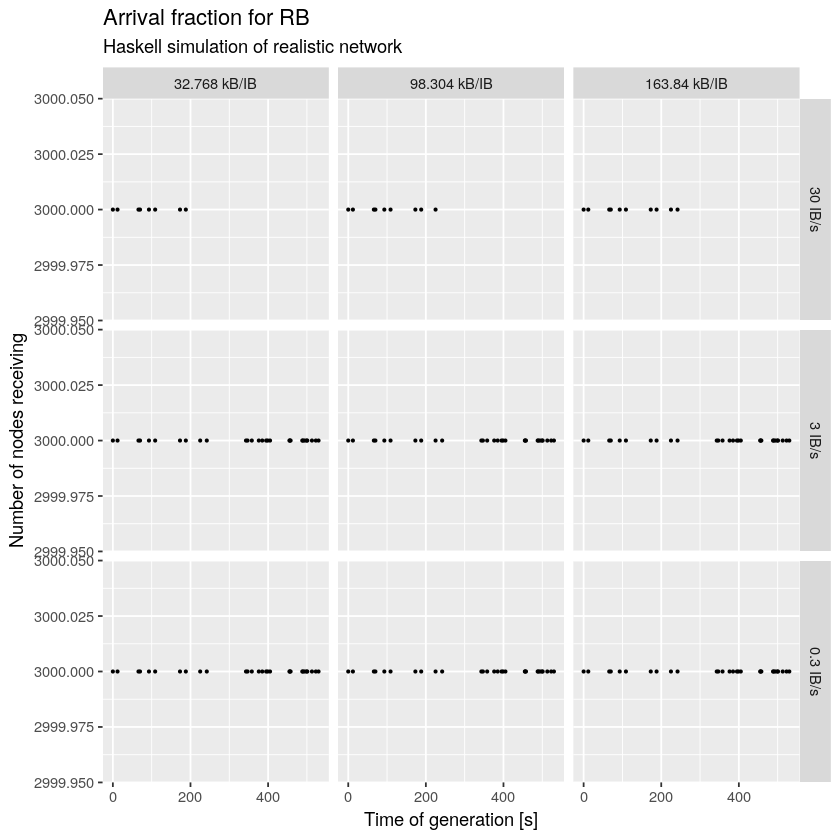

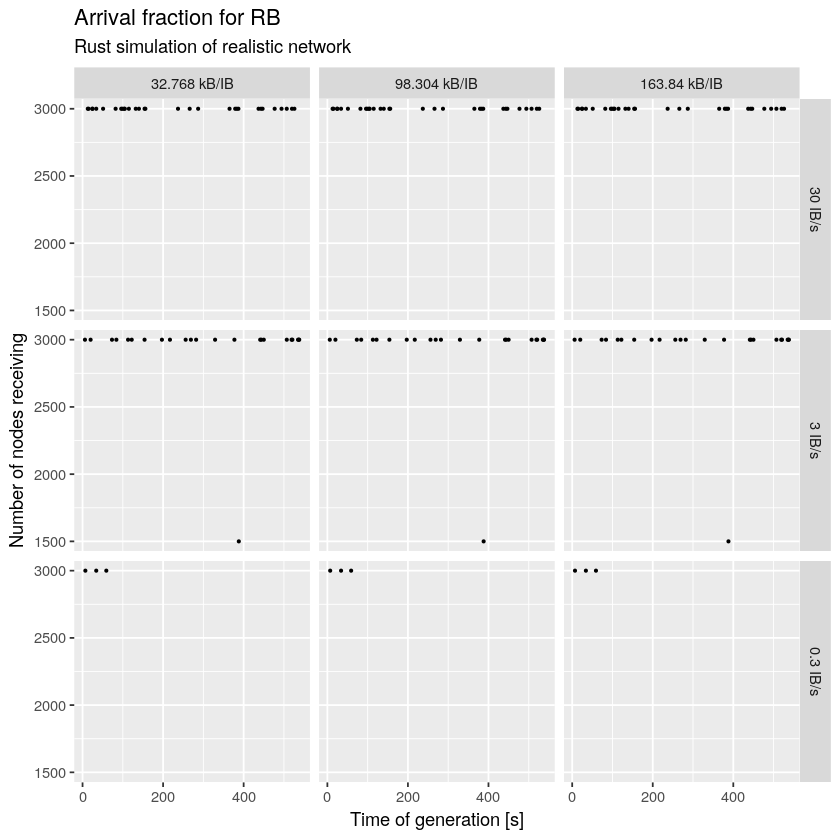

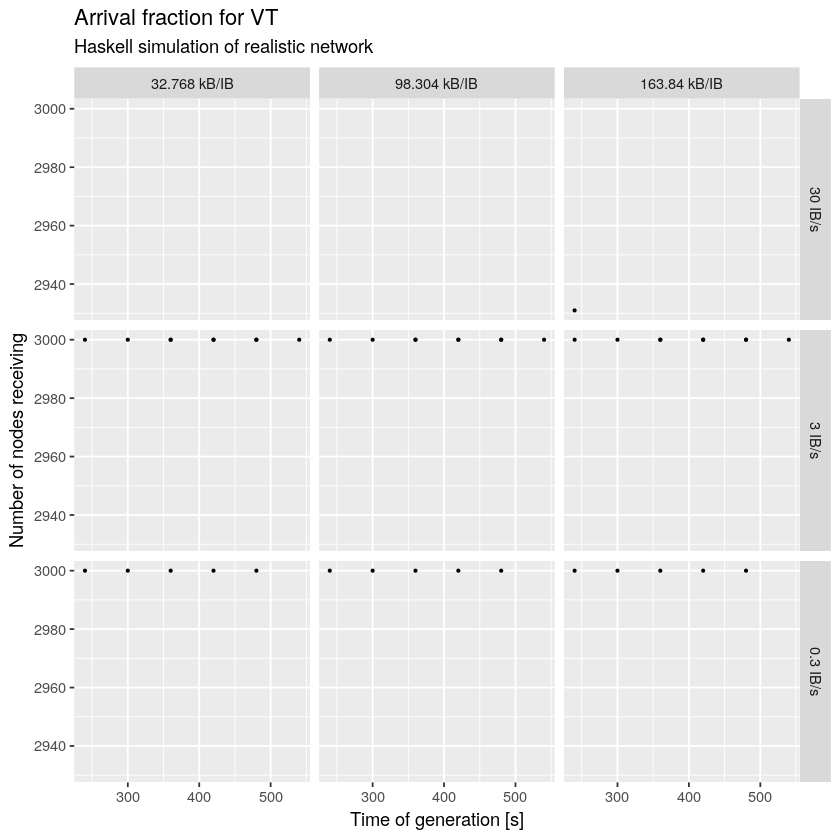

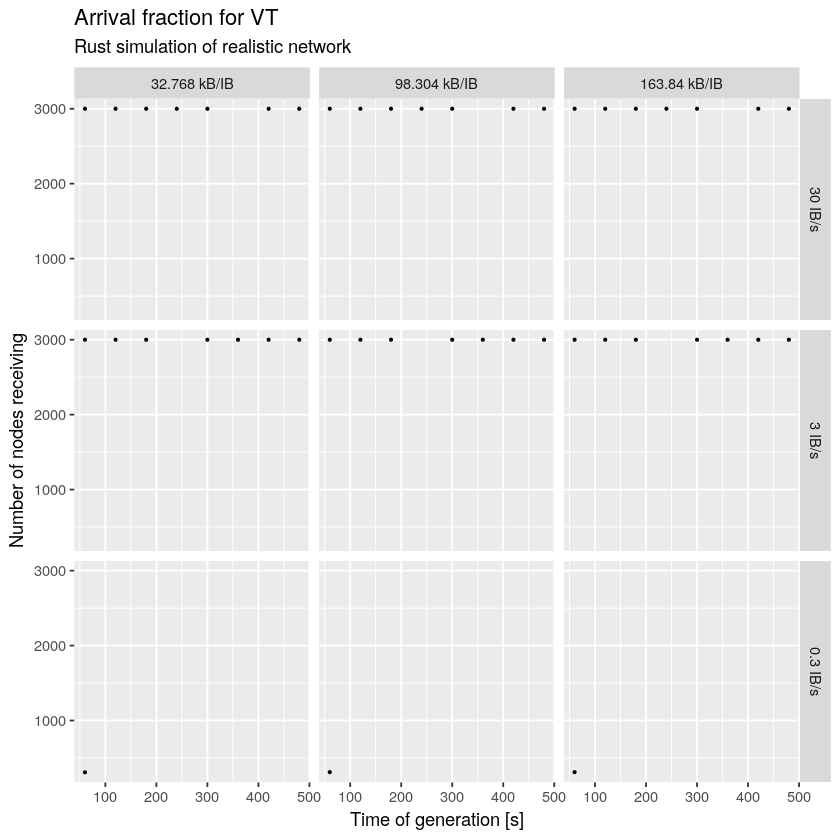

In [5]:
for (k in arrival[,unique(`kind`)%>%sort]) {
for (s in arrival[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        arrival[
            `simulator` == s & `kind` == k,
            .(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `sent`,
                `received`
            )
        ], 
        aes(x=`sent`, y=`received`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate`  ~ `ibSize`) +
        xlab("Time of generation [s]") +
        ylab("Number of nodes receiving") +
        ggtitle(paste("Arrival fraction for", k), subtitle=paste(s %>% str_to_title, "simulation of realistic network"))
    print(g)
    ggsave(paste0("../2025w12xl/plots/arrival-", k, "-", s, ".png"), units="in", width=8, height=6, dpi=150)
    ggsave(paste0("../2025w12xl/plots/arrival-", k, "-", s, "-slide.png"), units="in", width=4.75, height=4.00, dpi=150)
}
}

#### Bandwidth usage

##### Total network bandwidth

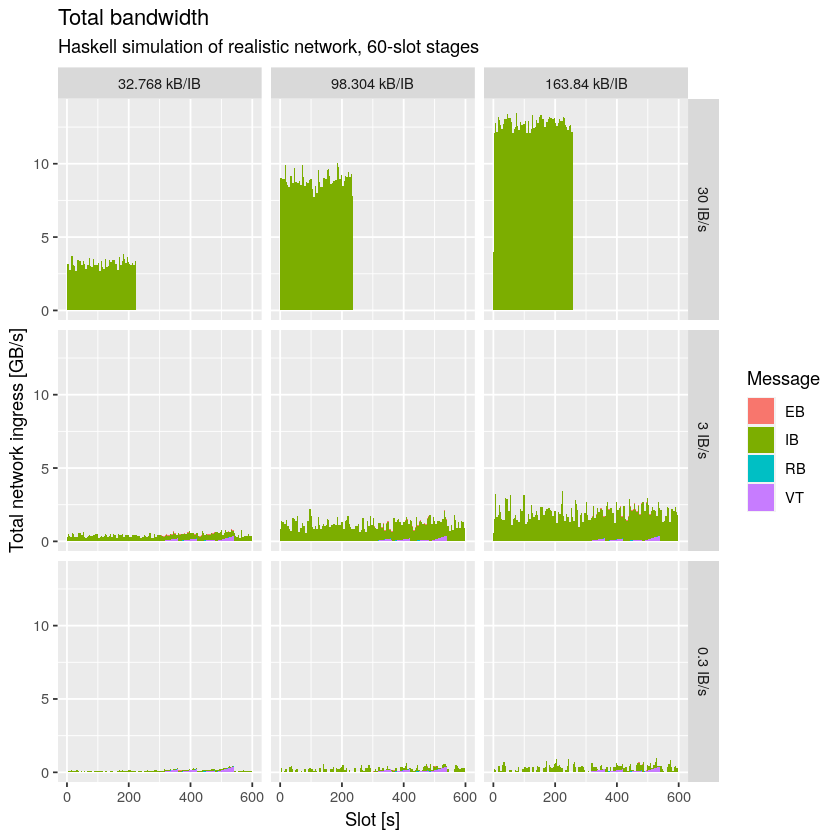

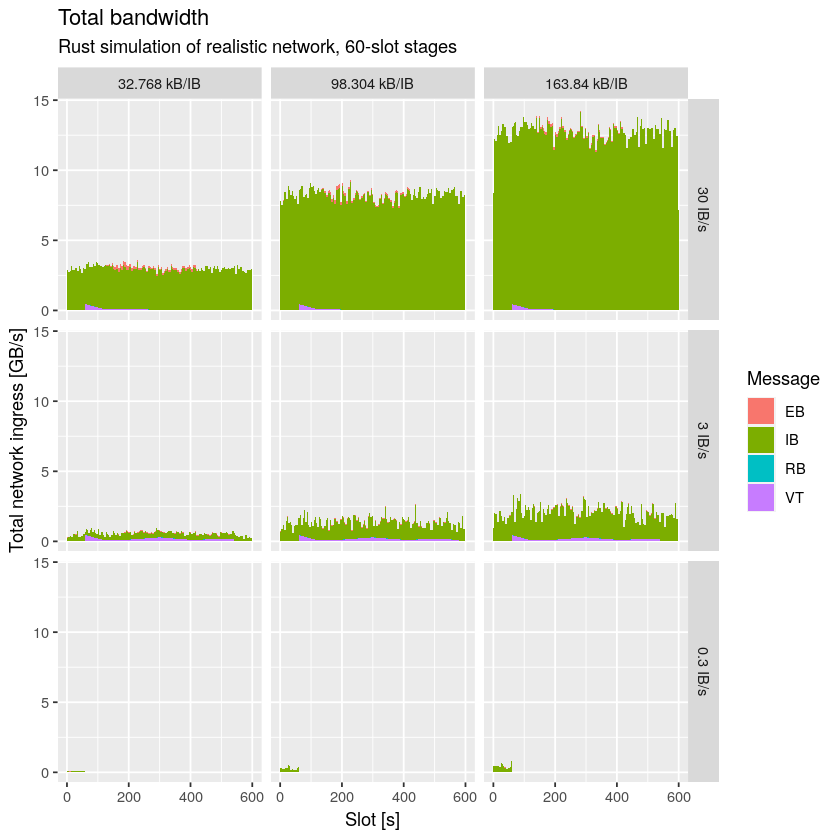

In [6]:
for (s in receipts[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == "default" & !is.na(`received`),
            .(
                `size`=sum(`size`)/1000000000
            ),
            by=.(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`ibRate` ~ `ibSize`) +
        xlab("Slot [s]") +
        ylab("Total network ingress [GB/s]") +
        ggtitle("Total bandwidth", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
    print(g)
    ggsave(paste0("../2025w12xl/plots/ingress-total-area-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

In [10]:
receipts[`simulator` == "haskell" & `label` == "default" & !is.na(`received`)] %>% summary

   simulator              network              label          
 haskell:110427161   realistic:110427161   default:110427161  
 rust   :        0                                            
                                                              
                                                              
                                                              
                                                              
                                                              
 leios-stage-length-slots ib-generation-probability ib-body-avg-size-bytes
 Min.   :60               Min.   : 0.30             Min.   : 32768        
 1st Qu.:60               1st Qu.: 3.00             1st Qu.: 32768        
 Median :60               Median :30.00             Median : 98304        
 Mean   :60               Mean   :17.38             Mean   : 98594        
 3rd Qu.:60               3rd Qu.:30.00             3rd Qu.:163840        
 Max.   :60               Max.   :30.00       

In [11]:
receipts[`simulator` == "rust" & `label` == "default" & !is.na(`received`)] %>% summary

   simulator              network              label          
 haskell:        0   realistic:188197803   default:188197803  
 rust   :188197803                                            
                                                              
                                                              
                                                              
                                                              
                                                              
 leios-stage-length-slots ib-generation-probability ib-body-avg-size-bytes
 Min.   :60               Min.   : 0.30             Min.   : 32768        
 1st Qu.:60               1st Qu.:30.00             1st Qu.: 32768        
 Median :60               Median :30.00             Median : 98304        
 Mean   :60               Mean   :24.61             Mean   : 96156        
 3rd Qu.:60               3rd Qu.:30.00             3rd Qu.:163840        
 Max.   :60               Max.   :30.00       

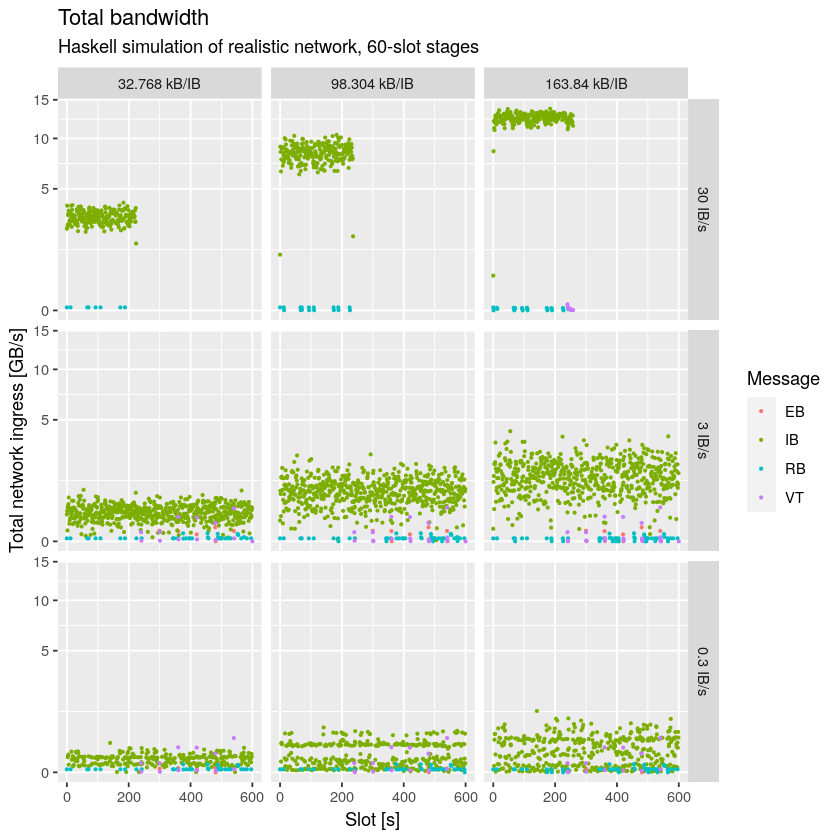

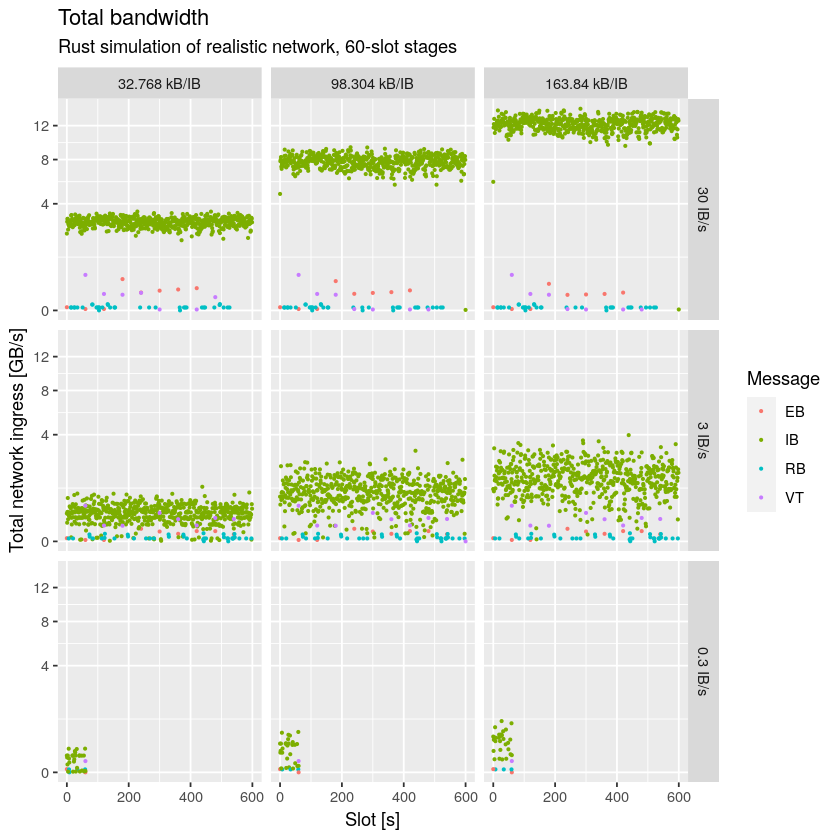

In [14]:
for (s in receipts[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == "default" & !is.na(`received`),
            .(
                `size`=sum(`size`)/1000000000
            ),
            by=.(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `ibSize`) +
        scale_y_sqrt() + #limits=c(0, 0.8)) +
        xlab("Slot [s]") +
        ylab("Total network ingress [GB/s]") +
        ggtitle("Total bandwidth", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
    print(g)
    ggsave(paste0("../2025w12xl/plots/ingress-total-point-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

##### Bandwidth usage per node

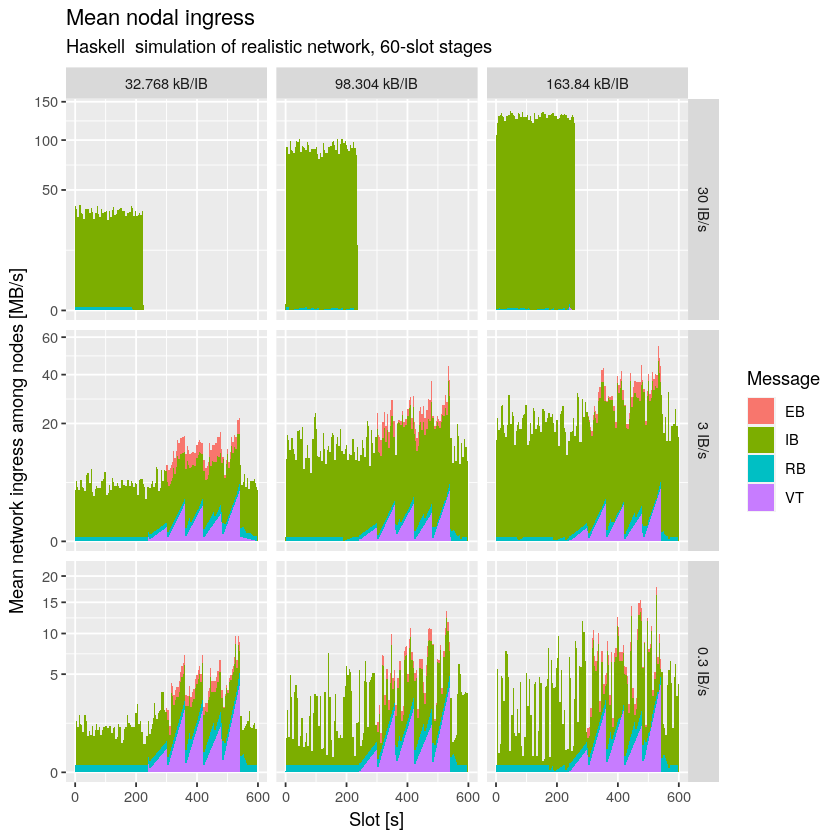

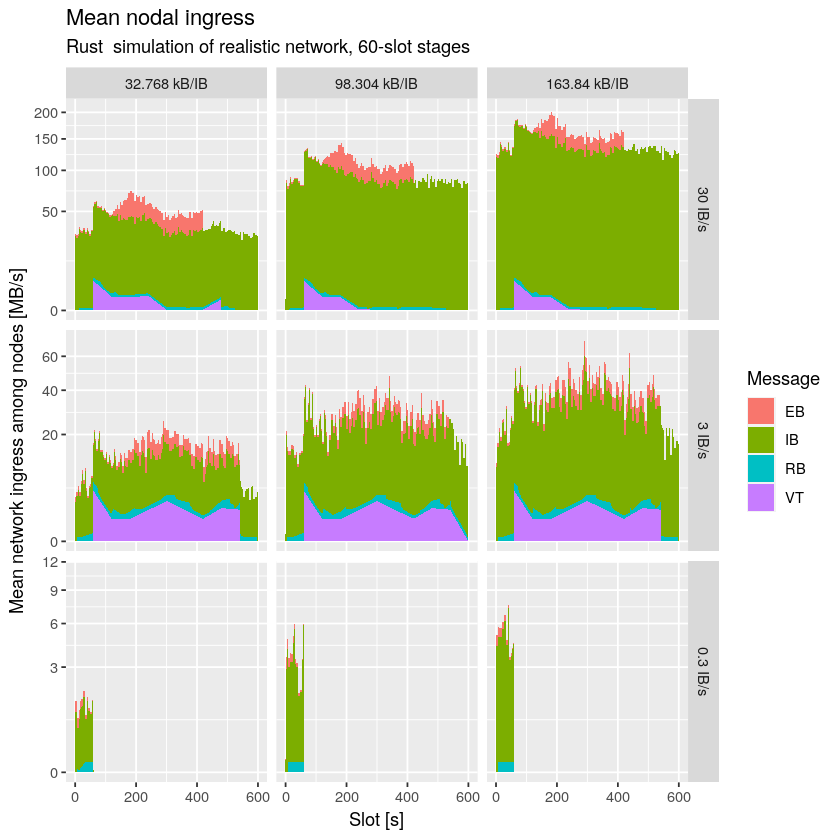

In [8]:
for (s in receipts[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == "default" & !is.na(`received`),
            .(
                `size`=sum(`size`)/1000000 / 100
            ),
            by=.(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `slot`=floor(`received`),
                `Message`=`kind`
            )
        ],
        aes(x=`slot`, y=`size`, fill=`Message`)
    ) +
        geom_area() +
        facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
        scale_y_sqrt() +
        xlab("Slot [s]") +
        ylab("Mean network ingress among nodes [MB/s]") +
        ggtitle("Mean nodal ingress", subtitle=paste(s %>% str_to_title, " simulation of realistic network, 60-slot stages"))
    print(g)
    ggsave(paste0("../2025w12xl/plots/ingress-average-area-", s, ".png"), units="in", width=8, height=6, dpi=150)
    ggsave(paste0("../2025w12xl/plots/ingress-average-area-", s, "-slide.png"), units="in", width=8.90, height=4.00, dpi=150)
}

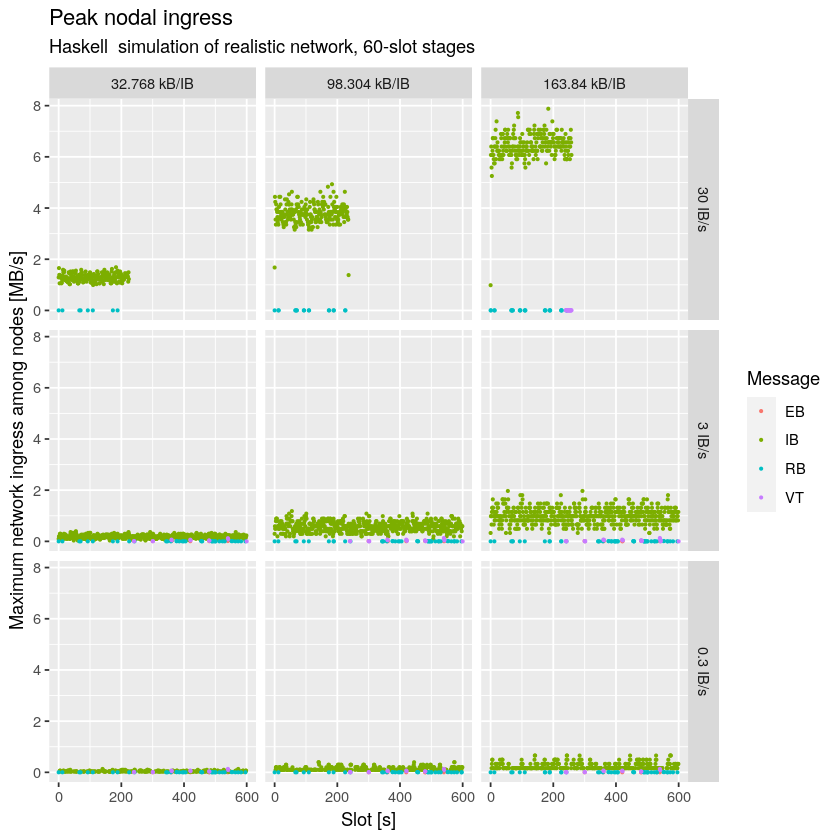

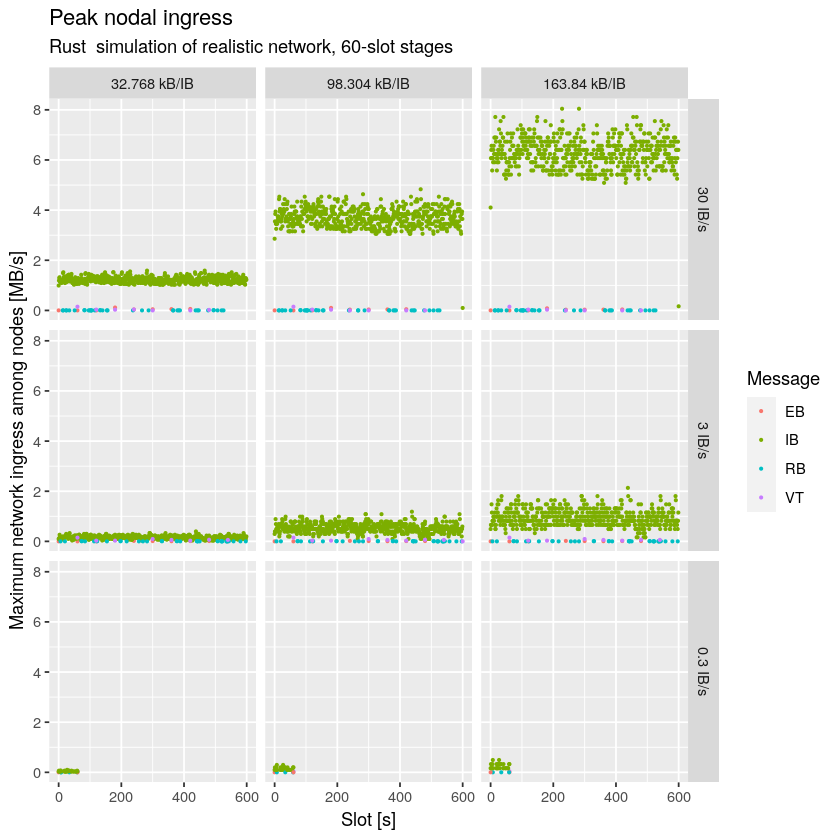

In [9]:
for (s in receipts[,unique(`simulator`)%>%sort]) {
    g <- ggplot(
        receipts[
            `simulator` == s & `label` == "default" & !is.na(`received`),
            .(
                `size`=sum(`size`)/1000000
            ),
            by=.(
                `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(receipts[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
                `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(receipts[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
                `slot`=floor(`received`),
                `Message`=`kind`,
                `recipient`
            )
        ][,
            .(`size`=max(`size`)),
            by=.(`ibRate`, `ibSize`, `slot`, `Message`)
        ],
        aes(x=`slot`, y=`size`, color=`Message`)
    ) +
        geom_point(size=0.5) +
        facet_grid(`ibRate` ~ `ibSize`) +
        xlab("Slot [s]") +
        ylab("Maximum network ingress among nodes [MB/s]") +
        ggtitle("Peak nodal ingress", subtitle=paste(s %>% str_to_title, " simulation of realistic network, 60-slot stages"))
    print(g)
    ggsave(paste0("../2025w12xl/plots/ingress-peak-point-", s, ".png"), units="in", width=8, height=6, dpi=150)
}

### CPU usage

#### Read results

In [49]:
if (file.exists("../2025w12xl/results/cpus.csv.gz")) {
    cpus <- fread("../2025w12xl/results/cpus.csv.gz", stringsAsFactors=TRUE)
} else {
    cpus <- data.table(mongo(url="mongodb://thelio", db="leios2025w12xl", collection="cpus")$find(), stringsAsFactors=TRUE)
    fwrite(cpus, "../2025w12xl/results/cpus.csv")
}
cpus %>% summary

   simulator             network         leios-stage-length-slots
 haskell:19799489   realistic:44706728   Min.   :60              
 rust   :24907239                        1st Qu.:60              
                                         Median :60              
                                         Mean   :60              
                                         3rd Qu.:60              
                                         Max.   :60              
                                                                 
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 0.30             Min.   : 32768         Min.   :1.5              
 1st Qu.: 3.00             1st Qu.: 32768         1st Qu.:1.5              
 Median : 3.00             Median : 98304         Median :1.5              
 Mean   :11.98             Mean   : 98501         Mean   :1.5              
 3rd Qu.:30.00             3rd Qu.:163840         3rd Qu.:1.5              
 Max.   :30.00  

In [50]:
cpusNode <-
cpus[
    `slot` >= 60 & `slot` <= 540,
    .(
        `duration`=sum(`duration`)
    ),
    by=.(
        `simulator`,
        `ib-generation-probability`,
        `ib-body-avg-size-bytes`,
        `leios-stage-length-slots`,
        `node`,
        `slot`
    )
]

#### Peak CPU usage

##### Histogram

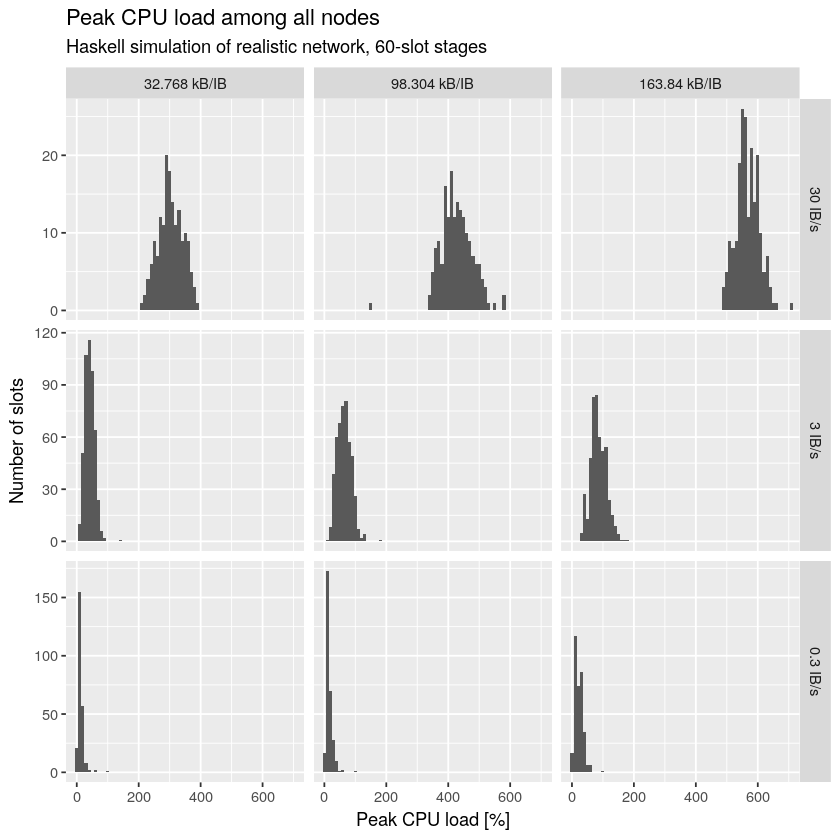

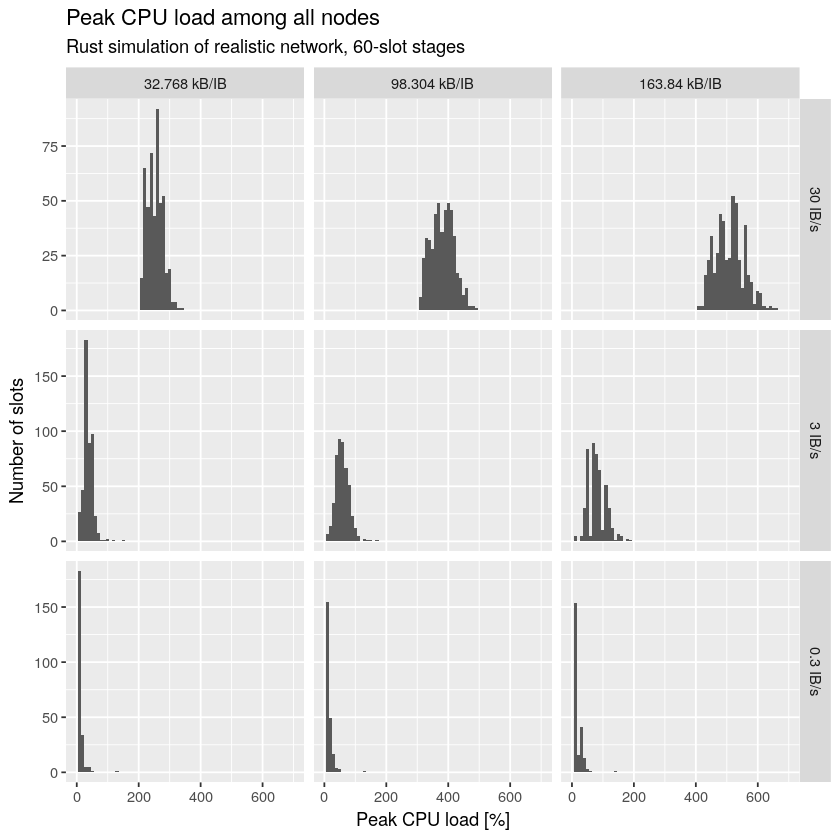

In [51]:
for (s in cpusNode[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    cpusNode[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*max(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`
        )
    ], 
    aes(x=`duration`)) +
    geom_histogram(binwidth=10) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    coord_cartesian(xlim=c(0, 700)) +
    xlab("Peak CPU load [%]") +
    ylab("Number of slots") +
    ggtitle("Peak CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/cpu-peak-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
    
}

##### Time series

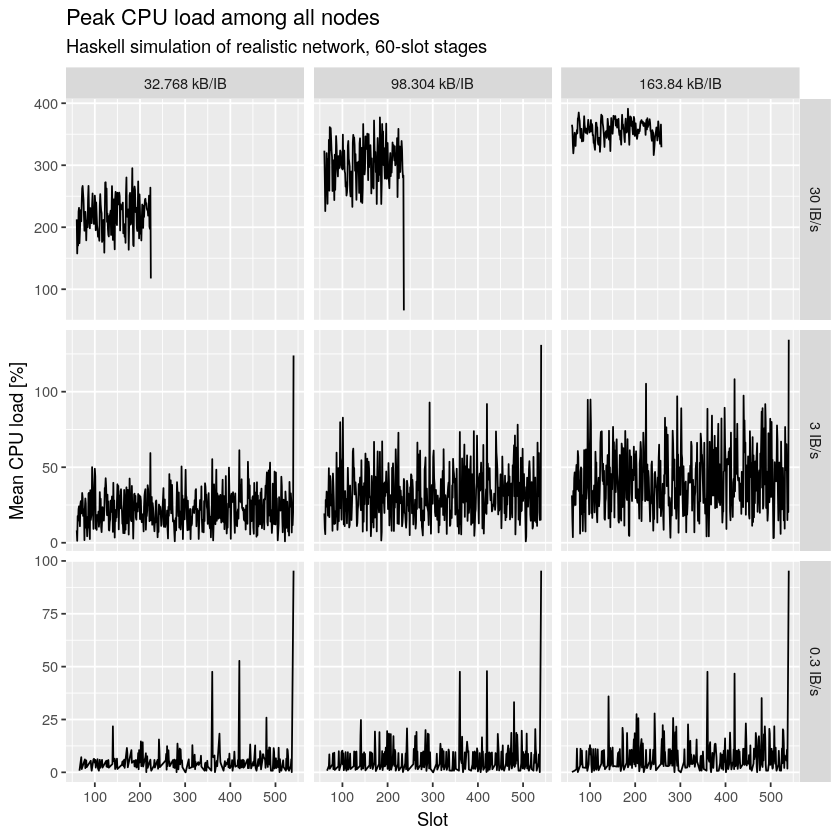

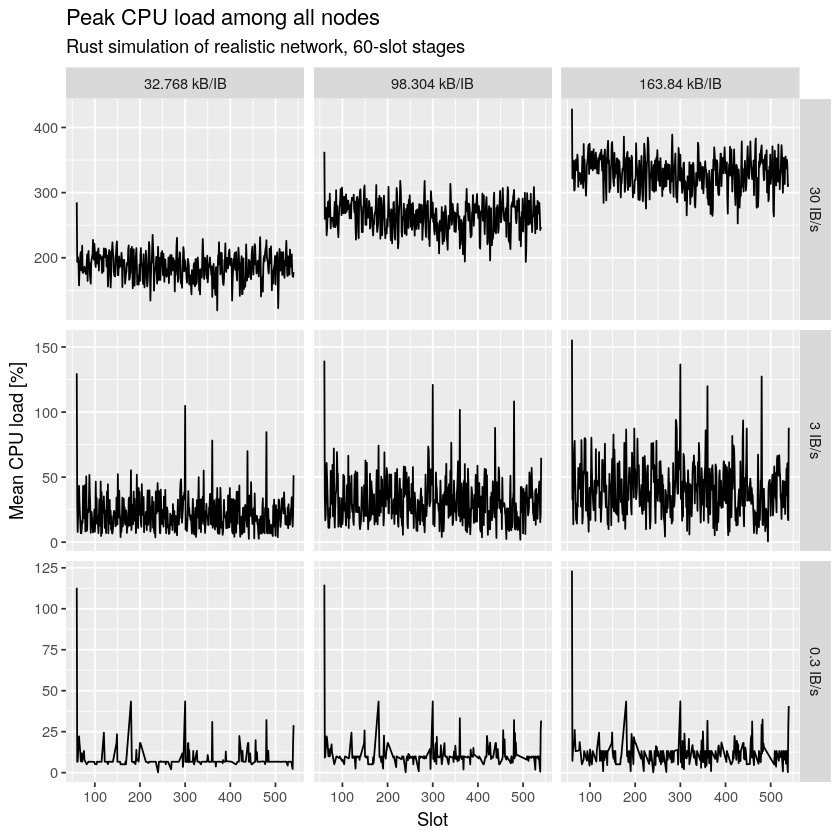

In [52]:
for (s in cpus[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    cpusNode[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`
        )
    ], 
    aes(x=`slot`, y=`duration`)) +
    geom_line() +
    facet_grid(`ibRate` ~ `ibSize`, scale="free_y") +
    xlab("Slot") +
    ylab("Mean CPU load [%]") +
    ggtitle("Peak CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/cpu-peak-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### Mean CPU usage

##### Histogram

In [53]:
retask <- function(h) {
    if (h == "GenIB")
        "IBBlockGenerated"
    else if (h == "ValIH")
        "IBHeaderValidated"
    else if (h == "ValIB")
        "IBBlockValidated"
    else if (h == "GenEB")
        "EBBlockGenerated"
    else if (h =="ValEB")
        "EBBlockValidated"
    else if (h == "GenVote")
        "VTBundleGenerated"
    else if (h == "ValVote")
        "VTBundleValidated"
    else if (h == "GenRB")
        "RBBlockGenerated"
    else if (h == "ValRB")
        "RBBlockValidated"
    else if (h == "ValRH")
        "RBHeaderValidated"
    else
        h
}

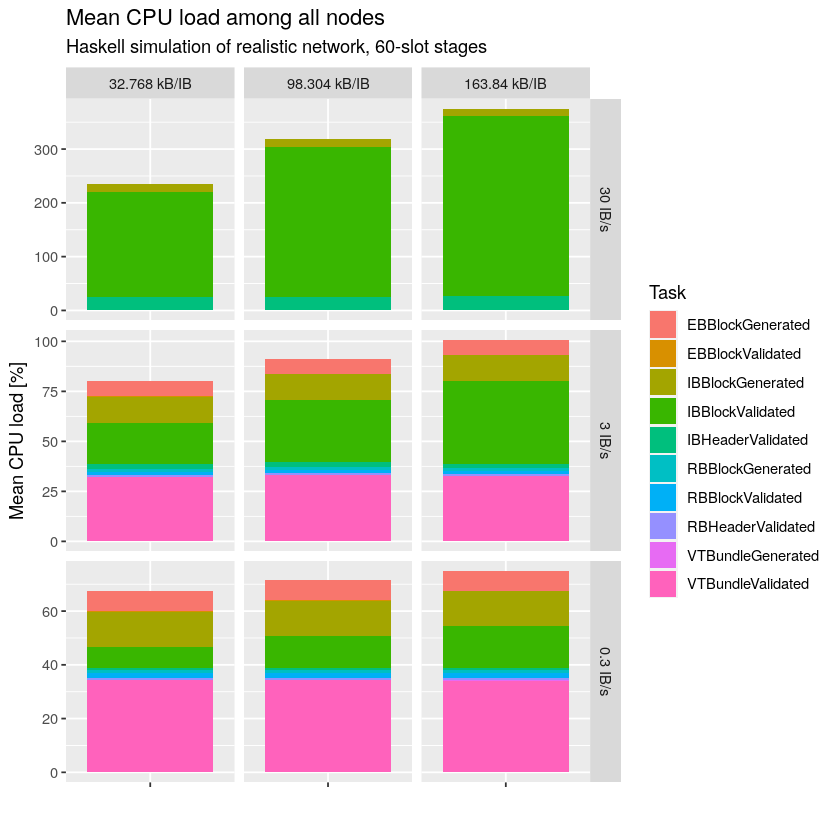

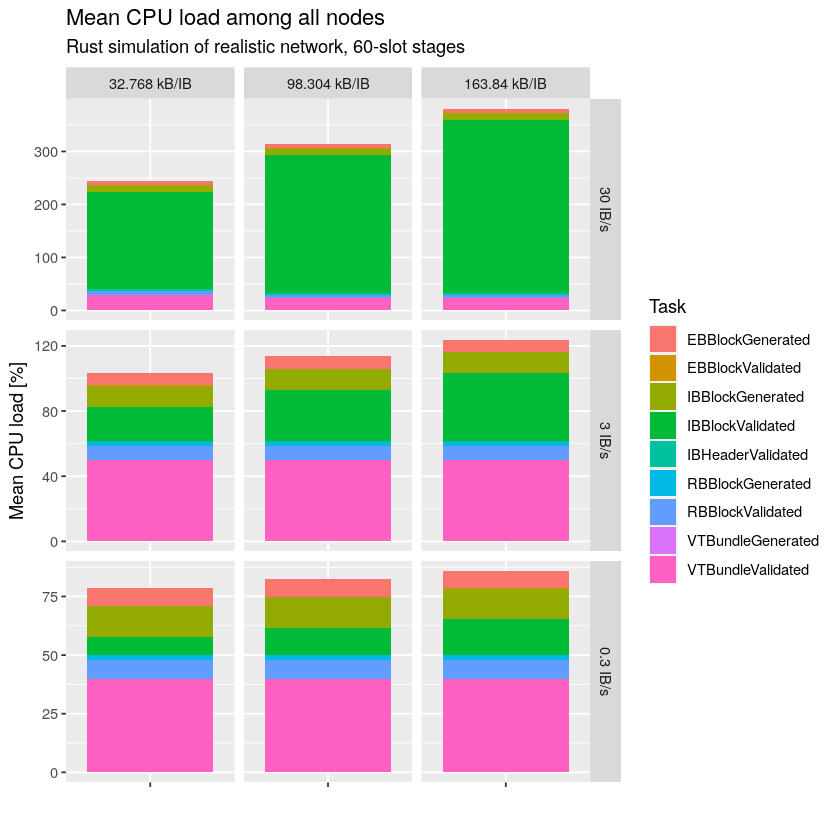

In [54]:
for (s in cpus[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    cpus[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Task`=mapply(retask, `task`)
        )
    ], 
    aes(x="", fill=`Task`, y=`duration`)) +
    geom_bar(stat = "identity") +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("") +
    ylab("Mean CPU load [%]") +
    ggtitle("Mean CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/cpu-mean-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

##### Time series

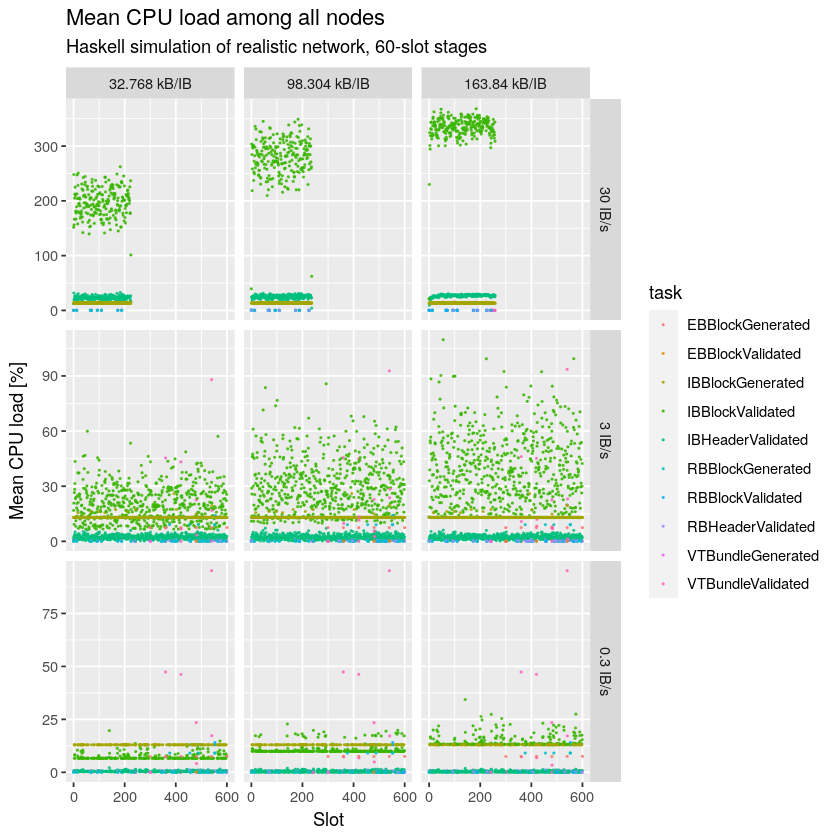

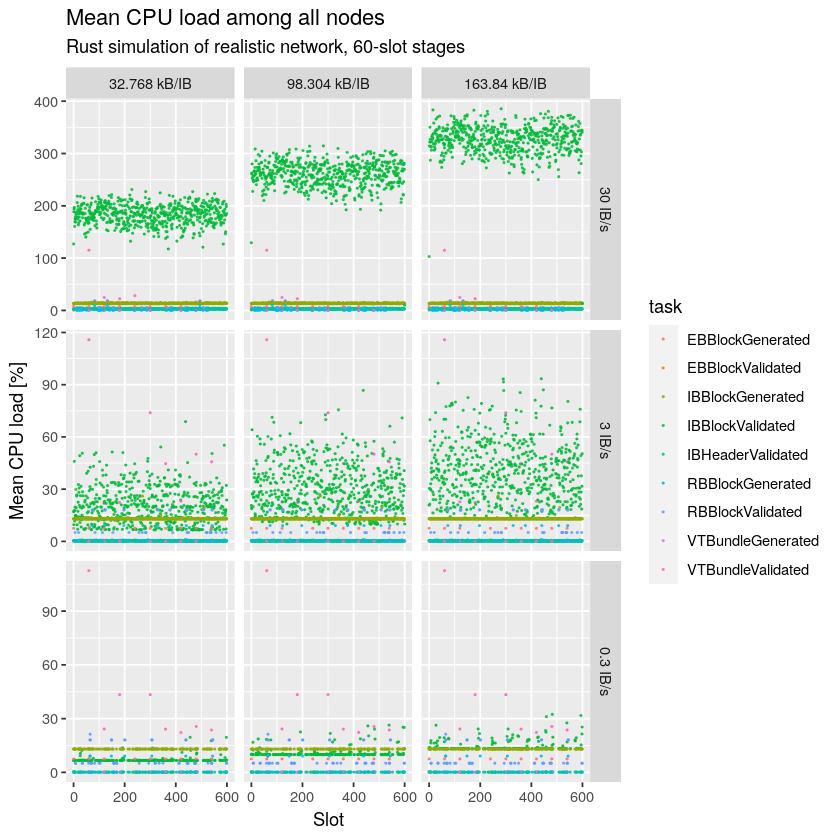

In [55]:
for (s in cpus[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    cpus[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `duration`=100*mean(`duration`)
        ),
        by=.(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(cpusNode[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(cpusNode[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `slot`,
            `task`=mapply(retask, `task`)
        )
    ], 
    aes(x=`slot`, y=`duration`, color=`task`)) +
    geom_point(size=0.25, alpha=0.75) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    xlab("Slot") +
    ylab("Mean CPU load [%]") +
    ggtitle("Mean CPU load among all nodes", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/cpu-mean-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### Fraction throttled

In [56]:
# TBD

#### Idle time

In [57]:
# TBD

### Input blocks

#### Read results

In [58]:
if (file.exists("../2025w12xl/results/ibgen.csv.gz")) {
    ibgen <- fread("../2025w12xl/results/ibgen.csv.gz", stringsAsFactors=TRUE)
} else {
    ibgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w12xl", collection="ibgen")$find(), stringsAsFactors=TRUE)
    fwrite(ibgen, "../2025w12xl/results/ibgen.csv")
}
ibgen %>% summary

   simulator          network          label       leios-stage-length-slots
 haskell:27316   realistic:87082   default:87082   Min.   :60              
 rust   :59766                                     1st Qu.:60              
                                                   Median :60              
                                                   Mean   :60              
                                                   3rd Qu.:60              
                                                   Max.   :60              
                                                                           
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 0.30             Min.   : 32768         Min.   :1.5              
 1st Qu.:30.00             1st Qu.: 32768         1st Qu.:1.5              
 Median :30.00             Median : 98304         Median :1.5              
 Mean   :26.32             Mean   : 99041         Mean   :1.5              
 3rd Qu.:30.

#### IB inculsion in EBs

##### Histogram

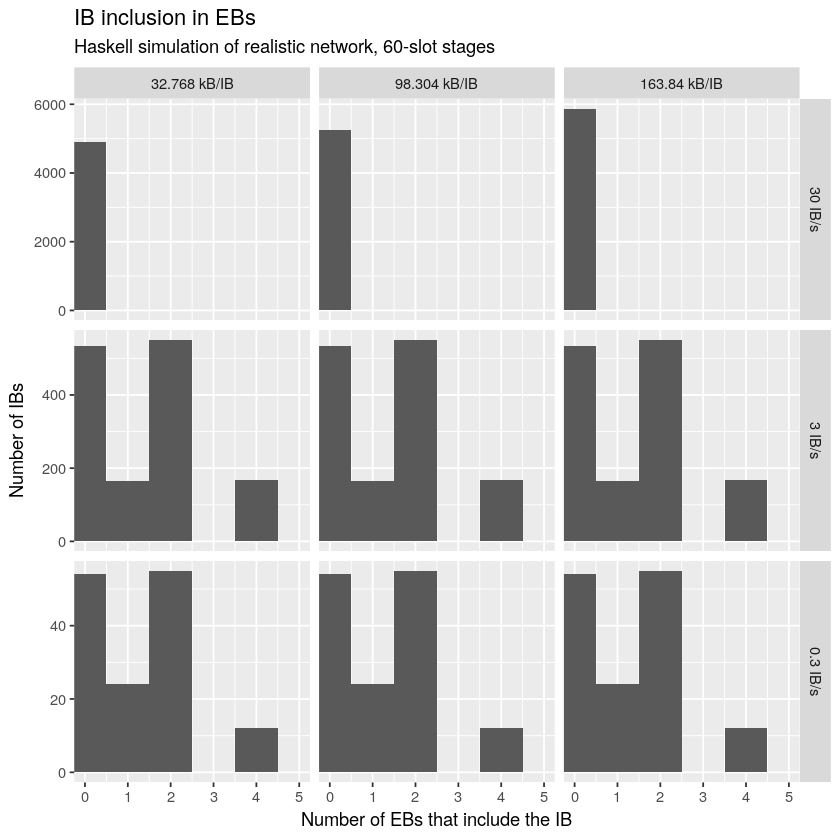

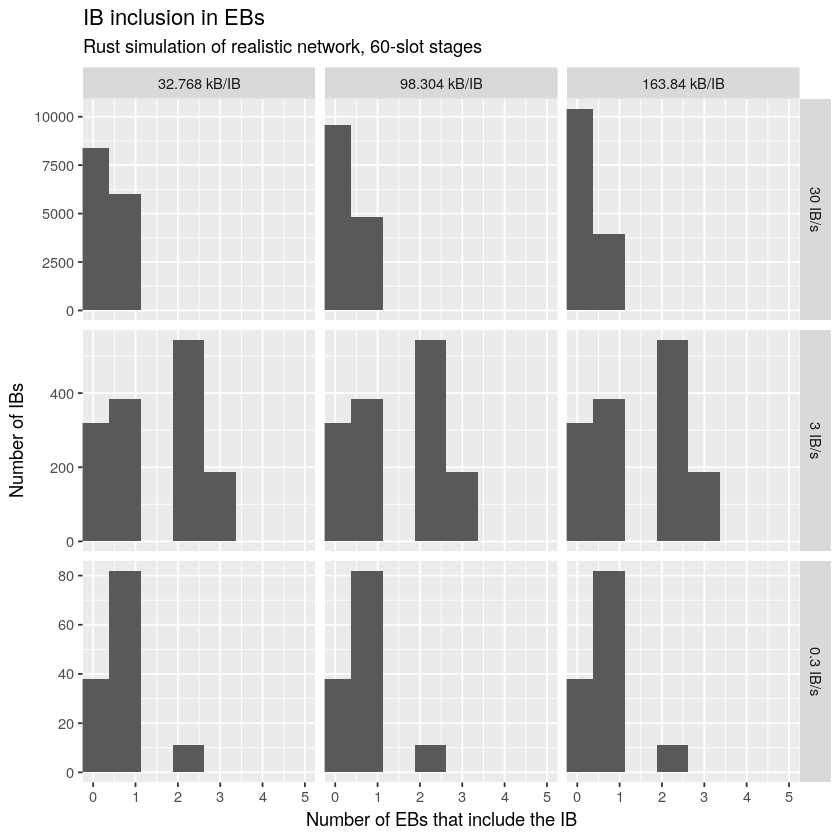

In [59]:
for (s in ibgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of EBs that include the IB`=`eb-count`
        )
    ],
    aes(x=`Number of EBs that include the IB`)
) +
    geom_histogram(bins=5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    coord_cartesian(xlim=c(0, 5)) +
    ylab("Number of IBs") +
    ggtitle("IB inclusion in EBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ib-inclusion-ebs-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

##### Time series

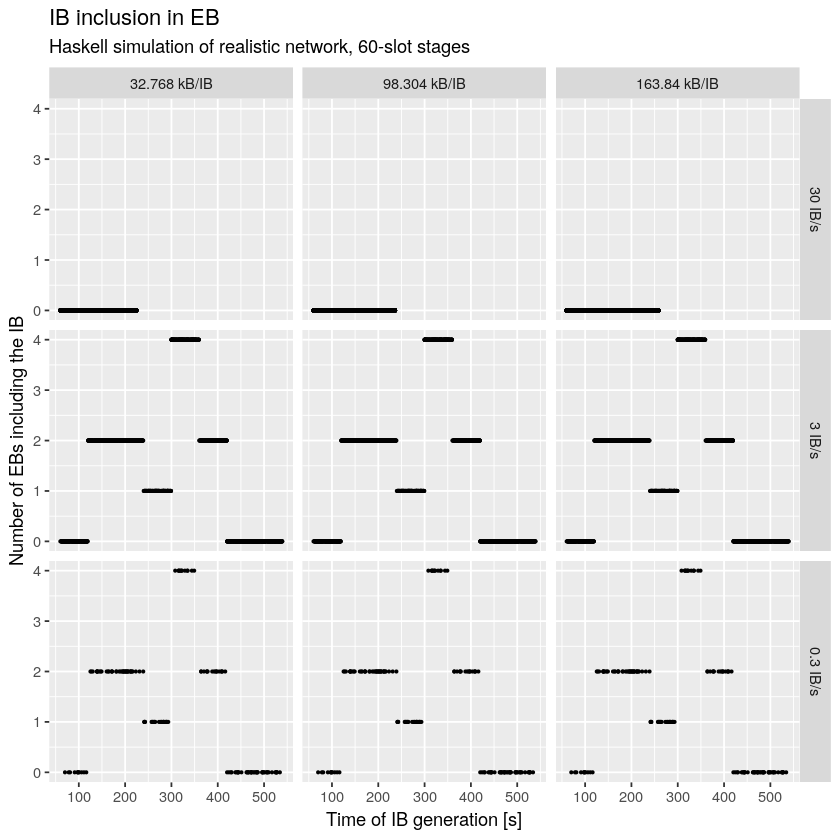

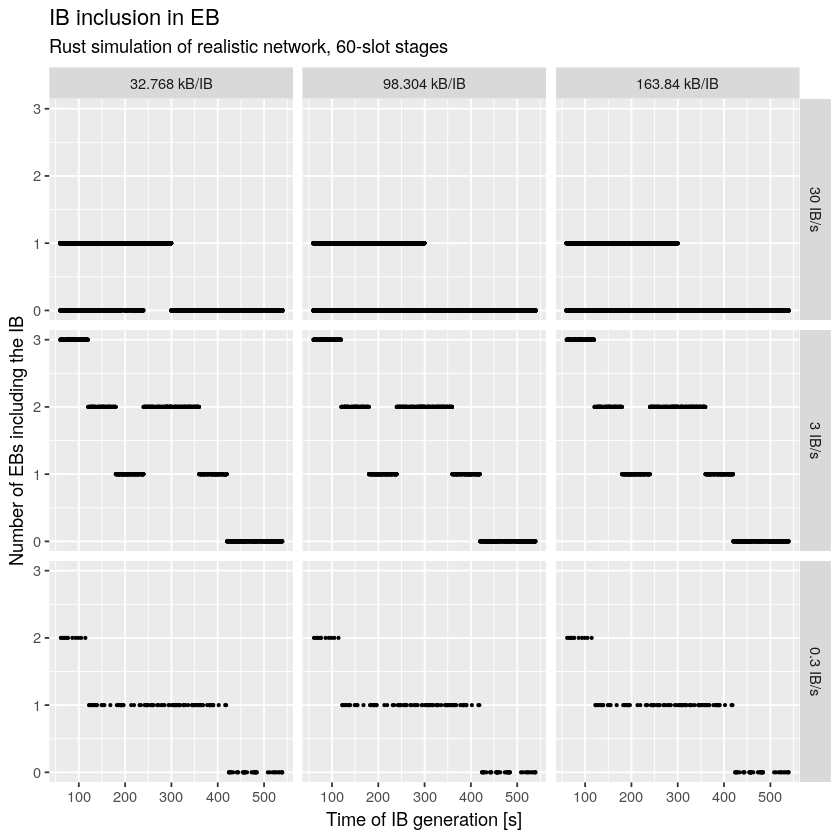

In [60]:
for (s in ibgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `Number of EBs including the IB`=`eb-count`
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`Number of EBs including the IB`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB inclusion in EB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ib-inclusion-ebs-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### Time of IB inclusion in an EB

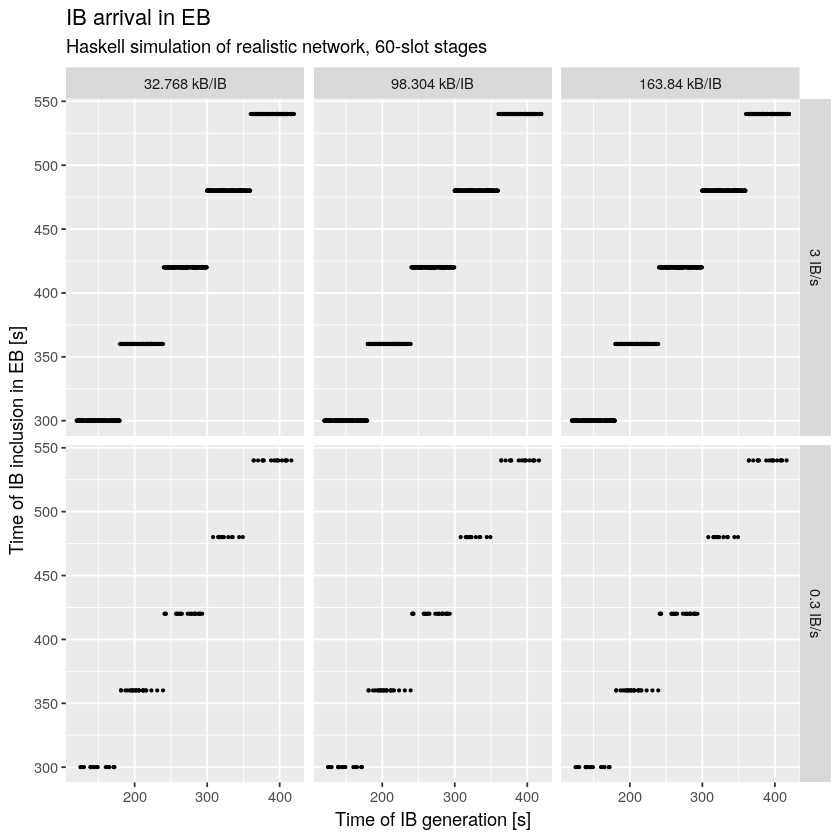

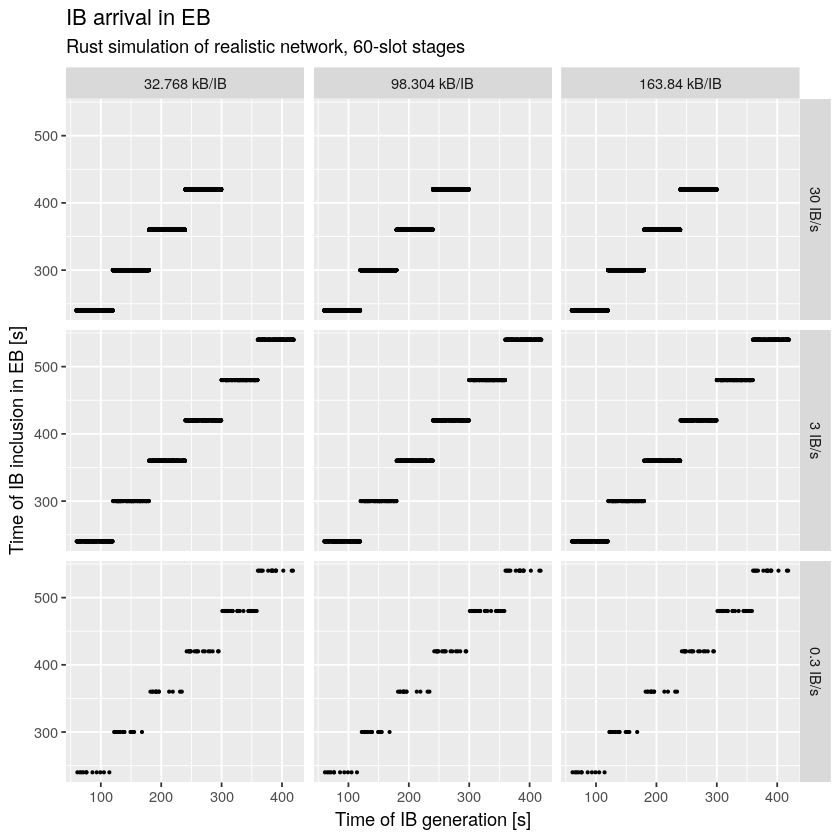

In [61]:
for (s in ibgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & !is.na(`eb-first`) & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `Time of IB inclusion in EB [s]`=`eb-first`
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`Time of IB inclusion in EB [s]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB arrival in EB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ib-arrival-eb-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### IB size

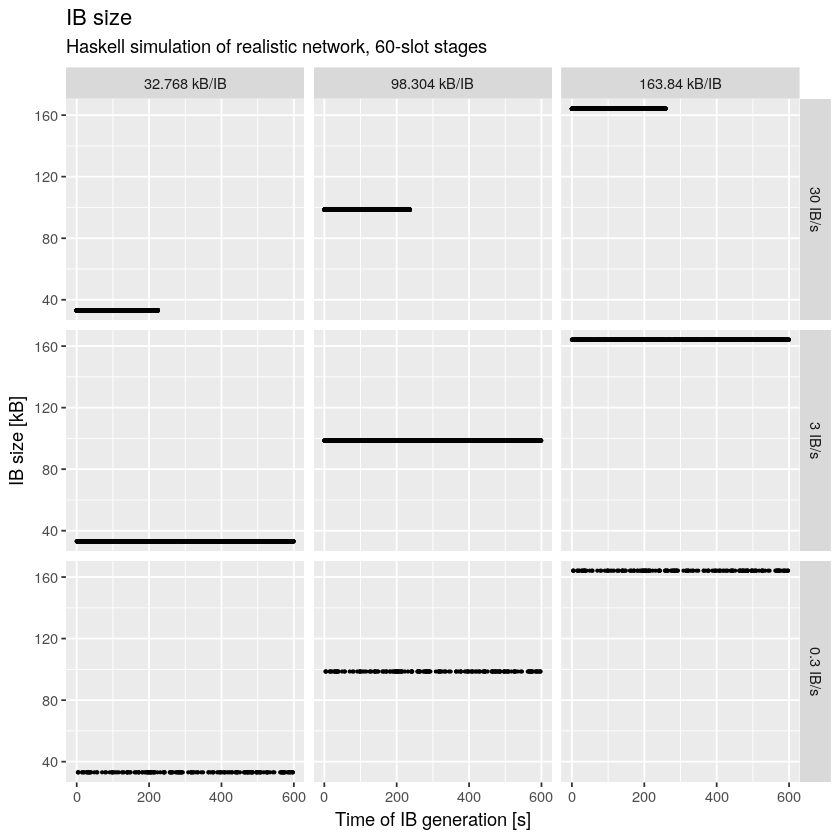

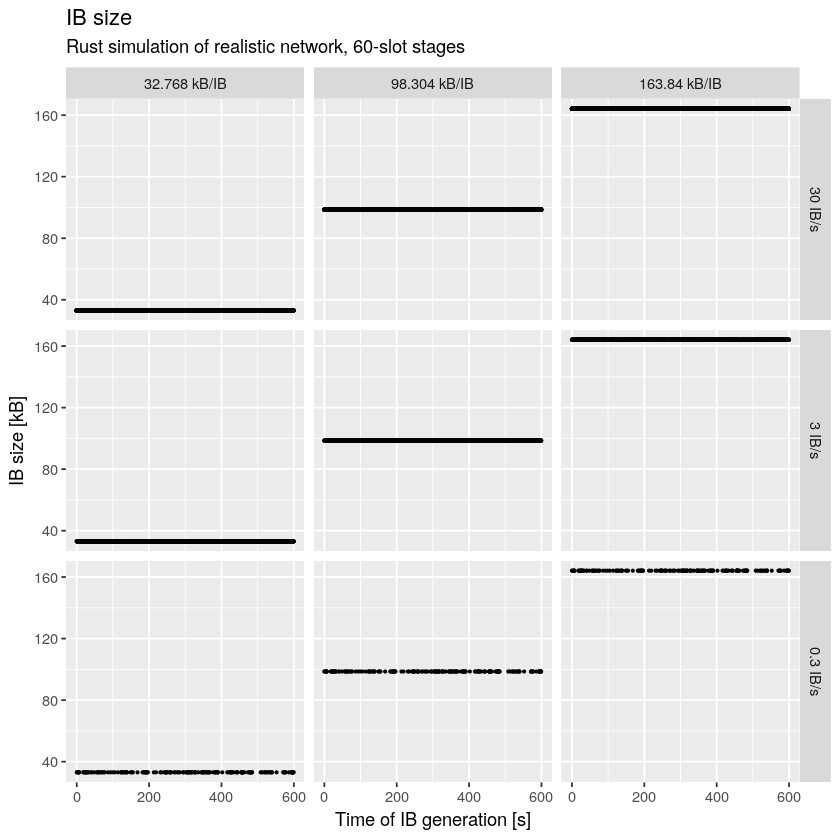

In [62]:
for (s in ibgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ibgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ibgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ibgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of IB generation [s]`=`time`,
            `IB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of IB generation [s]`, y=`IB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("IB size", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ib-size-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

### Endorser blocks

#### Read results

In [63]:
if (file.exists("../2025w12xl/results/ebgen.csv.gz")) {
    ebgen <- fread("../2025w12xl/results/ebgen.csv.gz", stringsAsFactors=TRUE)
} else {
    ebgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w12xl", collection="ebgen")$find(), stringsAsFactors=TRUE)
    fwrite(ebgen, "../2025w12xl/results/ebgen.csv")
}
ebgen %>% summary

   simulator        network        label     leios-stage-length-slots
 haskell: 66   realistic:204   default:204   Min.   :60              
 rust   :138                                 1st Qu.:60              
                                             Median :60              
                                             Mean   :60              
                                             3rd Qu.:60              
                                             Max.   :60              
                                                                     
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 0.300            Min.   : 32768         Min.   :1.5              
 1st Qu.: 0.300            1st Qu.: 32768         1st Qu.:1.5              
 Median : 3.000            Median : 98304         Median :1.5              
 Mean   : 7.129            Mean   : 98304         Mean   :1.5              
 3rd Qu.: 3.000            3rd Qu.:163840         3rd Qu.:1.

#### EB inclusion in RBs

##### Histogram

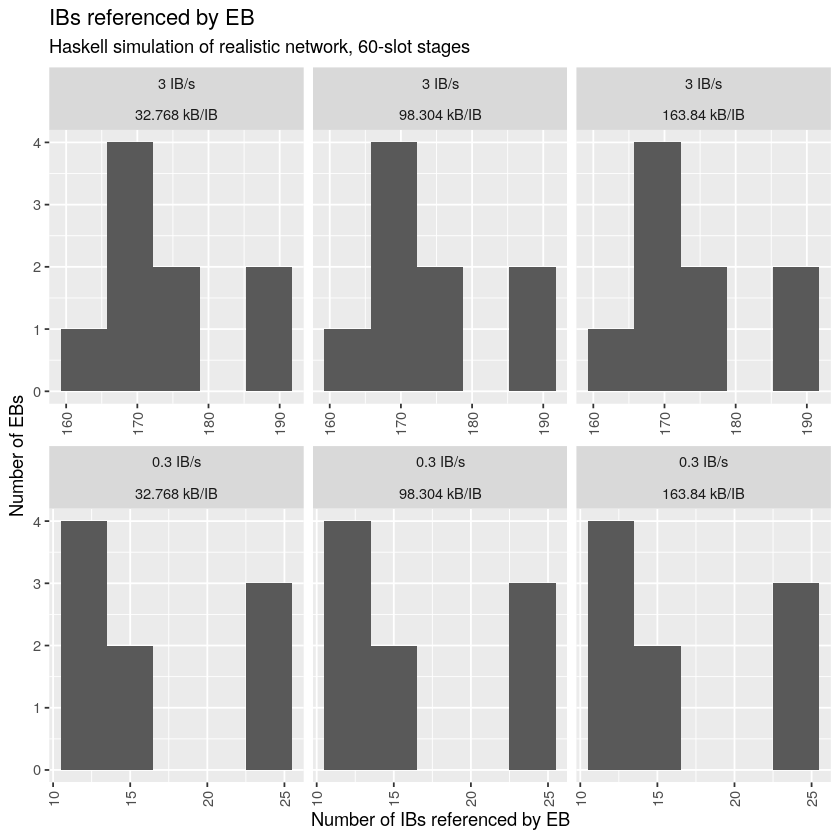

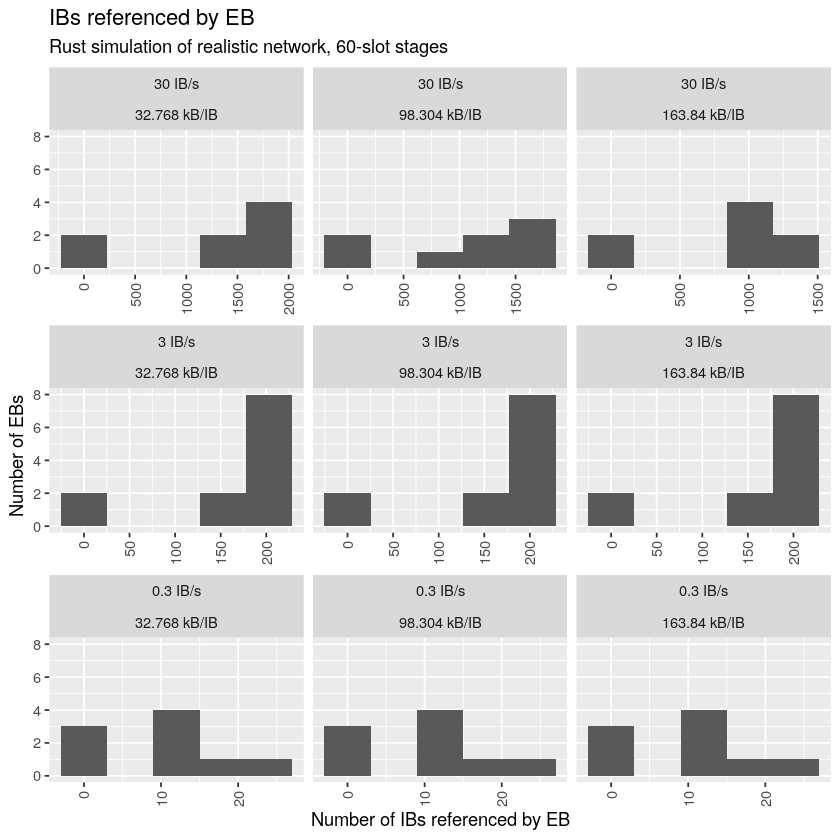

In [64]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of IBs referenced by EB`=`ib-count`
        )
    ],
    aes(x=`Number of IBs referenced by EB`)
) +
    geom_histogram(bins=5) +
    facet_wrap(`ibRate` ~ `ibSize`, scales="free_x") +
    ylab("Number of EBs") +
    ggtitle("IBs referenced by EB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages")) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5))
print(g)
ggsave(paste0("../2025w12xl/plots/ibs-referenced-eb-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

##### Time series

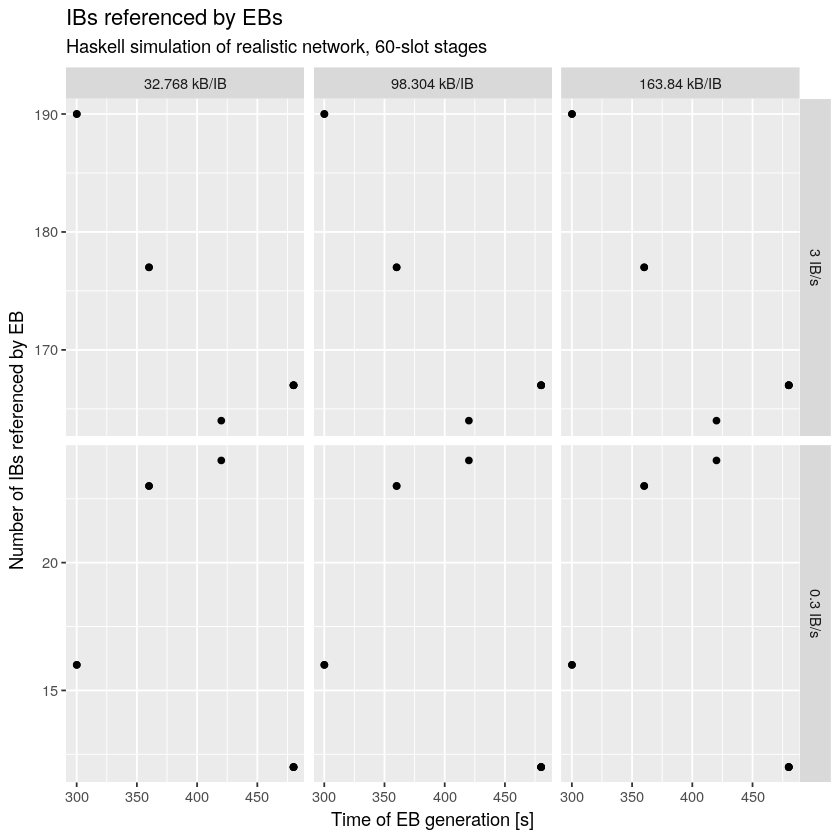

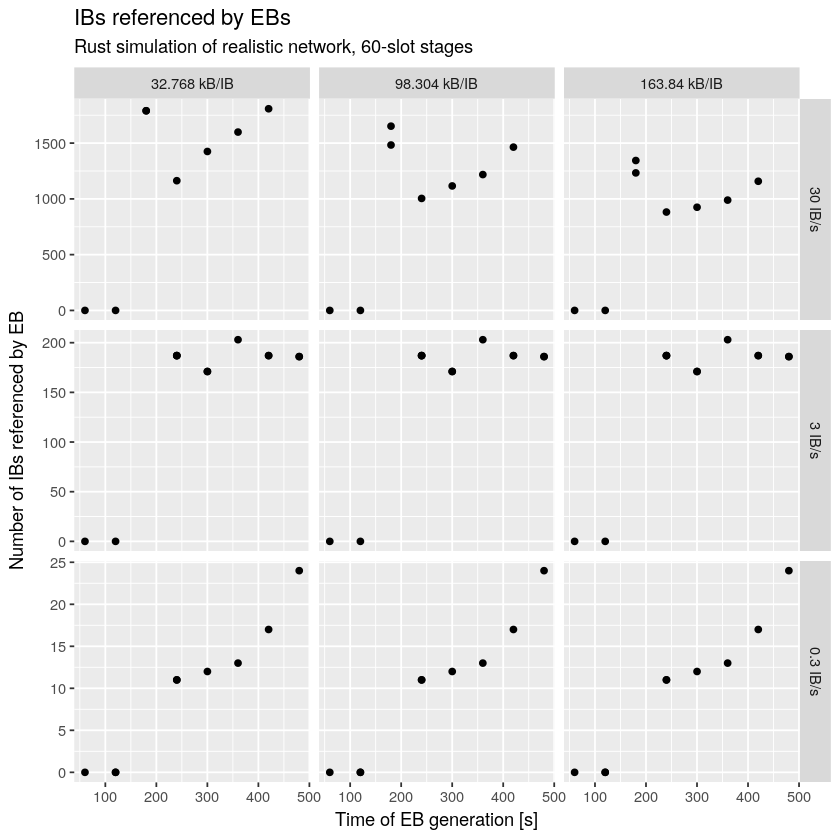

In [65]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Number of IBs referenced by EB`=`ib-count`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Number of IBs referenced by EB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ggtitle("IBs referenced by EBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ibs-referenced-ebs-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### EB inclusion in RBs

##### Histogram

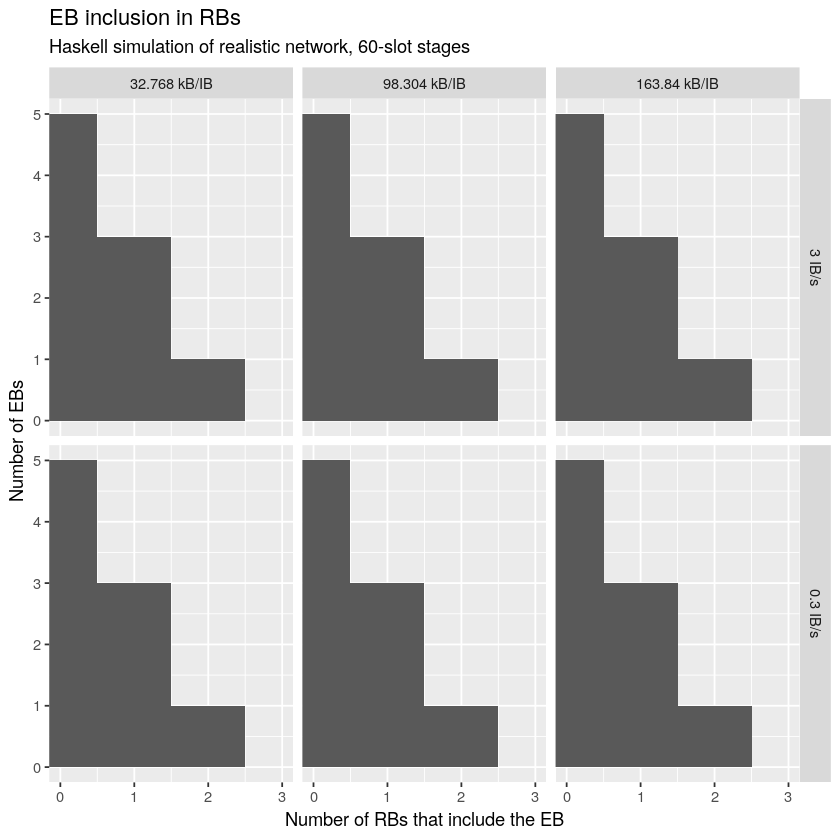

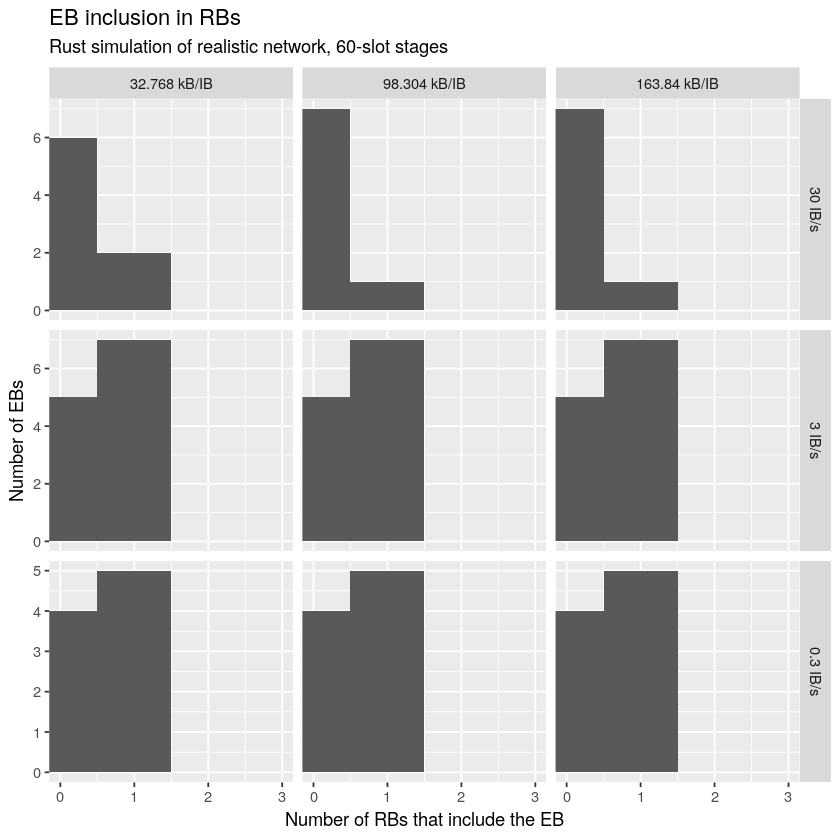

In [66]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of RBs that include the EB`=`rb-count`
        )
    ],
    aes(x=`Number of RBs that include the EB`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    coord_cartesian(xlim=c(0, 3)) +
    ylab("Number of EBs") +
    ggtitle("EB inclusion in RBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/eb-inclusion-rbs-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

##### Time series

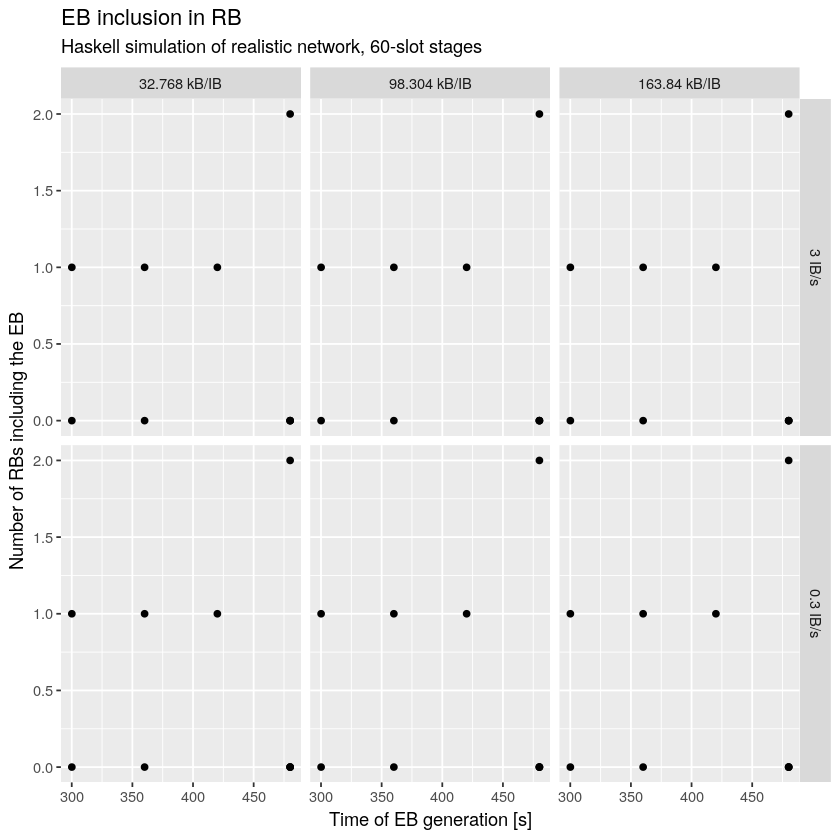

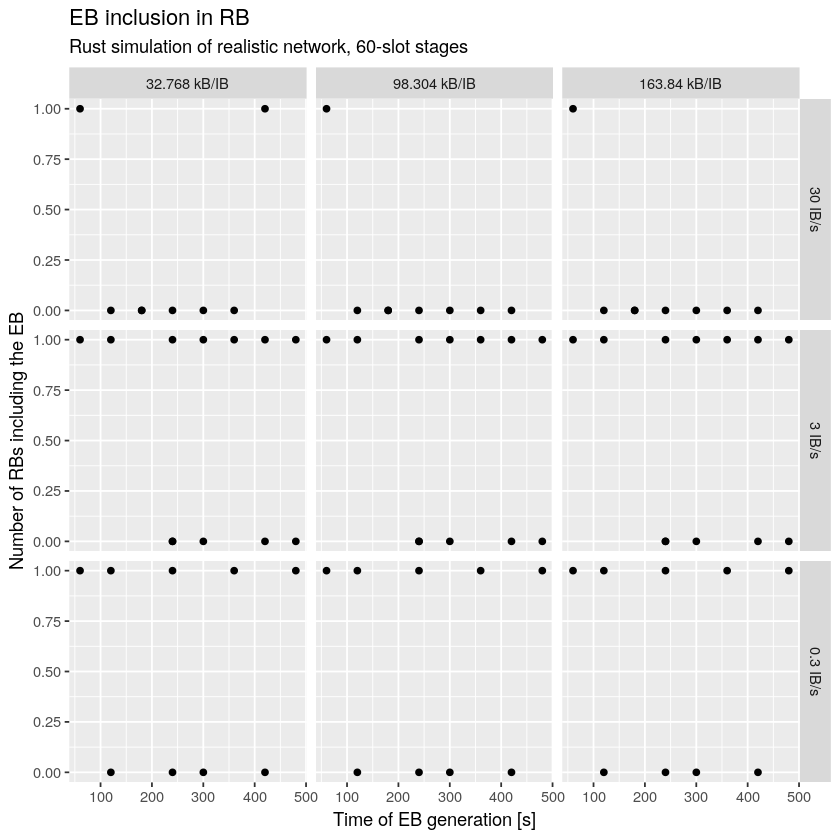

In [67]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Number of RBs including the EB`=`rb-count`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Number of RBs including the EB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB inclusion in RB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/eb-inclusion-rbs-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### Time of EB inclusion in an RB

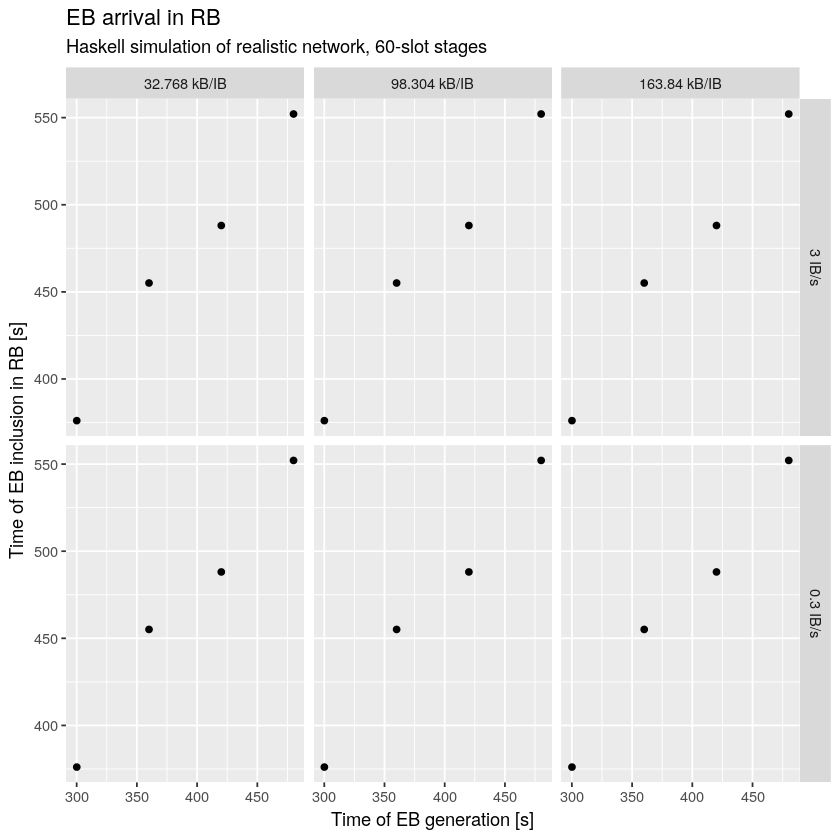

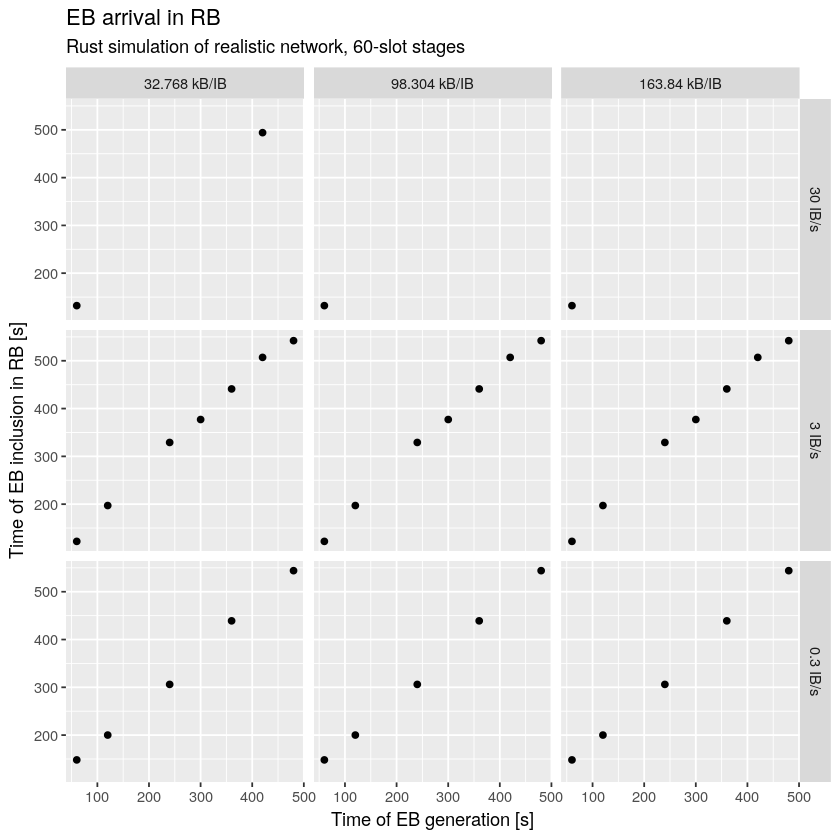

In [68]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & `rb-count` > 0 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `Time of EB inclusion in RB [s]`=`rb-first`
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`Time of EB inclusion in RB [s]`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB arrival in RB", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/eb-arrival-rb-", s, ".png"), units="in", width=8, height=6, dpi=150)

}

#### EB size

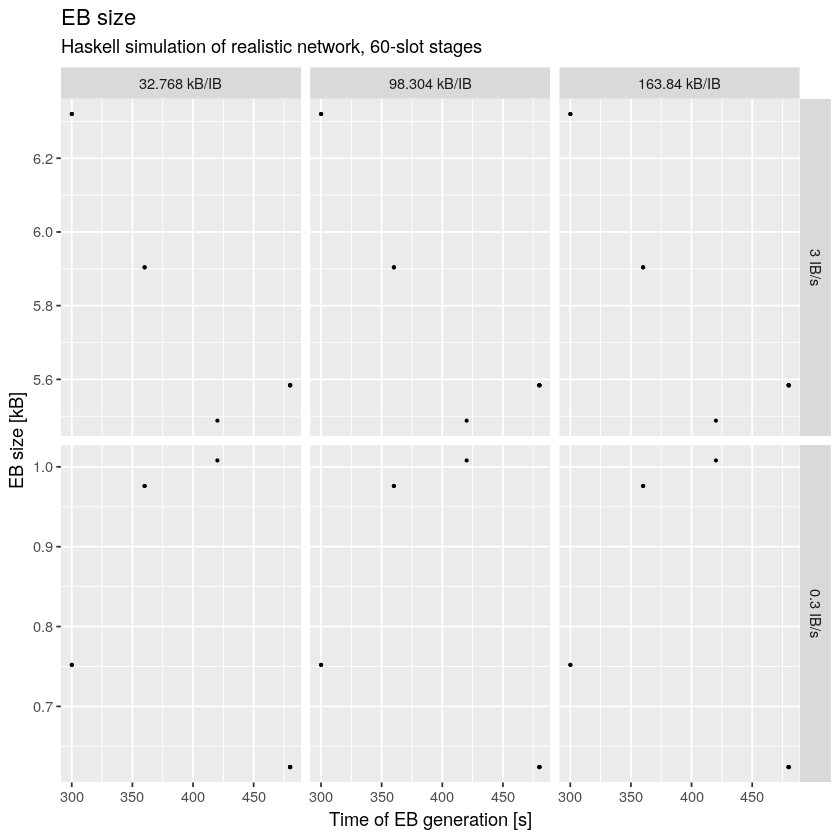

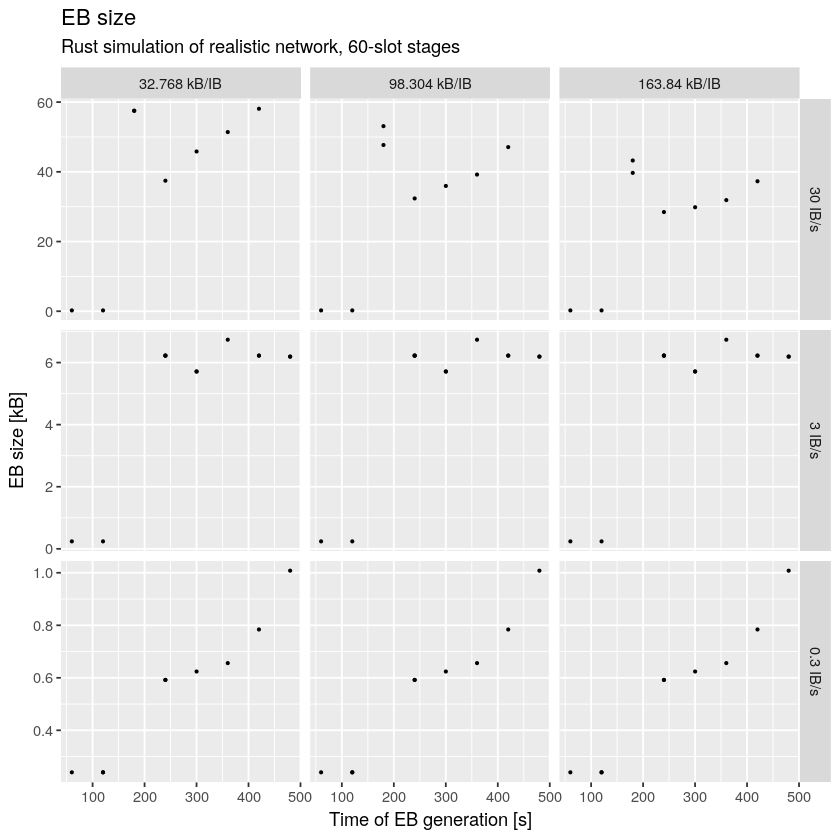

In [69]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60 & time >= 60 & time <= 540,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of EB generation [s]`=`time`,
            `EB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of EB generation [s]`, y=`EB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    ggtitle("EB size", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/eb-size-timeseries", s, ".png"), units="in", width=8, height=6, dpi=150)

}

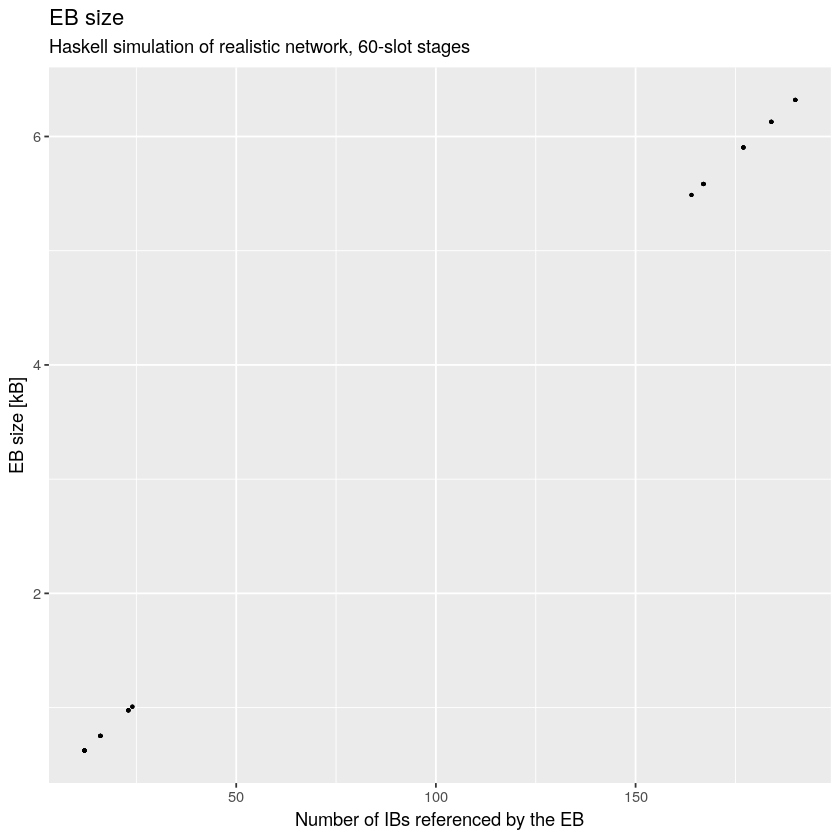

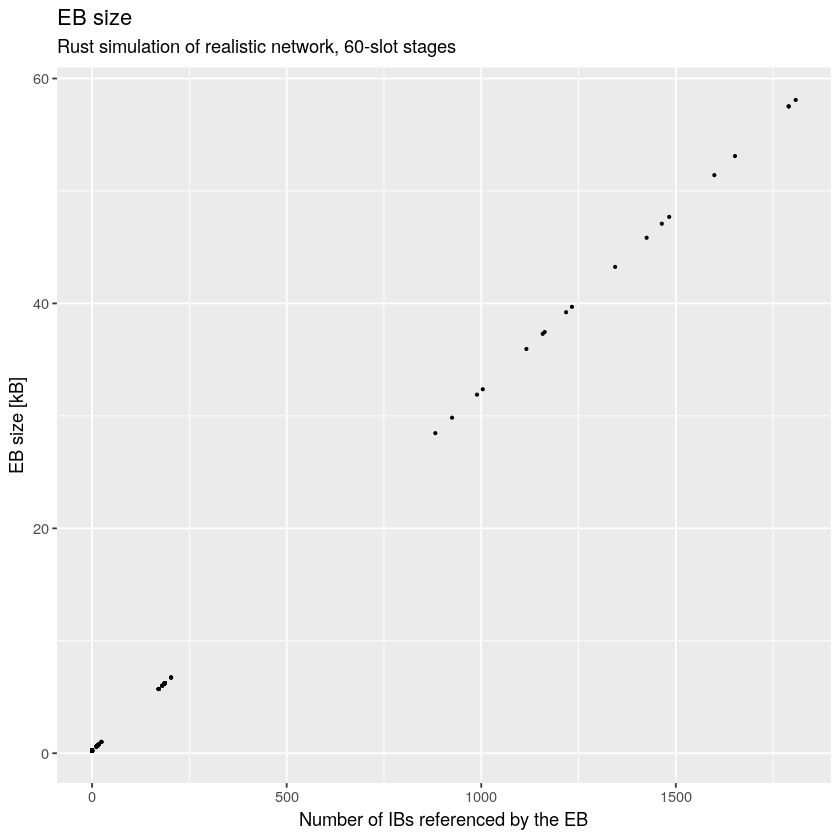

In [70]:
for (s in ebgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    ebgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(ebgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(ebgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of IBs referenced by the EB`=`ib-count`,
            `EB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Number of IBs referenced by the EB`, y=`EB size [kB]`)
) +
    geom_point(size=0.5) +
    #facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("EB size", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/eb-size-scatterplot-", s, ".png"), units="in", width=8, height=6, dpi=150)
 
}

### Ranking blocks

#### Read results

In [71]:
if (file.exists("../2025w12xl/results/rbgen.csv.gz")) {
    rbgen <- fread("../2025w12xl/results/rbgen.csv.gz", stringsAsFactors=TRUE)
} else {
    rbgen <- data.table(mongo(url="mongodb://thelio", db="leios2025w12xl", collection="rbgen")$find(), stringsAsFactors=TRUE)
    fwrite(rbgen, "../2025w12xl/results/rbgen.csv")
}
rbgen %>% summary

   simulator        network        label     leios-stage-length-slots
 haskell:243   realistic:522   default:522   Min.   :60              
 rust   :279                                 1st Qu.:60              
                                             Median :60              
                                             Mean   :60              
                                             3rd Qu.:60              
                                             Max.   :60              
                                                                     
 ib-generation-probability ib-body-avg-size-bytes eb-generation-probability
 Min.   : 0.300            Min.   : 32768         Min.   :1.5              
 1st Qu.: 0.300            1st Qu.: 32768         1st Qu.:1.5              
 Median : 3.000            Median : 98304         Median :1.5              
 Mean   : 8.136            Mean   : 98555         Mean   :1.5              
 3rd Qu.: 3.000            3rd Qu.:163840         3rd Qu.:1.

#### EB inclusion in RBs

##### Histogram

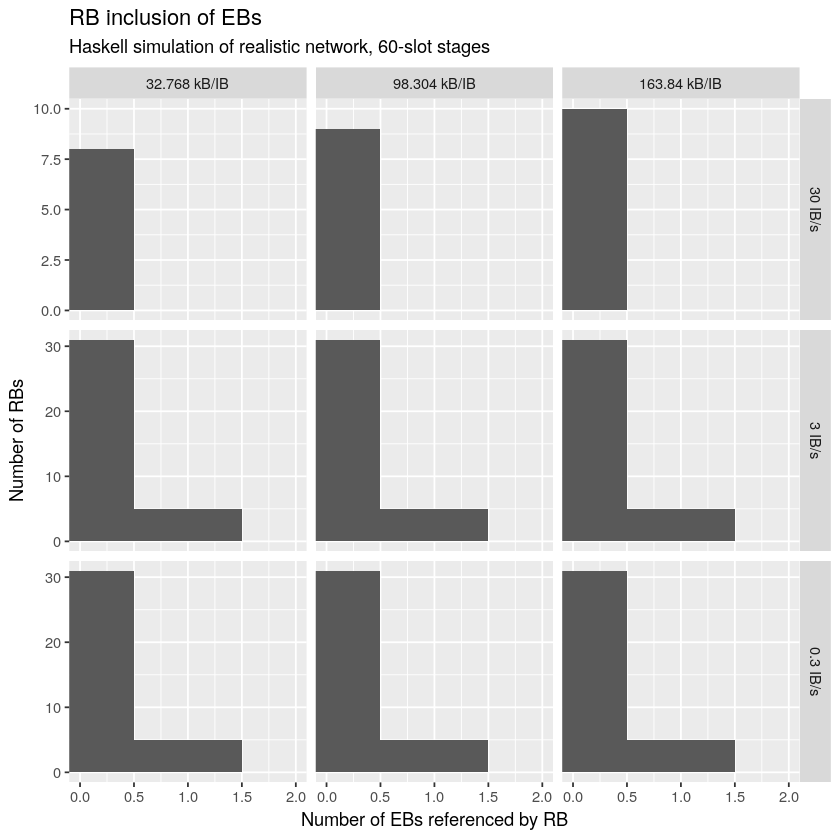

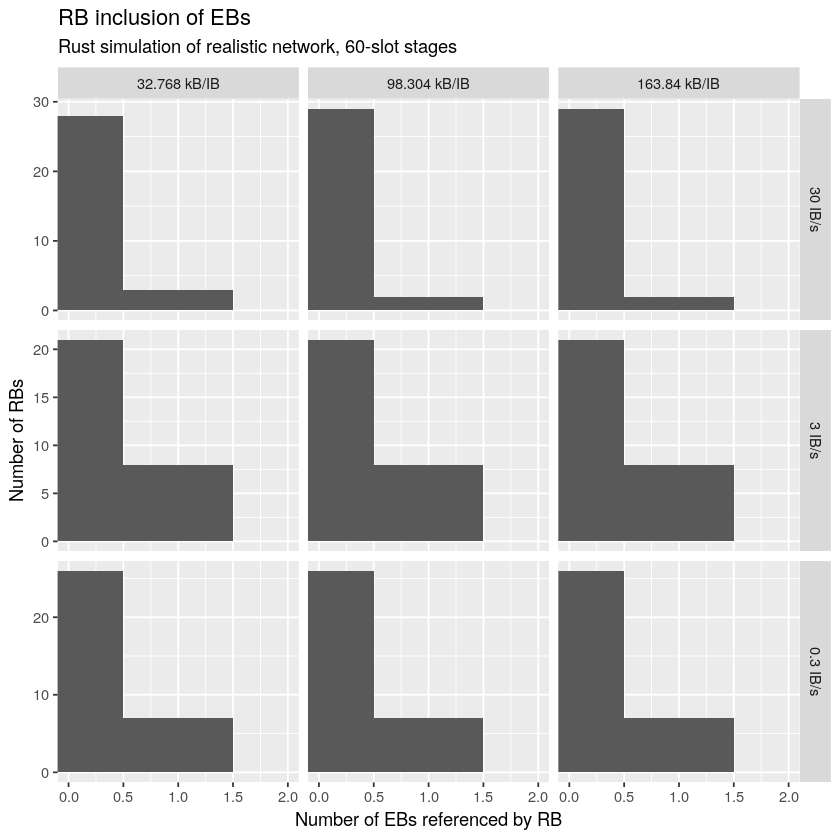

In [72]:
for (s in rbgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Number of EBs referenced by RB`=`eb-count`
        )
    ],
    aes(x=`Number of EBs referenced by RB`)
) +
    geom_histogram(binwidth=1) +
    facet_grid(`ibRate` ~ `ibSize`, scales="free_y") +
    coord_cartesian(xlim=c(0, 2)) +
    ylab("Number of RBs") +
    ggtitle("RB inclusion of EBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ebs-referenced-rb-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
    
}

##### Time series

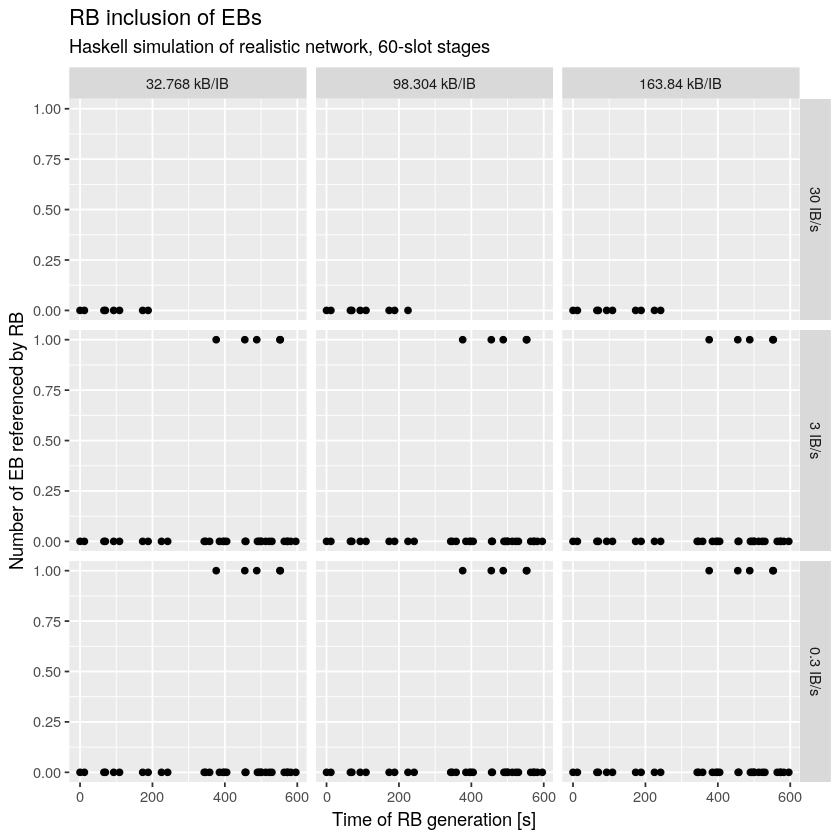

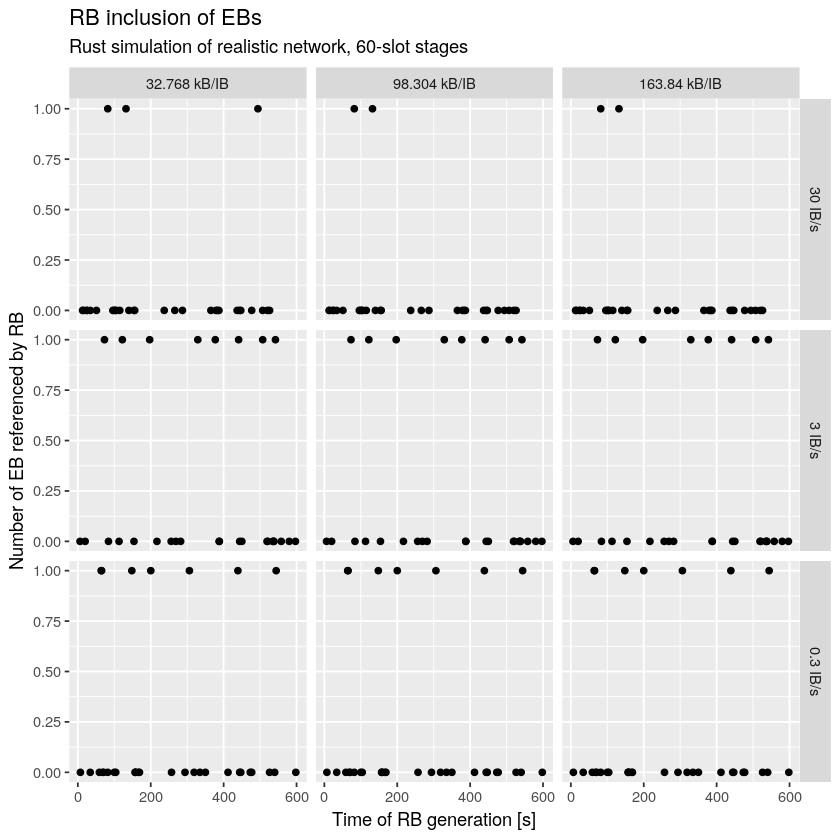

In [73]:
for (s in rbgen[,unique(`simulator`)%>%sort]) {

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of RB generation [s]`=`time`,
            `Number of EB referenced by RB`=`eb-count`
        )
    ],
    aes(x=`Time of RB generation [s]`, y=`Number of EB referenced by RB`)
) +
    geom_point(size=1.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("RB inclusion of EBs", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/ebs-referenced-rb-timeseries-", s, ".png"), units="in", width=8, height=6, dpi=150)
    
}

#### RB size

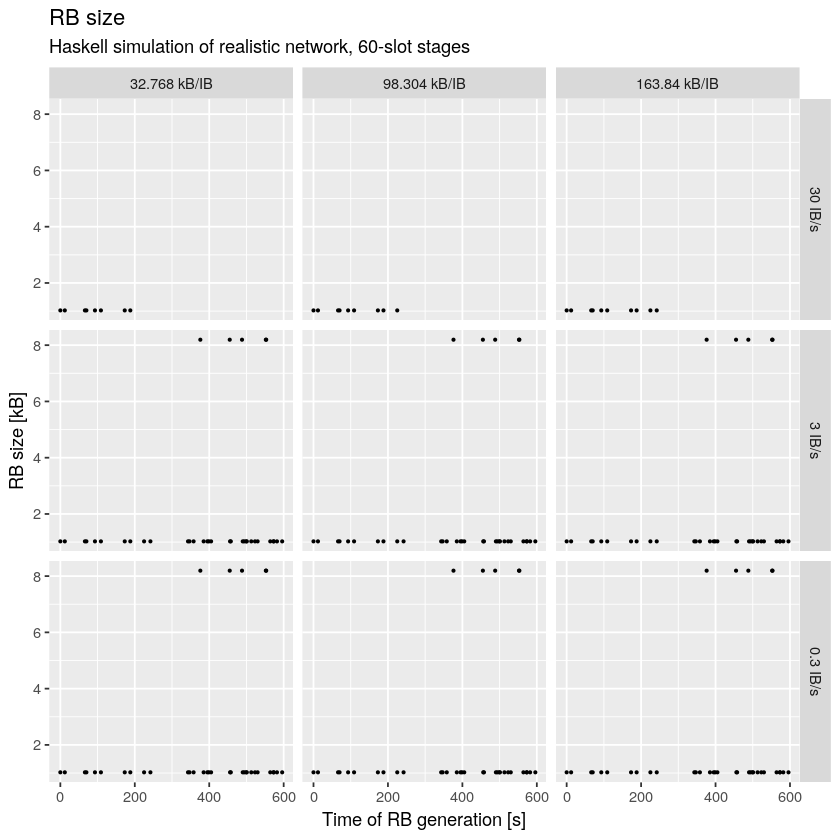

In [74]:
for (s in rbgen[,unique(`simulator`)%>%sort]) {
if (s == "rust")
    next

g <- ggplot(
    rbgen[
        `simulator` == s & `leios-stage-length-slots` == 60,
        .(
            `ibRate`=factor(paste(`ib-generation-probability`, "IB/s"), levels=paste(rbgen[, sort(unique(`ib-generation-probability`),decreasing=TRUE)], "IB/s")),
            `ibSize`=factor(paste(`ib-body-avg-size-bytes`/1000, "kB/IB"), levels=paste(rbgen[, sort(unique(`ib-body-avg-size-bytes`))]/1000, "kB/IB")),
            `Time of RB generation [s]`=`time`,
            `RB size [kB]`=`size`/1000
        )
    ],
    aes(x=`Time of RB generation [s]`, y=`RB size [kB]`)
) +
    geom_point(size=0.5) +
    facet_grid(`ibRate` ~ `ibSize`) +
    ggtitle("RB size", subtitle=paste(s %>% str_to_title, "simulation of realistic network, 60-slot stages"))
print(g)
ggsave(paste0("../2025w12xl/plots/rb-size-histogram-", s, ".png"), units="in", width=8, height=6, dpi=150)
    
}